# Von Karman Vortex Shedding at Re=100
By Alan Kaptanoglu and Jared Callaham

This example is based on the manifold model, POD-Galerkin models, and constrained SINDy models of the following papers:

1. Schlegel 2013. On long-term boundedness of Galerkin models
2. Noack, 2003. A hierarchy of low-dimensional models for the transient and post-transient cylinder wake.
3. Loiseau 2018 Constrained sparse Galerkin regression. and uses some of the constrained and advanced SINDy features illustrated in examples 7 and 8.
The goal of this example is to show a detailed comparison of Galerkin models for the Re=100 von Karman shedding, between a center manifold model, a number of calculated POD-Galerkin models, and unconstrained/constrained SINDy models.

### Setup

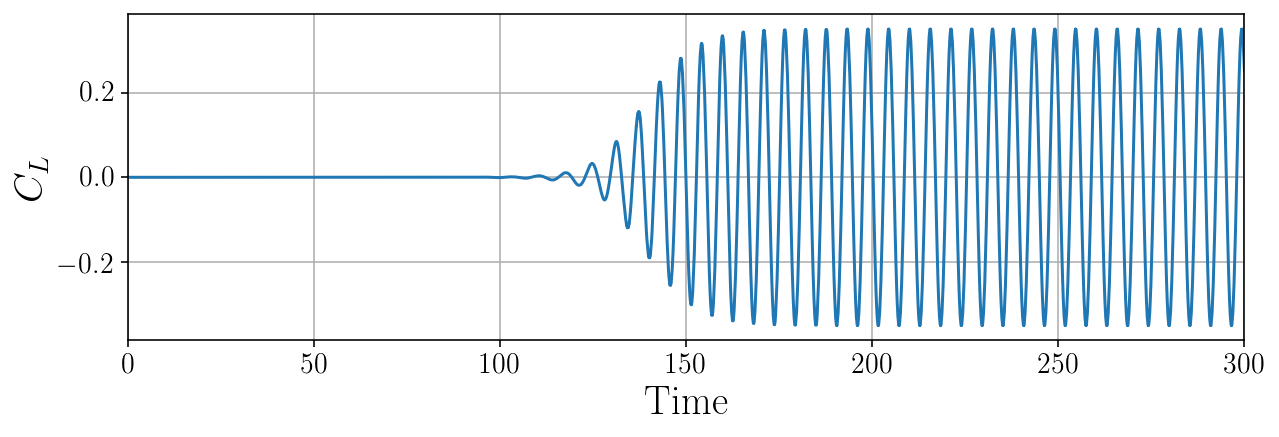

Strouhal number: 0.1800
Uncertainty +/- 0.0100
Approximate period: 5.5556
dict_keys(['__header__', '__version__', '__globals__', 'L', 'Q', 'pg_model'])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import pysindy as ps
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import complex_ode

mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(12, 8))
%config InlineBackend.figure_format = 'retina'

mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

galerkin = sio.loadmat('models/galerkin9.mat')
L = galerkin['L']
#with np.printoptions(precision=4, suppress=True):
#    print(L)
# Load aerodynamic moments
data = np.loadtxt('./forceCoeffs.dat', skiprows=1)
t_coeff = data[:, 0]
CD = data[:, 1]
CL = data[:, 2]

# Get rid of duplicates
t_coeff, idx = np.unique(t_coeff, return_index=True)
CD = CD[idx]
CL = CL[idx]

plt.figure(figsize=(10, 3))
plt.plot(t_coeff, CL, label='DNS')
plt.xlabel('Time')
plt.ylabel(r'$C_L$')
plt.grid()
plt.xlim([0, 300])
plt.show()
# Stabilizes after ~25000 time steps
dt = t_coeff[1]-t_coeff[0]
E = np.abs((dt*np.fft.fft(CL[t_coeff>200]))**2)
E = E[:int(len(E)/2)]
N = len(E)
freq = np.arange(N)/(2*dt*N)

St = freq[np.argmax(E)]
print('Strouhal number: {0:0.4f}'.format(St))
print('Uncertainty +/- {0:0.4f}'.format(freq[1]-freq[0]))

print('Approximate period: {0:0.4f}'.format(1/St))
#print(dt)
print(galerkin.keys())

### POD-Galerkin models

(3000, 9)


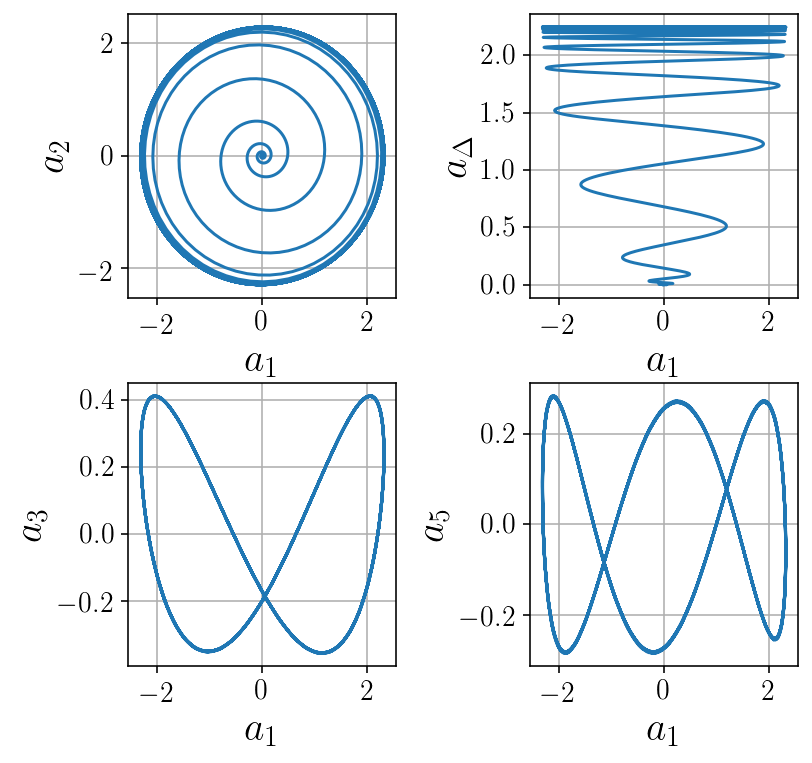

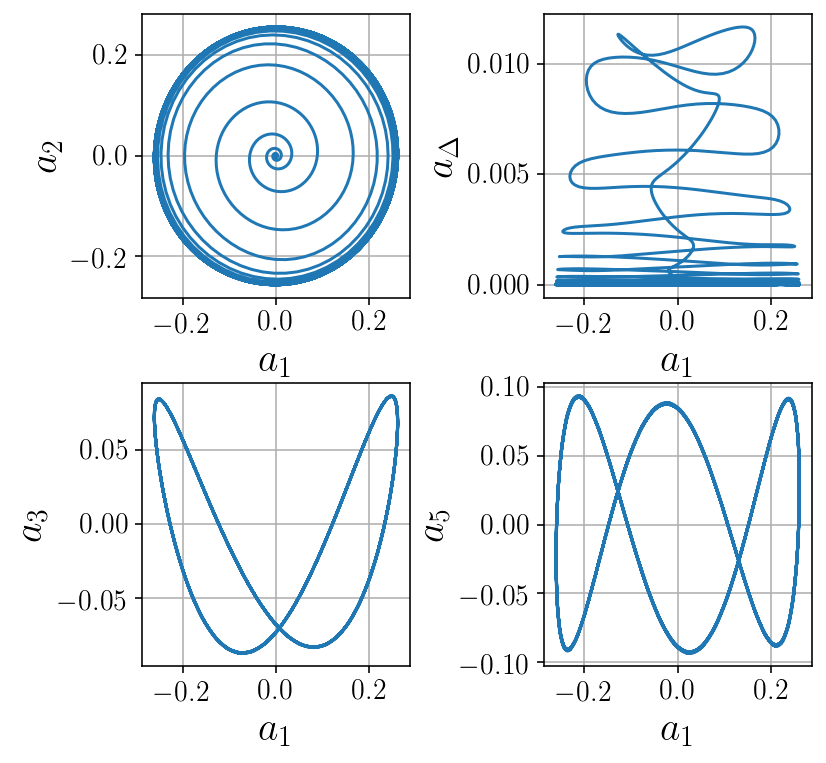

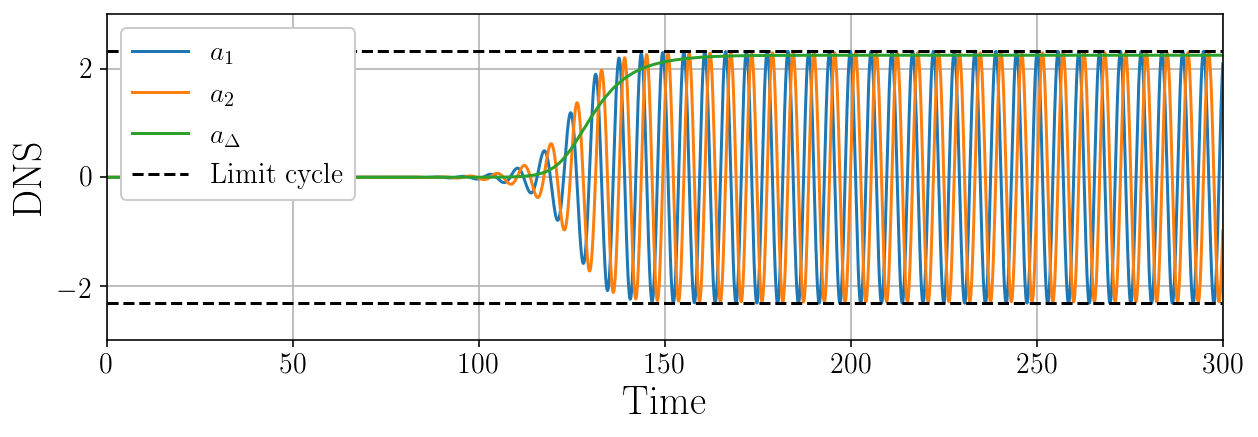

In [2]:
a = np.loadtxt('./a.dat')
t = a[:, 0]
a = a[:, 1:]
a_dot = np.zeros(a.shape)
for i in range(a.shape[1]):
    a_dot[:, i] = np.asarray(np.gradient(a[:, i]))
print(a_dot.shape)
a_max = max(a[:, :2].flatten())

t_steady = 250

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

a_max = max(abs(a[:, 0]))

plt.figure(figsize=(10, 3))
plt.plot(t, a[:, [0, 1, -1]])
plt.plot([t[0], t[-1]], [a_max, a_max], 'k--')
plt.plot([t[0], t[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

#plt.savefig(fig_dir+'deane_model.svg')
plt.show()


### Compare 3-mode (shift-mode) POD-Galerkin model with DNS

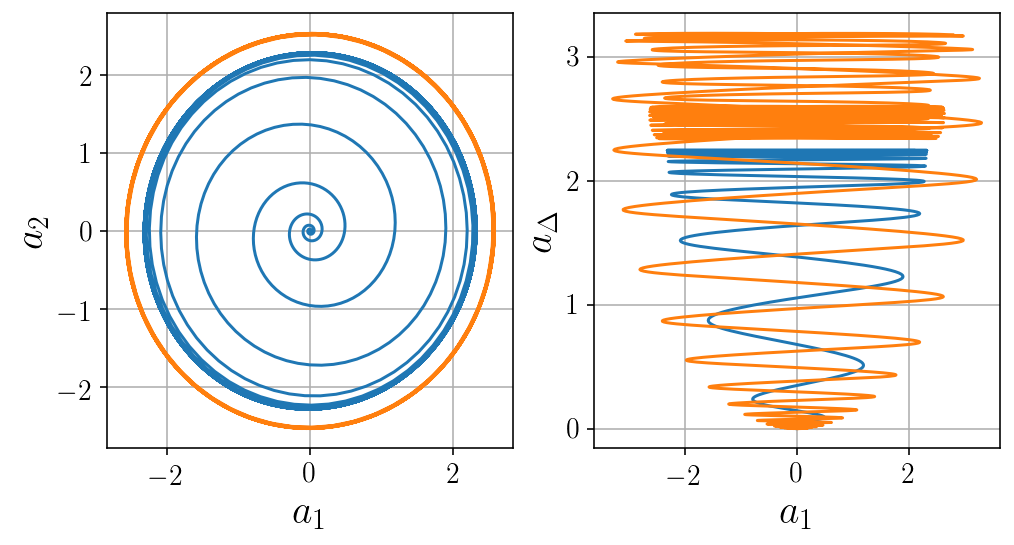

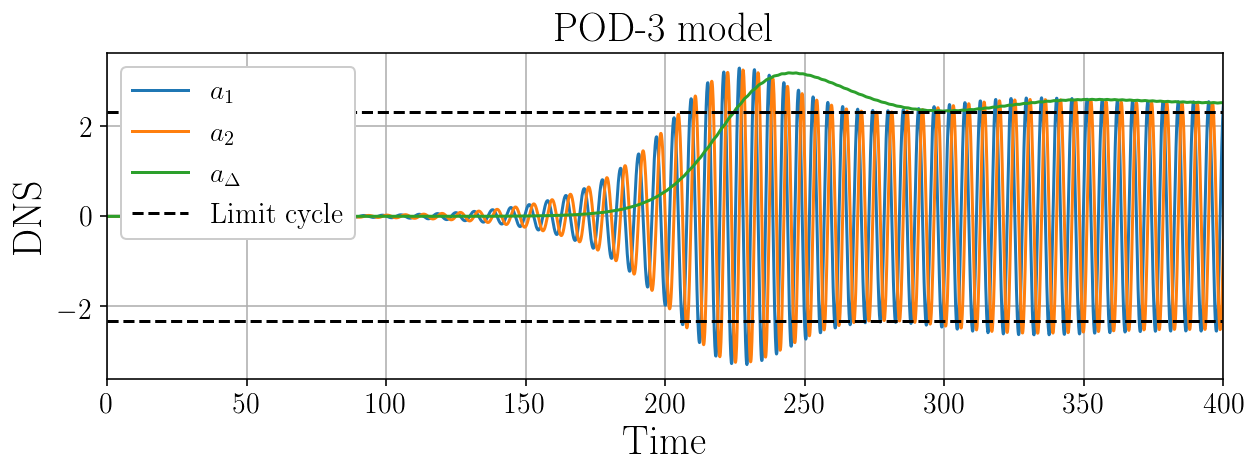

In [3]:
def pg_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

galerkin3 = sio.loadmat('models/galerkin3.mat')
model3 = lambda a, t: pg_model(a, galerkin3['L'], galerkin3['Q'])

galerkin9 = sio.loadmat('models/galerkin9.mat')
model9 = lambda a, t: pg_model(a, galerkin9['L'], galerkin9['Q'])

# Simulate Galerkin models
t_sim = np.arange(0, 500, dt * 10)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

a_galerkin3 = odeint(model3, a0[:3], t_sim)
a_galerkin9 = odeint(model9, a0[:9], t_sim)
# Plot Galerkin-3 results
t_steady_sim = 400

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin3[t_sim>t_steady_sim, 0], a_galerkin3[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(122)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin3[:, 0], a_galerkin3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()
plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-3 model")

plt.show()

### Compare 9-mode (shift-mode) POD-Galerkin model with DNS

[[1.2030129e-07 4.1603837e-08 2.3466293e-09]
 [2.3466293e-09 4.1603837e-08 1.2030129e-07]
 [5.8910005e-02 3.8263455e-03 1.3287652e-04]
 [1.3287652e-04 3.8263455e-03 5.8910005e-02]
 [8.8669622e-04 7.8507870e-01 8.8669622e-04]
 [1.1483223e-05 6.0974548e-07 1.8397255e-07]
 [1.8397255e-07 6.0974548e-07 1.1483223e-05]
 [6.6886016e-04 1.7040549e-04 2.2871853e-05]
 [2.2871853e-05 1.7040549e-04 6.6886016e-04]]


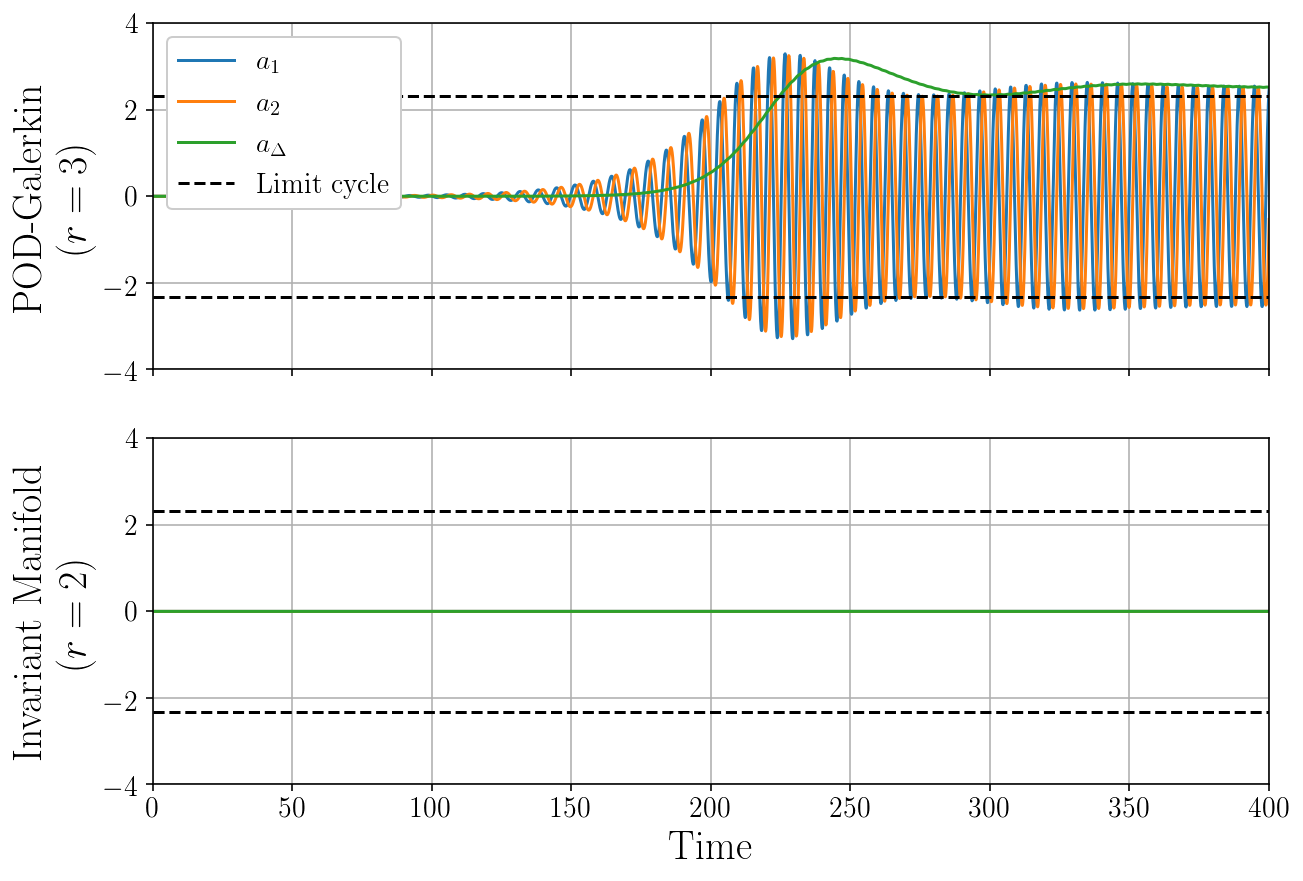

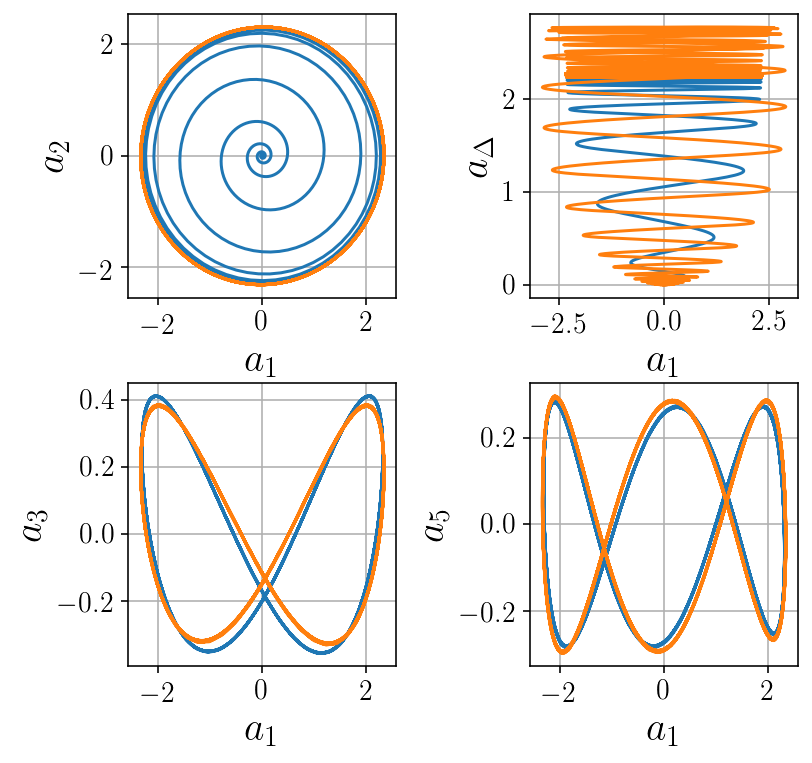

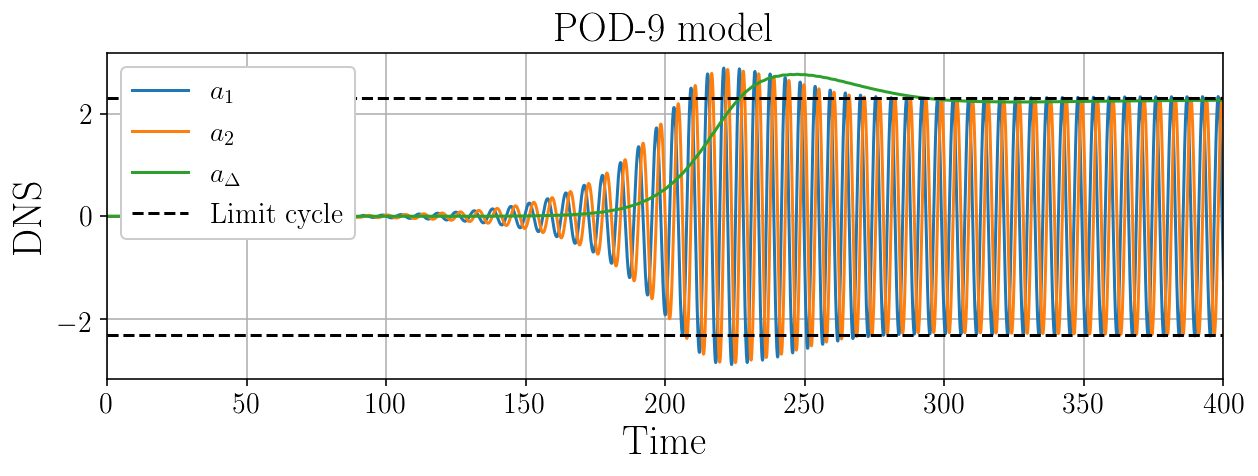

In [4]:
r = 9
L = galerkin9['L']
Q = galerkin9['Q']

# Eigendecomposition of linear part of Galerkin model
evals, Phi = np.linalg.eig(L)

# Order by real part, so unstable evals are first
sort_idx = np.argsort(-np.real(evals))
evals = evals[sort_idx]
Phi = Phi[:, sort_idx]
Phi_inv = np.linalg.inv(Phi)

L_nf = Phi_inv @ L @ Phi
Q_nf = np.einsum('nlm,in,lj,mk->ijk', Q, Phi_inv, Phi, Phi)

model_nf = lambda t, b: pg_model(b, L_nf, Q_nf)

# Don't need to re-center on fixed point since we expanded around the steady state
#  (Otherwise this would be a0 - a_s)
b0 = Phi_inv @ a0[:r]

# Assume that the eigendecomposition actually did
#    diagonalize the upper block of the "normal form"
L11 = 1j*np.imag(L_nf[0, 0])
L22 = 1j*np.imag(L_nf[1, 1])

#L11 = L_nf[0, 0]
#L22 = L_nf[1, 1]

# Build the big matrix for the linear algebra problem
L_mat = np.zeros((3*r, 3*r), dtype='complex64')
L_mat[:r, :r] = 2*L11*np.eye(r) - L_nf
L_mat[r:-r, r:-r] = (L11+L22)*np.eye(r) - L_nf
L_mat[-r:,-r:] = 2*L22*np.eye(r) - L_nf

q_vec = np.zeros((3*r), dtype='complex64')
q_vec[:r] = Q_nf[:, 0, 0]
q_vec[r:-r] = Q_nf[:, 0, 1] + Q_nf[:, 1, 0]
q_vec[-r:] = Q_nf[:, 1, 1]

h_vec = np.linalg.inv(L_mat) @ q_vec
H = np.zeros((r, 3), dtype='complex64')
H[:, 0] = h_vec[:r]
H[:, 1] = h_vec[r:-r]
H[:, 2] = h_vec[-r:]

# Print analytic manifold equation
print(abs(H))

# Create a function for the manifold model (assuming leading two coordinates are driving)
order = 2
def manifold_eq(b, H, order):
    # 2D Polynomial library
    lib = np.array([b[0]**(i-j)*b[1]**j for i in range(2, order+1) for j in range(i+1)])
    b_poly = H @ lib  # Manifold equation
    b_poly[:2] = b[:2]  # Leave active coordinates unchanged
    return b_poly

def dae_model(b, L, Q, H, order):
    # Slave coordinates to the manifold and then evolve with the full model
    b_full = manifold_eq(b, H, order)
    db = pg_model(b_full, L, Q)
    return db[:2]

model = lambda t, b: dae_model(b, L_nf, Q_nf, H, order)

#b0 = Phi_inv @ (a0 - a_s)

b0_manifold = b0[:2]
integrator = complex_ode(model)
integrator.set_initial_value(b0_manifold, 0)

b_manifold = np.zeros((2, len(t_sim)), dtype='complex64')
idx = 0
while integrator.successful() and idx<len(t_sim)-1:
    idx+=1
    integrator.integrate(integrator.t+dt)
    b_manifold[:, idx] = integrator.y

#b_galerkin = odeint(model_nf, b0, t_sim)
b_full = np.zeros((r, len(t_sim)), dtype='complex64')
b_full[:2, :] = b_manifold
for i in range(len(t_sim)):
    b_full[:, i] = manifold_eq(b_manifold[:, i], H, order)  # Recover other variables
    
a_manifold = np.real( Phi @ b_full )

plt.figure(figsize=(10, 7))
plt.subplot(211)
#plt.plot(t_sim, a_galerkin[[0, 1, -1], :].T)
plt.plot(t_sim, a_galerkin3)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.ylabel('POD-Galerkin\n($r=3$)')
plt.grid()

plt.gca().set_xticklabels([])

plt.subplot(212)#plt.plot(t_sim, a_galerkin[[0, 1, -1], :len(t_sim)].T)
plt.plot(t_sim, a_manifold[[0, 1, -1], :].T)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.grid()
plt.ylabel('Invariant Manifold\n($r=2$)')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.xlabel('Time')
plt.show()


# Plot Galerkin-9 results
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin9[:, 0], a_galerkin9[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin9[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-9 model")

plt.show()

In [6]:
## Setup hyperparameters and matrices
r = 9
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor= np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2, lambda ignored: 1]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x, lambda ignored: 1]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

In [7]:
eta = 1.0e20
threshold = 0.0
sindy_opt = ps.epSR3(threshold=threshold, eta=eta, alpha=1e-2, beta=1e-3, gamma=1e-3, vtol=1e-3,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=1000, tol=1e-5,
                            thresholder="inftyball", eigmin=-1e20, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy_test = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy_test[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy_test[:, 1], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy_test = model.predict(a[:, :r], t)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 1], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

NameError: name 'a' is not defined

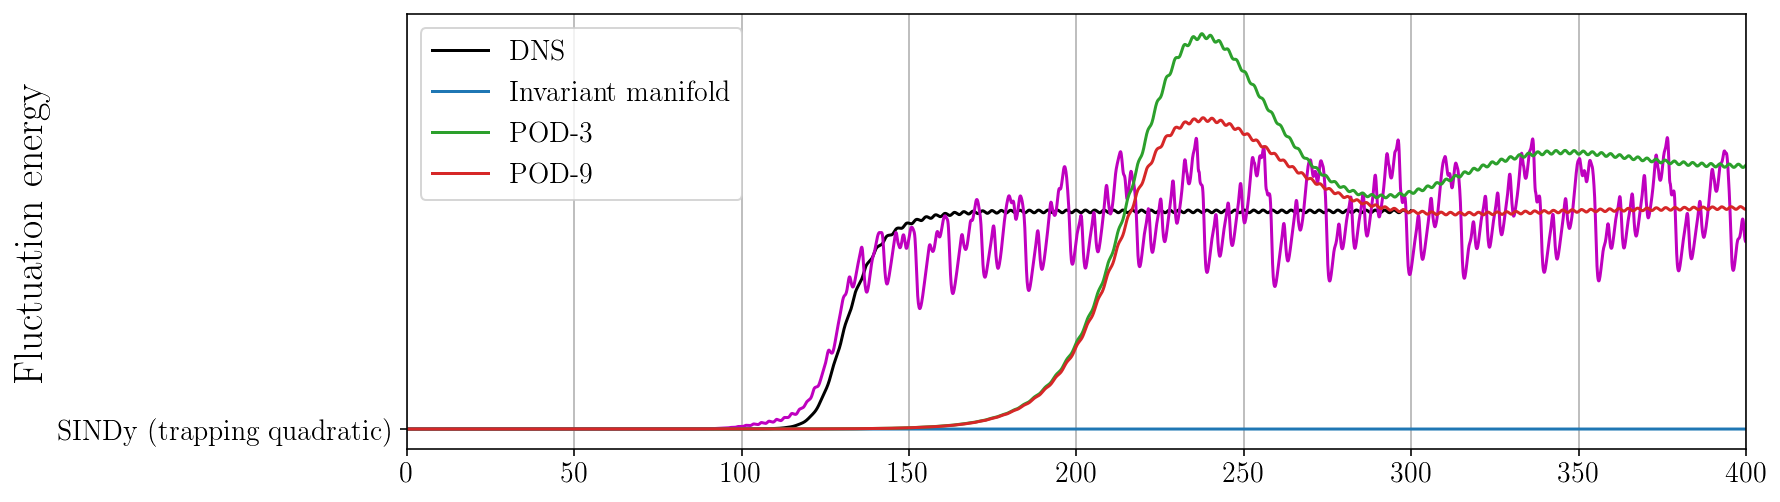

In [7]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
#E_sindy = np.sum(a_sindy**2, axis=1)
#E_sindy2 = np.sum(a_sindy2**2, axis=1)
#E_sindy3 = np.sum(a_sindy3**2, axis=1)
E_test = np.sum(a_sindy_test**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
#plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)')
#plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_test, 'm', r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

In [8]:
print(np.dot(constraint_matrix, Xi.flatten()))
print(np.max(np.dot(constraint_matrix, Xi.flatten())))

[ 4.32009983e-10 -9.72704584e-10  2.91038305e-10  1.44336809e-08
  4.74028639e-09  1.11435838e-09 -3.58559191e-08  1.93431333e-08
 -5.57562885e-10  3.61978891e-10 -4.73721684e-09 -2.70063083e-09
 -3.28782335e-09 -3.73438525e-09  1.24055759e-07  1.24365954e-07
  8.80321371e-11  5.80530468e-09  4.02690148e-09  5.06281594e-09
  6.74162948e-09 -1.98169019e-07 -1.98003704e-07 -6.23563423e-11
  6.30097929e-09  1.31149136e-09  1.33695721e-09 -2.55222403e-08
 -3.29091563e-08 -2.35944242e-09  1.25332917e-08  1.37442839e-08
 -5.53038262e-07 -5.52696292e-07  3.60620334e-09  4.78127760e-09
 -7.75414719e-08 -7.80787559e-08 -3.51008111e-11 -5.41628538e-08
 -5.55446604e-08 -2.74404499e-10 -3.58160364e-08 -6.41136921e-10
 -1.80810105e-08 -5.70025804e-10  2.31921149e-10 -2.38287612e-10
 -2.58148702e-09 -2.96677172e-09  2.32466846e-08 -1.04807896e-09
 -3.43334250e-10  7.63975549e-10  3.59250407e-09 -1.44382284e-11
 -1.36370204e-09  1.33786671e-09  2.48149945e-10  2.13581641e-09
  7.75116860e-10  1.43359

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/energypreserving_sr3.py:450: ConvergenceWarning: epSR3._reduce did not converge after 2000 iterations.
  ConvergenceWarning,


x0' = 0.099 x0 + -0.823 x1 + 0.018 x2 + 0.015 x3 + -0.437 x4 + 0.175 x5 + -0.034 x6 + 0.008 x7 + -0.002 x8 + 0.002 x0x1 + -0.129 x0x2 + -0.101 x0x3 + -0.008 x0x4 + -0.001 x0x5 + 0.011 x0x6 + -0.097 x0x7 + -0.032 x0x8 + -0.044 x1x2 + 0.045 x1x3 + -0.005 x1x4 + 0.006 x1x5 + 0.109 x1x6 + 0.016 x1x7 + -0.165 x1x8 + 0.006 x2x3 + 0.615 x2x4 + 0.060 x2x5 + 0.019 x2x6 + 0.052 x2x7 + -0.002 x2x8 + -0.082 x3x4 + 0.639 x3x5 + 0.018 x3x6 + 0.027 x3x7 + -0.003 x3x8 + 0.005 x4x5 + -1.142 x4x6 + -0.759 x4x7 + 0.116 x4x8 + -0.727 x5x6 + 1.141 x5x7 + -0.085 x5x8 + 0.046 x6x7 + 0.015 x6x8 + -0.008 x7x8 + 0.001 x1x1 + -0.033 x2x2 + -0.015 x3x3 + 0.023 x4x4 + -0.009 x5x5 + -0.026 x6x6 + -0.004 x7x7
x1' = 0.822 x0 + 0.127 x1 + -0.006 x3 + 0.223 x4 + 0.550 x5 + 0.017 x6 + -0.005 x7 + 0.004 x8 + -0.001 x0x1 + -0.131 x0x2 + -0.022 x0x3 + -0.005 x0x4 + 0.004 x0x5 + 0.146 x0x6 + -0.018 x0x7 + 0.135 x0x8 + -0.124 x1x2 + 0.077 x1x3 + 0.002 x1x5 + 0.044 x1x6 + 0.168 x1x7 + -0.068 x1x8 + -0.017 x2x3 + -0.083 x2x4 +

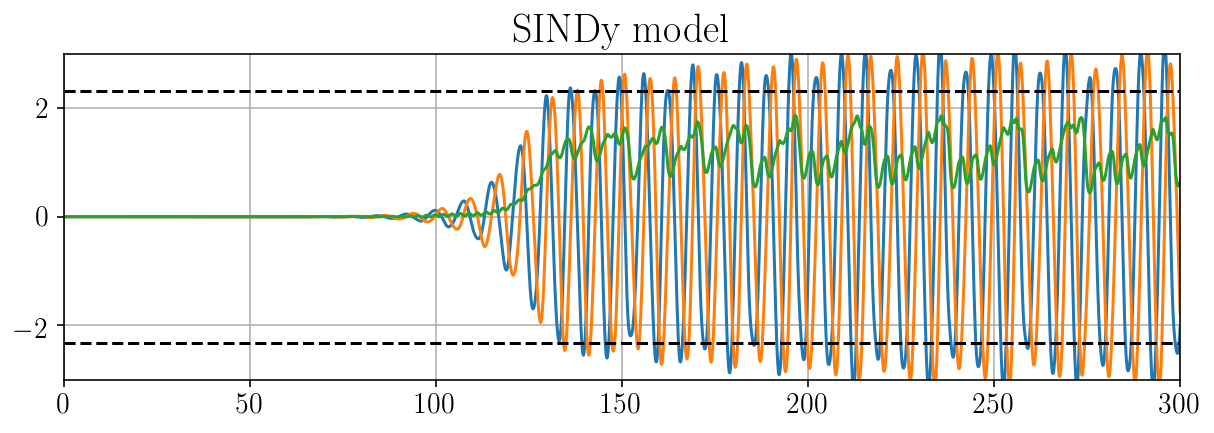

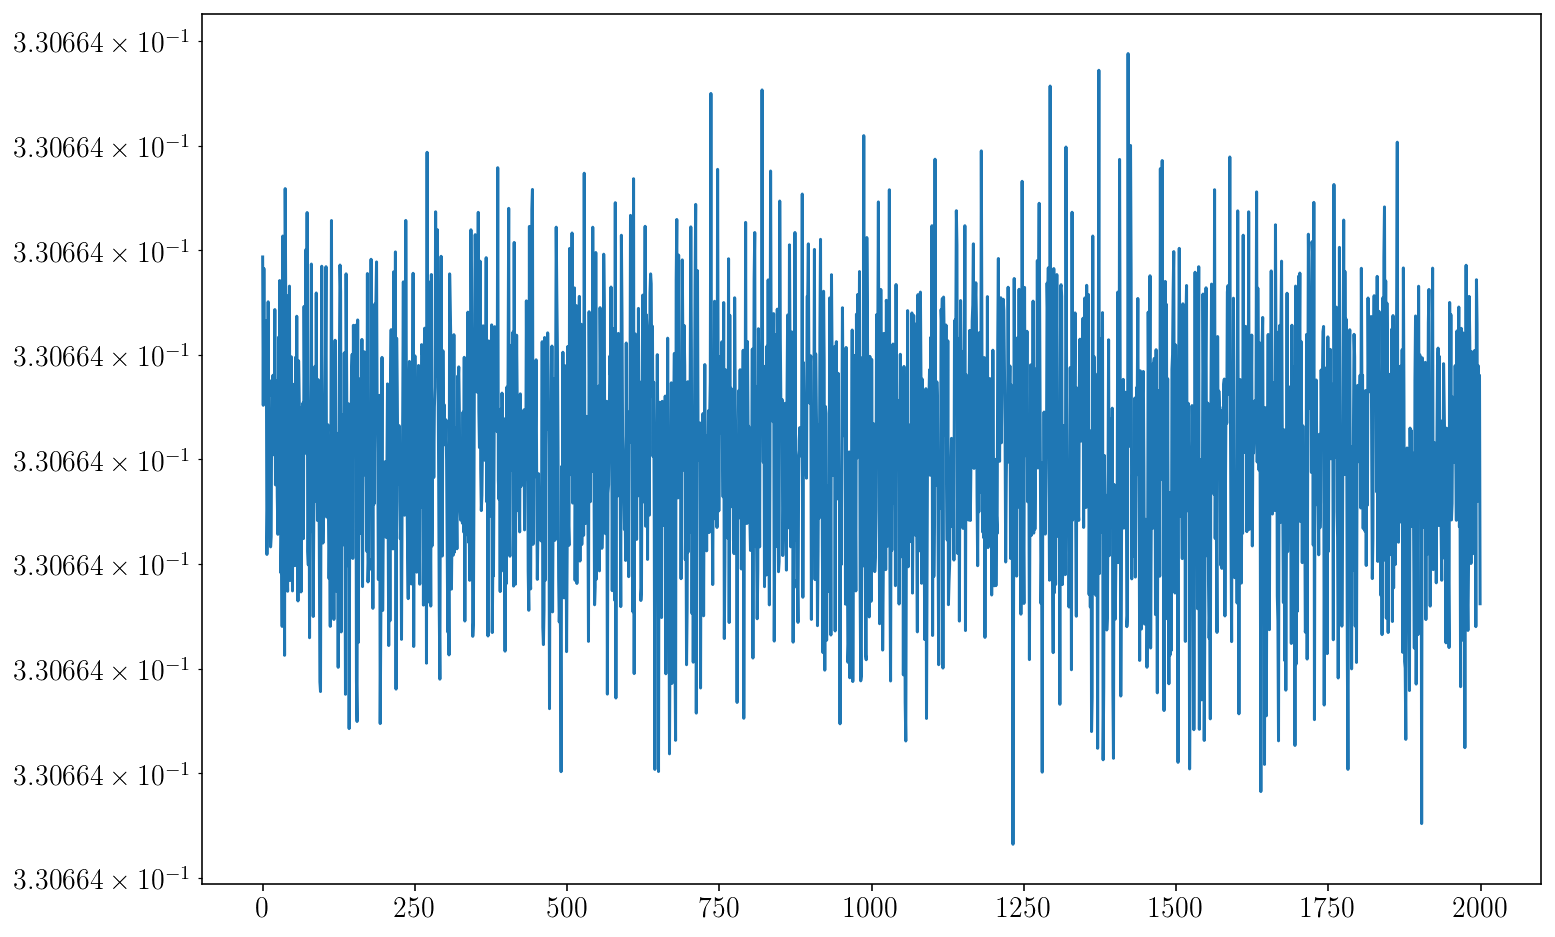

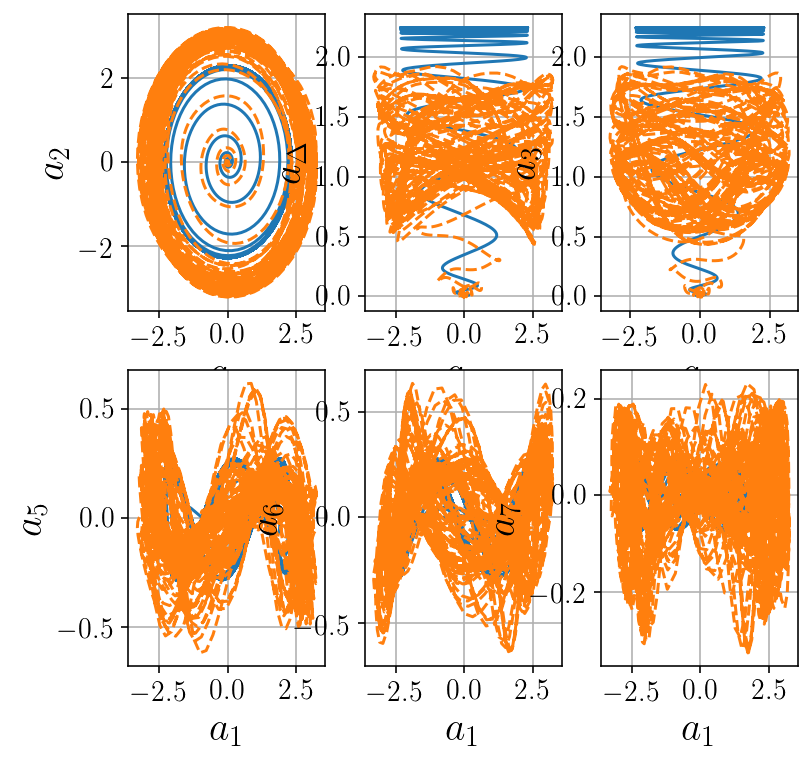

/media/akaptano/HITSI-Work/pysindy/pysindy/pysindy.py:339: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  "Control variables u were ignored because control variables were"


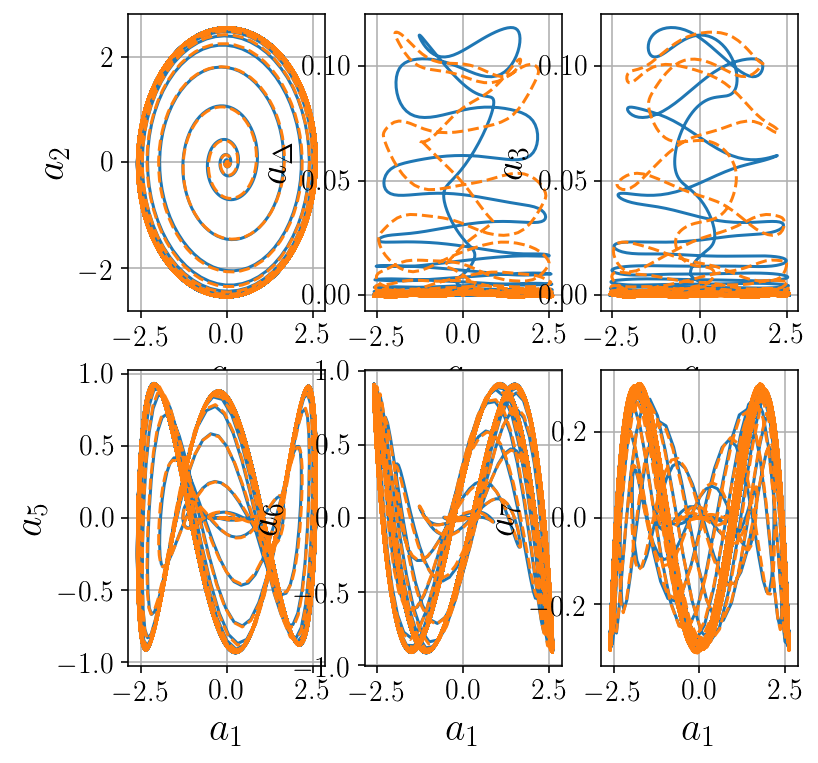

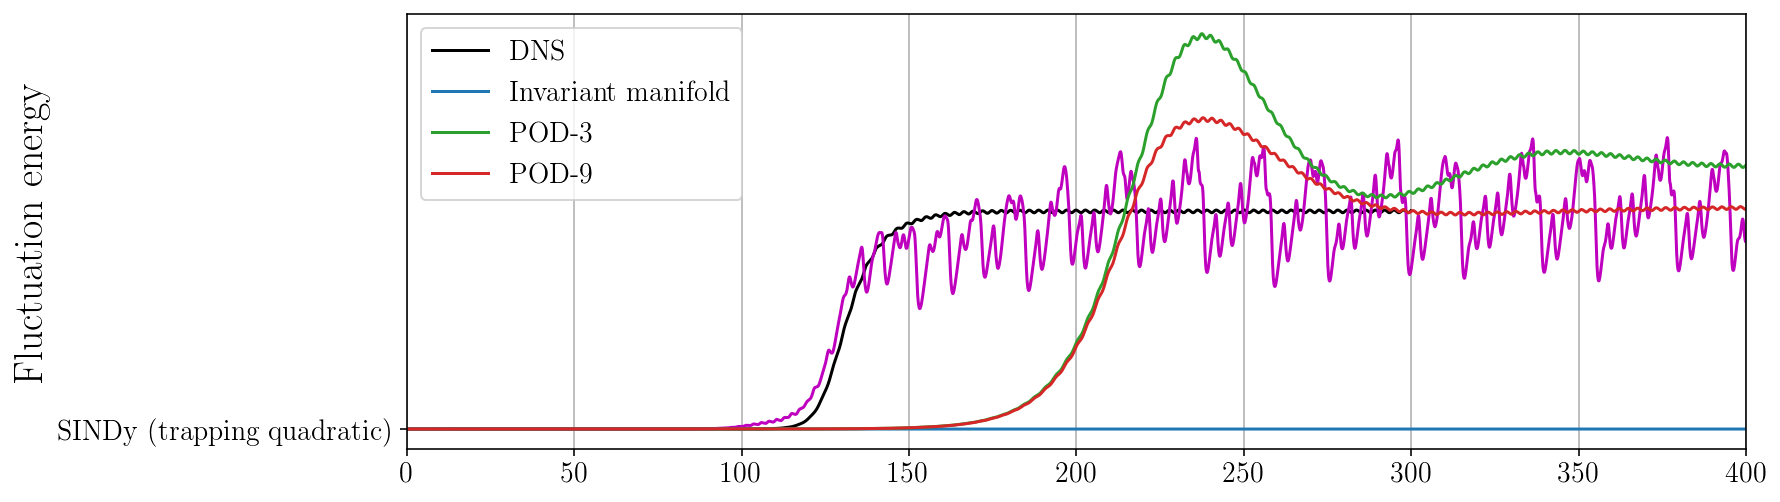

In [9]:
eta = 1.0e20
threshold = 0.0
sindy_opt = ps.epSR3(threshold=threshold, eta=eta, alpha=1e-2, beta=1e-3, gamma=1e-3, vtol=1e-4,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=2000, tol=1e-10,
                            thresholder="inftyball", eigmin=-1e20, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy_test = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy_test[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy_test[:, 1], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy_test = model.predict(a[:, :r], t)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 1], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
#E_sindy = np.sum(a_sindy**2, axis=1)
#E_sindy2 = np.sum(a_sindy2**2, axis=1)
#E_sindy3 = np.sum(a_sindy3**2, axis=1)
E_test = np.sum(a_sindy_test**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
#plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)')
#plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_test, 'm', r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

0.008215379440747466 6.540954059104817e-06 1.2575361065236966e-05
0.6613358430399621 0.0008124503733218944 3.132424292268769e-05
0.6613358569445644 0.0007639826026910637 3.132222487953477e-05
0.6613358721559603 0.0007338729716166013 3.132073373864443e-05
0.6613358683626014 0.0007144525019275851 3.1319831978135686e-05
0.6613358476360935 0.0007014688602402555 3.131944546161908e-05
0.6613358059457943 0.0006924977993368989 3.131945976944384e-05
0.6613357549967713 0.0006861132227255255 3.131976899890077e-05
0.6613356924327325 0.0006814477170446734 3.1320286776380656e-05
0.6613356259031531 0.0006779555925519896 3.132094186988249e-05
0.6613355561297194 0.0006752825298229988 3.132169198372765e-05
0.6613354845099795 0.0006731916892970227 3.132249596951334e-05
0.6613354154852246 0.0006715209384075572 3.132333480613126e-05
0.661335344467675 0.000670156928514524 3.132418947525498e-05
0.6613352754106712 0.000669019195291002 3.132504980586683e-05
0.661335208658831 0.0006680498680526765 3.13259100963

0.6613322107421182 0.0006366449007084716 3.137263051369138e-05
0.6613322034241572 0.0006365052001348986 3.13727620634023e-05
0.6613321949813562 0.0006363664347534806 3.137289105021587e-05
0.6613321875597038 0.000636228592535674 3.137301639404593e-05
0.6613321811399288 0.0006360916552469335 3.137313980972066e-05
0.6613321742860023 0.0006359556325809941 3.1373262207706955e-05
0.6613321655546752 0.000635820502805062 3.137338027391125e-05
0.6613321583663238 0.0006356862498021671 3.137349768396825e-05
0.6613321517172095 0.00063555285540596 3.1373612308534496e-05
0.6613321458889609 0.0006354203075982473 3.137372377224748e-05
0.6613321379934101 0.0006352886213039026 3.137383329255905e-05
0.6613321317754659 0.0006351577482575641 3.1373941271859446e-05
0.6613321247356777 0.0006350276938016175 3.137404690139654e-05
0.6613321179177577 0.0006348984503461315 3.1374149982251846e-05
0.6613321140993776 0.0006347699969677361 3.1374250607214723e-05
0.6613321065037872 0.0006346423407622546 3.137435038062

0.6613318694173712 0.0006232996468951843 3.137663471999946e-05
0.6613318707820187 0.0006232214844035997 3.137660624342528e-05
0.6613318713868489 0.0006231435442596795 3.137657628781083e-05
0.6613318724328573 0.0006230658259167264 3.137654663705007e-05
0.6613318730944336 0.00062298830973903 3.137651409609835e-05
0.6613318729564738 0.0006229110254032616 3.1376484087075736e-05
0.6613318736347361 0.0006228339705133587 3.1376451208393964e-05
0.661331873989849 0.0006227571093574457 3.137641879445365e-05
0.6613318748726748 0.0006226804507848564 3.137638624512226e-05
0.6613318758868052 0.0006226040456304951 3.137635445369649e-05
0.6613318759091279 0.0006225278049261067 3.137631970221428e-05
0.6613318767564552 0.0006224518088228154 3.137628496647515e-05
0.6613318788909249 0.000622375987065702 3.1376251368234664e-05
0.6613318784005313 0.000622300387665573 3.137621662405896e-05
0.6613318792302697 0.0006222250042598258 3.137618136417524e-05
0.6613318804263394 0.0006221498192341312 3.13761447192281

0.6613320846536467 0.0006144969133811302 3.1370134165702006e-05
0.6613320876519889 0.0006144382599635144 3.137007286423265e-05
0.6613320898232015 0.0006143797054750849 3.137001020117807e-05
0.6613320918602896 0.0006143212429370299 3.1369948540811994e-05
0.6613320939646938 0.0006142628908158037 3.1369887121834255e-05
0.6613320965042658 0.0006142046098828742 3.1369824445085034e-05
0.6613320993685955 0.0006141464561937667 3.136976207966226e-05
0.6613321021449485 0.0006140884031553109 3.136969919800397e-05
0.6613321042196109 0.0006140304421903761 3.1369637522816125e-05
0.661332106928059 0.0006139725768530214 3.136957521978e-05
0.6613321089312475 0.000613914808107044 3.1369512207894335e-05
0.6613321112659469 0.0006138571386919559 3.136944899080392e-05
0.661332114452863 0.000613799547973991 3.1369386531478866e-05
0.6613321169794821 0.000613742078132753 3.136932405147223e-05
0.6613321190995374 0.0006136846869860634 3.136926149897735e-05
0.6613321220790754 0.0006136274030771776 3.1369198462506

0.6613324493723137 0.0006074931983562276 3.1361516010195625e-05
0.6613324522250891 0.0006074450054111277 3.136144906216675e-05
0.6613324553767459 0.0006073968763206901 3.1361382739657066e-05
0.6613324584660226 0.0006073488086558988 3.136131557750619e-05
0.6613324610891823 0.0006073008143494237 3.136124867715501e-05
0.6613324642302361 0.0006072528700631663 3.13611818673772e-05
0.661332467587454 0.000607204986458155 3.136111519880275e-05
0.6613324702520064 0.0006071571742726674 3.136104820939419e-05
0.6613324734462392 0.0006071094245392905 3.1360981373829726e-05
0.6613324763555953 0.0006070617305771975 3.136091511801985e-05
0.6613324794245644 0.0006070140959840281 3.136084830980676e-05
0.6613324828309386 0.0006069665306291556 3.1360780699178825e-05
0.661332485855912 0.0006069190092997177 3.13607145953879e-05
0.6613324883402918 0.0006068715725944405 3.136064753671033e-05
0.66133249177532 0.0006068241848744326 3.136058095529547e-05
0.6613324945589655 0.0006067768615557492 3.136051456103658

0.6613328606058277 0.0006016621222069823 3.135284132598532e-05
0.6613328638032552 0.0006016209686562194 3.1352775961902054e-05
0.6613328668321531 0.0006015798695915744 3.1352711137084414e-05
0.6613328700724385 0.0006015388090415421 3.1352646140754644e-05
0.661332873358949 0.0006014977963229054 3.135258107384654e-05
0.6613328769390687 0.0006014568393802807 3.1352516212646434e-05
0.6613328795789206 0.0006014159084871874 3.135245066895449e-05
0.6613328834866665 0.000601375029220087 3.135238634475336e-05
0.6613328867578149 0.0006013342030760324 3.135232155545764e-05
0.6613328901370652 0.0006012934191225173 3.1352255937028746e-05
0.6613328922684504 0.0006012526852104437 3.135219164845665e-05
0.6613328962080777 0.0006012119831748194 3.135212650197908e-05
0.6613328990822296 0.0006011713372137441 3.135206184004477e-05
0.6613329030565297 0.0006011307364394449 3.135199702402865e-05
0.6613329055181185 0.0006010901810273642 3.135193228489863e-05
0.6613329087227575 0.0006010496629370998 3.135186673

0.6613332869282458 0.0005966671593690527 3.1344586302323684e-05
0.6613332902638204 0.0005966312943275652 3.134452432607115e-05
0.6613332932941562 0.0005965954505819836 3.134446244045187e-05
0.6613332964007691 0.0005965596515452515 3.134440100474388e-05
0.6613333006149894 0.0005965238861687618 3.134433933490036e-05
0.6613333032310338 0.0005964881441334357 3.134427773266781e-05
0.6613333066333468 0.0005964524643094232 3.134421650983099e-05
0.6613333108261032 0.0005964167912033196 3.134415441378434e-05
0.6613333136269911 0.0005963811707187576 3.1344093515769276e-05
0.6613333173130574 0.000596345586539273 3.1344032170391e-05
0.6613333201920178 0.0005963100297752317 3.134397052964339e-05
0.6613333222047258 0.0005962745162275143 3.134390964047884e-05
0.6613333260210047 0.0005962390292657126 3.134384841391079e-05
0.6613333301849739 0.0005962035823090687 3.134378660100783e-05
0.661333333980939 0.0005961681760223698 3.134372504395448e-05
0.6613333365228459 0.0005961327888869686 3.13436644640978

424 : threshold not satisfying optimality, reduce the value
0.6613336970062047 0.0005925061428475292 3.133720883911387e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337003069147 0.0005924742468566658 3.133714940914358e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337039627037 0.0005924424061620557 3.133709154624714e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337072024524 0.00059241058553431 3.133703336274628e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337108528524 0.0005923787928560196 3.133697445286464e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337143788232 0.0005923470152176006 3.1336915894804144e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337177642669 0.000592315280722247 3.133685777673211e-05
424 : threshold not satisfying optimality, reduce the value
0.6613337211021283 0.0005922835692974326 3.1336799108984496e-05
424 : threshold n

0.6613339217568402 0.0005904324948173181 3.133335535828957e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339260127442 0.0005904024758058929 3.133329825682823e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339281548639 0.0005903724899538344 3.133324220836881e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339326841713 0.0005903425214027831 3.133318611727738e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339352550175 0.0005903125836973758 3.133312916373494e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339383389445 0.0005902826711951895 3.133307284663107e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339428556525 0.0005902527827007919 3.1333016327971086e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339451755786 0.0005902229299453035 3.133296057769964e-05
424 : threshold not satisfying optimality, reduce the value
0.6613339477741

0.6613341744812784 0.0005882520683945885 3.132918460689888e-05
0.6613341778733884 0.0005882239341553714 3.132912929807021e-05
0.6613341802581131 0.0005881958225440791 3.132907494175385e-05
0.6613341834274218 0.0005881677370909317 3.132902076091321e-05
0.6613341873794149 0.0005881396767612145 3.132896596492576e-05
0.6613341903671414 0.0005881116366905935 3.132891191603748e-05
0.6613341944027522 0.0005880836186632559 3.1328857174386133e-05
0.661334197349618 0.0005880556249872246 3.13288022520547e-05
0.661334200011026 0.0005880276646046419 3.132874846777688e-05
0.6613342042731009 0.0005879997128080608 3.132869319291719e-05
0.6613342071624482 0.0005879717961812551 3.132863908093899e-05
0.6613342115294601 0.0005879439036474566 3.1328584502248084e-05
0.6613342136994965 0.0005879160292217532 3.1328530321567844e-05
0.6613342175895542 0.0005878881800856623 3.1328476037931976e-05
0.6613342207366113 0.0005878603497022884 3.132842192744145e-05
0.6613342251914097 0.0005878325481440833 3.13283670858

0.6613346178938544 0.0005847326239757971 3.1322180907518427e-05
0.661334620314726 0.0005847073717015189 3.1322129646954294e-05
0.6613346244005128 0.0005846821381437995 3.1322078255375415e-05
0.661334627369704 0.0005846569296048301 3.132202686359963e-05
0.6613346315817272 0.000584631734115135 3.132197529331081e-05
0.661334633750529 0.0005846065621665268 3.132192443062927e-05
0.6613346372722824 0.0005845814038642223 3.132187263231823e-05
0.6613346408902243 0.0005845562758328705 3.1321821481536075e-05
0.6613346434460261 0.0005845311627101059 3.132177005995997e-05
0.6613346467703745 0.0005845060660035033 3.132171900435037e-05
0.6613346507431155 0.0005844809920820906 3.132166767181619e-05
0.661334654960699 0.0005844559345499936 3.1321615578864304e-05
0.6613346575612508 0.0005844309017689754 3.132156453634956e-05
0.6613346605625782 0.0005844058844091908 3.132151347454216e-05
0.6613346642435531 0.0005843808980448235 3.1321462858764277e-05
0.6613346669062306 0.0005843559129725489 3.13214109326

0.6613350664521601 0.0005815174020045523 3.131547897673026e-05
0.6613350686064084 0.0005814946137184663 3.1315430045072646e-05
0.6613350726911922 0.0005814718467742455 3.131538160707586e-05
0.6613350761067716 0.0005814490891556292 3.1315333177207775e-05
0.6613350784668328 0.0005814263624620432 3.131528516551081e-05
0.661335083268202 0.000581403644395843 3.131523623355444e-05
0.6613350861430294 0.0005813809458664486 3.131518816867697e-05
0.6613350885914456 0.0005813582633189758 3.131513927565958e-05
0.6613350937052074 0.0005813355914187275 3.131509116085348e-05
0.661335096306867 0.0005813129495633539 3.131504243625803e-05
0.6613351002312401 0.0005812903168465969 3.131499364323723e-05
0.6613351028987104 0.0005812677012678489 3.131494604662031e-05
0.6613351061495858 0.0005812451034384097 3.131489729192267e-05
0.6613351101853986 0.0005812225139215782 3.131484898564657e-05
0.6613351140712943 0.000581199953962103 3.1314801295244226e-05
0.6613351163200815 0.0005811774048762706 3.1314752485475

0.6613354990152647 0.0005786908912156833 3.1309333210848305e-05
0.661335501838086 0.000578670152511434 3.13092868508926e-05
0.6613355063295526 0.000578649437318787 3.130924074145989e-05
0.6613355093543245 0.0005786287438477423 3.130919582323471e-05
0.6613355133636286 0.0005786080391872537 3.130914847329804e-05
0.6613355163762151 0.0005785873632160322 3.130910317190021e-05
0.6613355187313333 0.0005785667042814416 3.130905698025947e-05
0.6613355233857199 0.0005785460560751928 3.1309011137939205e-05
0.6613355252011123 0.0005785254215106266 3.1308964980711276e-05
0.6613355296835376 0.0005785048013561806 3.130891947827113e-05
0.661335532032138 0.0005784842004131172 3.130887299511174e-05
0.6613355362166249 0.0005784636135164116 3.1308828182208636e-05
0.6613355382349295 0.0005784430315195407 3.1308781604574003e-05
0.6613355437159553 0.0005784224700067514 3.1308736350940006e-05
0.6613355447485064 0.0005784019288960819 3.1308690503091085e-05
0.6613355485338448 0.0005783813920252536 3.1308644435

0.661335936052097 0.0005760745939802127 3.130341819911186e-05
0.6613359395523845 0.0005760556613416676 3.130337378928361e-05
0.661335943279154 0.0005760367407259708 3.1303330503969734e-05
0.6613359462073 0.0005760178306285287 3.130328735012162e-05
0.6613359502643565 0.0005759989367101796 3.13032432887047e-05
0.6613359523622196 0.0005759800513158974 3.1303200174864106e-05
0.6613359572968034 0.0005759611848256158 3.13031562255004e-05
0.6613359602577058 0.0005759423186372713 3.130311325474668e-05
0.661335962544258 0.000575923472154162 3.130306967509432e-05
0.6613359667785024 0.000575904644843358 3.1303025333310484e-05
0.6613359699205451 0.0005758858232623661 3.1302982004953204e-05
0.6613359737787594 0.0005758670153400376 3.1302938321854514e-05
0.6613359766301894 0.000575848217632735 3.130289508689806e-05
0.6613359786502213 0.0005758294345683983 3.130285207005473e-05
0.66133598221345 0.0005758106693242715 3.130280902143203e-05
0.661335987124268 0.0005757919075497156 3.130276528385745e-05
0

0.661336369998372 0.0005736803917933291 3.129780152960889e-05
0.6613363743699633 0.0005736630259825702 3.129775987128461e-05
0.661336376099616 0.0005736456798901122 3.129771866929193e-05
0.6613363788824261 0.0005736283356935917 3.129767685823335e-05
0.6613363834206597 0.0005736110022791969 3.1297635158659326e-05
0.661336385615865 0.0005735936856614321 3.129759455947318e-05
0.6613363894723328 0.0005735763776139247 3.129755256265762e-05
0.6613363932234567 0.0005735590751796337 3.129751143239582e-05
0.6613363958442772 0.0005735417858195584 3.129746996072666e-05
0.6613363990951383 0.0005735245115331955 3.129742814820092e-05
0.6613364022225324 0.0005735072466782612 3.129738723057677e-05
0.6613364069531159 0.0005734899971210385 3.1297346709727275e-05
0.6613364087595189 0.000573472755070519 3.129730533347828e-05
0.6613364121353803 0.0005734555208966678 3.129726299056408e-05
0.6613364154904352 0.0005734382976501776 3.129722202132701e-05
0.6613364191574744 0.000573421090787576 3.129718087423944

0.6613367969040582 0.0005714965844051152 3.129249605192033e-05
0.6613367998999433 0.0005714805887628683 3.129245717565301e-05
0.6613368037515376 0.0005714646052828823 3.129241716949552e-05
0.661336805993752 0.0005714486296456834 3.129237739966497e-05
0.6613368095149227 0.0005714326644259651 3.1292338311388924e-05
0.6613368123112835 0.0005714167159563771 3.1292298577551834e-05
0.6613368161654528 0.0005714007655162734 3.129225934000402e-05
0.6613368194770713 0.0005713848276835166 3.129221974475544e-05
0.6613368216782965 0.0005713689027014279 3.129218012871406e-05
0.6613368258048425 0.0005713529853621598 3.129214131220914e-05
0.6613368284192425 0.0005713370777231907 3.1292101998366924e-05
0.6613368323077833 0.000571321184261215 3.1292062124932726e-05
0.6613368352088977 0.0005713052972779823 3.1292022580536824e-05
0.6613368377512053 0.0005712894208230971 3.129198318729211e-05
0.6613368416723636 0.0005712735529227579 3.129194377263401e-05
0.661336845287909 0.0005712576972905041 3.1291904795

0.6613372221655933 0.0005694669320772352 3.128739740382526e-05
0.661337225699174 0.0005694521581220121 3.128735972663456e-05
0.6613372287373537 0.0005694373953207394 3.128732143415541e-05
0.6613372311742236 0.0005694226402959735 3.1287284143240865e-05
0.6613372337699909 0.0005694078949876275 3.128724698178503e-05
0.6613372382601345 0.0005693931584479179 3.128720873626843e-05
0.6613372417489852 0.0005693784242049128 3.1287171317143327e-05
0.6613372445304891 0.0005693637043201034 3.128713347011643e-05
0.661337247412461 0.0005693489927675911 3.128709556875384e-05
0.6613372506571765 0.0005693342862100876 3.128705840377998e-05
0.6613372541646411 0.0005693195945970384 3.128702056179125e-05
0.6613372565132474 0.0005693049114837063 3.128698306497142e-05
0.6613372607595337 0.0005692902307640205 3.1286945340323964e-05
0.6613372641906355 0.0005692755625571901 3.128690773635223e-05
0.6613372670589958 0.0005692608990160589 3.128687047546155e-05
0.6613372701327416 0.0005692462500579368 3.12868323177

0.6613376440859102 0.0005675894470548628 3.128252564180285e-05
0.6613376473221593 0.0005675757616158864 3.1282489483264166e-05
0.6613376497316771 0.0005675620840226363 3.1282453554421217e-05
0.6613376524424741 0.0005675484187137808 3.128241814136468e-05
0.6613376561374493 0.0005675347489584307 3.128238163541367e-05
0.661337658655734 0.0005675210941956277 3.1282345472995504e-05
0.6613376621955158 0.0005675074468840595 3.1282309281613994e-05
0.6613376651923766 0.0005674938087717518 3.128227404369551e-05
0.6613376684143465 0.000567480173989996 3.128223693716833e-05
0.661337672476943 0.0005674665561891151 3.128220225459524e-05
0.6613376752407479 0.0005674529395633892 3.1282165808185625e-05
0.6613376782017849 0.0005674393272531934 3.128212959703723e-05
0.6613376813366485 0.0005674257263844053 3.128209377277776e-05
0.6613376846311032 0.0005674121342428748 3.1282057685160464e-05
0.6613376878788574 0.00056739854428098 3.128202123740672e-05
0.6613376912315494 0.0005673849672843583 3.12819856449

0.6613380561577425 0.000565860435576523 3.1277898141806714e-05
0.6613380592637972 0.0005658477222639312 3.12778641902139e-05
0.6613380627358348 0.0005658349950520053 3.127782817603777e-05
0.661338065568773 0.0005658222900939879 3.127779377694126e-05
0.6613380696973018 0.0005658096029970313 3.1277761160430175e-05
0.6613380725212105 0.0005657968941674221 3.1277724545571834e-05
0.661338075407261 0.0005657842106634617 3.1277690729795476e-05
0.6613380788567017 0.0005657715316595469 3.1277655665064816e-05
0.6613380811801246 0.0005657588618929744 3.12776213949631e-05
0.6613380855999788 0.000565746183429598 3.127758590669737e-05
0.6613380884977911 0.0005657335310463868 3.127755190722794e-05
0.6613380904815768 0.0005657208879338458 3.127751834396078e-05
0.6613380944898178 0.0005657082423959507 3.127748415409655e-05
0.6613380972207299 0.000565695597778259 3.127744842695755e-05
0.6613381004120246 0.0005656829641229639 3.127741389967598e-05
0.6613381026470746 0.0005656703539153425 3.12773804458662

0.6613384658835455 0.0005642513775971156 3.1273459101029624e-05
0.661338468574344 0.0005642395321792671 3.127342633877952e-05
0.6613384720713555 0.0005642276728324614 3.127339141559765e-05
0.6613384745794559 0.0005642158361106161 3.127335874077476e-05
0.66133847819569 0.0005642040027266826 3.1273326075591824e-05
0.6613384810605872 0.0005641921678790756 3.127329122720912e-05
0.6613384832247091 0.0005641803560591843 3.127325984400303e-05
0.661338488291218 0.000564168532899773 3.1273225099438645e-05
0.6613384904927195 0.0005641567367387067 3.127319389116108e-05
0.6613384931078613 0.0005641449261868415 3.127316022369821e-05
0.6613384967725453 0.00056413312525775 3.127312674505909e-05
0.6613384992321265 0.0005641213517419794 3.1273095202176705e-05
0.661338503255933 0.0005641095560413225 3.127306098362534e-05
0.6613385058391561 0.000564097786158742 3.1273029426703455e-05
0.6613385100917696 0.000564085998166592 3.127299273684746e-05
0.6613385119390418 0.0005640742455031206 3.12729622848213e-0

0.6613388727533573 0.0005627393792366835 3.126916242629718e-05
0.6613388755987633 0.0005627283207615461 3.126913197901568e-05
0.661338879941982 0.0005627172563062972 3.126909963577285e-05
0.6613388825293758 0.0005627062065107306 3.126906810518673e-05
0.6613388852046457 0.0005626951628459053 3.126903548823751e-05
0.6613388892887997 0.0005626841137045368 3.126900359378828e-05
0.6613388922036331 0.0005626730783882797 3.12689717547805e-05
0.6613388948020507 0.0005626620524115699 3.126893934889605e-05
0.6613388971243406 0.0005626510321864184 3.126890721264569e-05
0.661338900792733 0.0005626400118333842 3.126887589281071e-05
0.6613389035498707 0.0005626290036274361 3.126884436039153e-05
0.6613389058009881 0.0005626180028829423 3.126881322300495e-05
0.6613389106459616 0.000562606997324951 3.126878174684437e-05
0.6613389120770643 0.0005625960061887494 3.12687493216694e-05
0.6613389165788733 0.0005625850049809243 3.1268716738481926e-05
0.6613389199251924 0.0005625740280281044 3.126868558190864e

0.6613392754023026 0.0005613266538001161 3.1265032372838154e-05
0.6613392781467532 0.0005613163008198414 3.126500081241838e-05
0.6613392816023728 0.0005613059577358698 3.126497007887702e-05
0.6613392848031759 0.0005612956260645145 3.1264940205951245e-05
0.6613392876689226 0.0005612852906987424 3.12649088286341e-05
0.6613392909102748 0.0005612749676317293 3.1264878806354094e-05
0.6613392933745849 0.0005612646423641267 3.126484786955913e-05
0.6613392972532823 0.0005612543280762111 3.1264817537813594e-05
0.6613393000598865 0.0005612440145787999 3.126478684648407e-05
0.6613393021972986 0.0005612337085115507 3.126475634884272e-05
0.6613393056864475 0.0005612234068174667 3.126472553393326e-05
0.661339308982605 0.0005612131108580333 3.126469475725739e-05
0.661339311232116 0.0005612028203188919 3.126466417120659e-05
0.6613393149370125 0.0005611925348810135 3.126463366995553e-05
0.6613393186095267 0.0005611822486450789 3.126460262780854e-05
0.6613393218164898 0.0005611719779192812 3.12645723637

0.6613396744675412 0.0005600040297139823 3.1261054111295114e-05
0.6613396764520738 0.0005599943340719722 3.1261025001588884e-05
0.6613396791513177 0.0005599846421542614 3.126099513192072e-05
0.661339682402865 0.0005599749530652845 3.126096639623601e-05
0.6613396856309425 0.0005599652706362344 3.1260936624878204e-05
0.6613396880352397 0.00055995559025708 3.126090650611334e-05
0.661339690247062 0.0005599459170414998 3.1260877013714264e-05
0.6613396940741394 0.000559936246543569 3.126084733729704e-05
0.6613396976555651 0.0005599265807107586 3.126081798119174e-05
0.6613397002089378 0.0005599169246562766 3.126078855335893e-05
0.6613397027501104 0.0005599072693417426 3.126075925547404e-05
0.6613397062814838 0.0005598976157297541 3.126072943535815e-05
0.6613397098149979 0.0005598879695004321 3.126069946680095e-05
0.6613397119432249 0.000559878331304956 3.1260670472065565e-05
0.6613397154543931 0.000559868699433935 3.1260641214461555e-05
0.6613397180752941 0.0005598590637448273 3.1260611349787

0.6613400721083968 0.0005587452644481896 3.125716284305189e-05
0.661340074679431 0.0005587361684286689 3.125713438072063e-05
0.6613400782732844 0.00055872707984175 3.125710590681311e-05
0.6613400811981733 0.0005587179931054003 3.1257077634810584e-05
0.6613400841251776 0.0005587089115978732 3.125704867345395e-05
0.6613400863832571 0.0005586998337507123 3.1257020675285135e-05
0.6613400899404093 0.0005586907602269962 3.125699209278379e-05
0.6613400927108196 0.0005586816905215792 3.125696386632443e-05
0.6613400954066684 0.0005586726259419542 3.1256935415186404e-05
0.6613400984690888 0.000558663564106012 3.1256906839944723e-05
0.6613401014857898 0.0005586545091583885 3.125687780377957e-05
0.6613401041977415 0.0005586454541725755 3.125684970591009e-05
0.6613401079172206 0.0005586364079913969 3.125682174500045e-05
0.6613401103711658 0.000558627364057342 3.125679243427282e-05
0.6613401127607774 0.0005586183253156215 3.12567640673943e-05
0.6613401160937054 0.0005586092892057199 3.12567360903885

0.6613404598710905 0.0005575807574166983 3.1253464029079024e-05
0.6613404624554928 0.0005575722033161088 3.125343652864091e-05
0.6613404647413875 0.0005575636560673124 3.125340862269262e-05
0.6613404685807514 0.0005575551134629048 3.125338120998714e-05
0.6613404711080304 0.0005575465701469715 3.125335421672695e-05
0.6613404741576423 0.0005575380326688133 3.125332646810267e-05
0.6613404770667788 0.0005575294984635131 3.125329916128413e-05
0.6613404803044238 0.000557520971974019 3.125327125445913e-05
0.6613404824408354 0.0005575124445610772 3.1253243435824925e-05
0.6613404854142108 0.0005575039266859462 3.125321684361786e-05
0.6613404888064908 0.0005574954078144015 3.125318862714996e-05
0.6613404918102227 0.0005574868934376639 3.125316162324314e-05
0.6613404944856297 0.0005574783846137912 3.125313416926572e-05
0.6613404975563534 0.0005574698750601152 3.125310686516533e-05
0.6613405003446581 0.0005574613746807375 3.1253078845563075e-05
0.6613405032867244 0.000557452876775558 3.12530516333

0.6613408425608825 0.0005564848469001714 3.124989034252482e-05
0.6613408456595721 0.0005564767952475867 3.124986433553832e-05
0.6613408481310645 0.0005564687417544131 3.12498381746013e-05
0.661340850691646 0.0005564606969779142 3.12498116665311e-05
0.6613408539535077 0.0005564526481834189 3.1249783781429236e-05
0.6613408566549612 0.0005564446084904815 3.124975741012622e-05
0.6613408596077803 0.0005564365704929406 3.1249731246644446e-05
0.6613408622447424 0.0005564285364436135 3.124970465997477e-05
0.6613408656748643 0.0005564205089165425 3.12496786156241e-05
0.6613408678355382 0.0005564124847702521 3.1249651818421644e-05
0.6613408706001609 0.0005564044576889908 3.1249625086470044e-05
0.6613408737277482 0.0005563964385815145 3.124959818320158e-05
0.661340877163548 0.0005563884252991497 3.124957211003135e-05
0.6613408790872092 0.0005563804115119761 3.1249545057394854e-05
0.6613408824974202 0.0005563724037887746 3.124951831257284e-05
0.6613408854424772 0.0005563643949211245 3.124949219543

0.6613412141381549 0.000555467161240851 3.1246486862088234e-05
0.661341216909824 0.0005554595543619927 3.1246460322072024e-05
0.6613412197980297 0.0005554519553980112 3.124643561748919e-05
0.6613412219256266 0.0005554443613513001 3.124640984928756e-05
0.6613412251856482 0.0005554367661910836 3.124638461071304e-05
0.6613412276752709 0.0005554291753520568 3.12463582582837e-05
0.6613412313488175 0.0005554215885514195 3.1246332762472374e-05
0.6613412341499931 0.0005554140055677088 3.124630665526698e-05
0.6613412363634602 0.0005554064204199879 3.124628055014481e-05
0.6613412393657232 0.0005553988434472579 3.1246255238248646e-05
0.661341242397633 0.0005553912720967304 3.124622970094319e-05
0.6613412446026614 0.0005553836964378839 3.12462032069031e-05
0.6613412482017338 0.0005553761331237649 3.1246178785043924e-05
0.6613412505017265 0.0005553685654435094 3.124615248999359e-05
0.66134125336096 0.0005553610075487062 3.124612699028367e-05
0.6613412565792056 0.0005553534480096196 3.12461013158145

0.6613415803123822 0.0005545058367384648 3.124319134935541e-05
0.6613415838078107 0.0005544986458885446 3.124316608844704e-05
0.6613415862881472 0.0005544914614159384 3.124314116633823e-05
0.6613415886569012 0.0005544842813561792 3.124311638537286e-05
0.6613415912017842 0.0005544771022555505 3.124309130895463e-05
0.6613415941037433 0.0005544699252114395 3.1243066503242683e-05
0.6613415974818998 0.0005544627537169705 3.12430419703807e-05
0.6613416001300148 0.0005544555823893418 3.124301654959613e-05
0.6613416029905992 0.000554448417437651 3.124299206980838e-05
0.6613416057175067 0.0005544412549369471 3.124296672245453e-05
0.6613416083518688 0.0005544340935859949 3.1242941879550235e-05
0.6613416114004226 0.0005544269364949853 3.124291726178585e-05
0.6613416144380165 0.000554419783508784 3.124289236521932e-05
0.6613416164958412 0.0005544126328172422 3.124286751758525e-05
0.6613416194113028 0.0005544054860244669 3.12428433931399e-05
0.6613416225921128 0.0005543983387458708 3.12428173647272

0.6613419479539376 0.0005535829845202348 3.123994955418362e-05
0.6613419504903916 0.0005535761877700813 3.123992556594317e-05
0.6613419531446865 0.0005535693966051236 3.1239901326438165e-05
0.6613419566484519 0.0005535626022341007 3.123987759730683e-05
0.6613419588941052 0.0005535558125691804 3.123985342101196e-05
0.6613419619003481 0.0005535490265087474 3.123982903981991e-05
0.6613419644811871 0.0005535422468802301 3.123980487008681e-05
0.6613419669905763 0.0005535354649039727 3.123978087954974e-05
0.6613419701150607 0.0005535286895968507 3.1239755857483906e-05
0.661341972438595 0.0005535219133187635 3.123973184710098e-05
0.6613419760462408 0.0005535151429902871 3.1239707969701496e-05
0.6613419780257409 0.000553508374492511 3.123968435837064e-05
0.6613419809628384 0.0005535016108911999 3.123965948914748e-05
0.6613419841976125 0.0005534948431365257 3.1239636208641525e-05
0.6613419867242181 0.0005534880875600208 3.1239611805420755e-05
0.6613419889783189 0.0005534813300701838 3.123958810

0.661342309607276 0.0005527097979681835 3.123680838422458e-05
0.6613423131299521 0.0005527033642197945 3.123678476657951e-05
0.6613423157707177 0.0005526969306055435 3.123676108251907e-05
0.6613423181296584 0.0005526905033117474 3.1236737668133083e-05
0.6613423209448092 0.0005526840747197177 3.123671412413131e-05
0.661342323909878 0.0005526776519477013 3.1236690586821795e-05
0.6613423259359451 0.000552671229004937 3.123666698768587e-05
0.6613423294199918 0.000552664808483054 3.123664437873284e-05
0.6613423319397016 0.0005526583939445769 3.123662042311661e-05
0.6613423351324629 0.0005526519817616426 3.123659710579389e-05
0.6613423372727815 0.0005526455683867403 3.123657387034433e-05
0.6613423403453679 0.0005526391588068148 3.123655064479675e-05
0.6613423428627591 0.0005526327520548275 3.12365270902898e-05
0.6613423453917929 0.0005526263489764093 3.123650357795795e-05
0.6613423482431707 0.0005526199505065287 3.12364807644121e-05
0.6613423509482388 0.0005526135502717605 3.1236457071746564

0.6613426640521809 0.0005518887451315403 3.12337837175779e-05
0.6613426674146318 0.0005518826421041281 3.123376096011553e-05
0.6613426697803062 0.0005518765438591496 3.1233738214870164e-05
0.661342672680492 0.0005518704477081983 3.123371593475537e-05
0.6613426754943803 0.0005518643539654065 3.1233692584832364e-05
0.6613426777367237 0.0005518582625949024 3.1233669748086164e-05
0.6613426809163309 0.0005518521735004034 3.12336476021804e-05
0.6613426834783724 0.0005518460850252867 3.123362453153101e-05
0.6613426856970519 0.0005518400005347896 3.123360154034054e-05
0.6613426887834912 0.0005518339166970767 3.1233579314781615e-05
0.6613426916693302 0.0005518278381887455 3.123355657159011e-05
0.6613426939750476 0.0005518217605922996 3.123353377043055e-05
0.6613426967158477 0.000551815687464334 3.1233511109898685e-05
0.6613426992110935 0.0005518096143148411 3.123348884532654e-05
0.6613427021266657 0.0005518035449356271 3.1233465655586163e-05
0.6613427043804623 0.0005517974764369499 3.1233443554

0.6613430165709477 0.0005511040149220191 3.123082617082389e-05
0.661343019070139 0.000551098228241681 3.123080450220514e-05
0.6613430220891342 0.0005510924387503804 3.123078235632423e-05
0.6613430243616598 0.0005510866557214845 3.123076000487819e-05
0.6613430271449364 0.0005510808703815807 3.12307379572684e-05
0.6613430300094614 0.0005510750893202122 3.123071602243171e-05
0.6613430317492806 0.0005510693133365346 3.1230693957406687e-05
0.6613430350599276 0.0005510635367484485 3.1230671973958794e-05
0.6613430376516759 0.0005510577616585831 3.123064992805224e-05
0.6613430400034019 0.0005510519931066374 3.123062776636011e-05
0.6613430429680994 0.0005510462239514985 3.123060572349609e-05
0.6613430450658082 0.0005510404551413075 3.123058405851659e-05
0.6613430482240231 0.0005510346899740416 3.123056149091179e-05
0.6613430506379606 0.0005510289299393852 3.123053971854479e-05
0.661343053407037 0.0005510231679747106 3.1230517958896006e-05
0.6613430558057241 0.0005510174133379076 3.1230495832768

0.6613433630032723 0.0005503590604036757 3.1227955332550404e-05
0.6613433655955817 0.0005503535595792531 3.122793369543471e-05
0.6613433683142664 0.0005503480632941197 3.122791243593963e-05
0.6613433710283657 0.0005503425690085191 3.122789099522553e-05
0.6613433739548905 0.0005503370783444185 3.122786912078384e-05
0.6613433761743363 0.0005503315841707967 3.122784776947067e-05
0.6613433788721966 0.0005503260976805512 3.122782677386343e-05
0.6613433817315908 0.000550320612526042 3.122780504375989e-05
0.6613433841395274 0.0005503151293340956 3.122778402136819e-05
0.6613433865833701 0.0005503096442168181 3.122776215205827e-05
0.6613433896239378 0.0005503041647192898 3.122774046491712e-05
0.6613433918822629 0.0005502986880887793 3.122771964289172e-05
0.6613433942739054 0.0005502932110233957 3.122769816408213e-05
0.6613433971844456 0.0005502877384994586 3.122767678154639e-05
0.6613433995355075 0.0005502822662714523 3.122765532780651e-05
0.6613434024050802 0.000550276797418137 3.1227633863436

0.6613437049718588 0.0005496511579222291 3.1225165932041063e-05
0.6613437074592378 0.000549645928264939 3.1225145249010065e-05
0.6613437098773196 0.0005496407031169916 3.1225124301323764e-05
0.6613437126644728 0.0005496354768459103 3.1225103083830175e-05
0.6613437147223221 0.0005496302577761764 3.122508279434931e-05
0.6613437173503519 0.0005496250367327716 3.122506170049629e-05
0.6613437201605155 0.000549619818689161 3.122504131403338e-05
0.6613437227365311 0.000549614602961638 3.122501999364529e-05
0.6613437256145274 0.000549609389331593 3.122499955735066e-05
0.6613437278720691 0.0005496041777344888 3.1224978804370764e-05
0.6613437302191391 0.00054959896681197 3.1224958377552216e-05
0.6613437329674785 0.0005495937593136596 3.122493709529071e-05
0.6613437356101675 0.0005495885510256823 3.122491607561772e-05
0.6613437383362528 0.0005495833492297779 3.122489553815335e-05
0.6613437409518889 0.0005495781451891118 3.1224874842989106e-05
0.6613437433939137 0.0005495729464621129 3.12248538530

0.6613440362610477 0.0005489877881150489 3.122249601894407e-05
0.6613440390216415 0.0005489828084328972 3.1222475794023985e-05
0.6613440412616651 0.0005489778318295634 3.122245538621838e-05
0.6613440440108632 0.000548972856462661 3.122243492612927e-05
0.661344046463842 0.0005489678824590387 3.1222415232218794e-05
0.6613440489658665 0.0005489629119363305 3.122239439875898e-05
0.6613440514311673 0.000548957942310856 3.122237458527954e-05
0.661344054316924 0.0005489529761403051 3.122235437409749e-05
0.6613440566365231 0.0005489480086989265 3.1222333976195576e-05
0.6613440592365167 0.0005489430457604134 3.122231374785626e-05
0.6613440616227887 0.0005489380839192321 3.1222293423500036e-05
0.6613440642662678 0.0005489331235214344 3.122227284678886e-05
0.6613440665976311 0.0005489281656343614 3.1222252920225684e-05
0.6613440697597416 0.0005489232068932523 3.122223281696839e-05
0.6613440716553294 0.0005489182548935657 3.122221274983957e-05
0.6613440742300083 0.0005489133022427918 3.12221928799

0.6613443679290548 0.0005483462972486923 3.121985913929223e-05
0.6613443705929598 0.0005483415544710603 3.121983894886199e-05
0.6613443726829598 0.000548336816858296 3.12198200090353e-05
0.6613443754735936 0.0005483320788634816 3.1219799669830706e-05
0.6613443777111425 0.0005483273404821445 3.1219780663634845e-05
0.6613443802437697 0.0005483226071013734 3.1219761011949645e-05
0.6613443830260264 0.000548317872497272 3.121974097387717e-05
0.6613443854974296 0.0005483131422973633 3.121972153971881e-05
0.6613443877507221 0.0005483084107493896 3.121970224759811e-05
0.6613443901427436 0.0005483036837646741 3.1219682191082873e-05
0.6613443930435129 0.00054829895794468 3.1219662678732615e-05
0.661344395110874 0.0005482942333637206 3.121964294840487e-05
0.6613443978204882 0.0005482895103020721 3.1219623380209635e-05
0.6613444001594351 0.0005482847904093277 3.1219603736729745e-05
0.6613444028412082 0.0005482800704088684 3.121958412988493e-05
0.661344405410206 0.0005482753523059018 3.121956446601

0.6613446945818487 0.0005477350714912267 3.121729505924199e-05
0.6613446967028642 0.0005477305530637823 3.121727545957149e-05
0.6613446992926066 0.0005477260356572078 3.121725643508093e-05
0.6613447016018078 0.0005477215167016291 3.1217237260479014e-05
0.6613447042725292 0.0005477170042733858 3.1217218217757066e-05
0.6613447068034224 0.000547712490756688 3.121719900997767e-05
0.6613447093751549 0.0005477079760217621 3.121717972574139e-05
0.6613447117073434 0.0005477034666386642 3.1217160656210465e-05
0.6613447139393569 0.0005476989597816463 3.121714178965951e-05
0.6613447164750289 0.0005476944537748428 3.121712248259821e-05
0.6613447189426073 0.0005476899464365592 3.1217103192791e-05
0.6613447213541744 0.0005476854435313296 3.1217084170869476e-05
0.6613447238368393 0.0005476809425764954 3.1217065277348864e-05
0.6613447263239168 0.0005476764414069074 3.121704609833943e-05
0.6613447288280062 0.0005476719403759202 3.121702712372894e-05
0.6613447311223235 0.0005476674428773206 3.1217007729

0.661345013541118 0.000547156520560061 3.121481804977929e-05
0.6613450156309978 0.0005471522056713018 3.121479936217404e-05
0.6613450181945041 0.0005471478937308617 3.1214780814386166e-05
0.6613450209437566 0.0005471435820335253 3.1214762004253583e-05
0.6613450230505636 0.0005471392741421277 3.1214743600479514e-05
0.6613450254138904 0.0005471349674985174 3.12147245960748e-05
0.6613450277830023 0.0005471306620992959 3.1214706170129496e-05
0.661345030508059 0.0005471263565083029 3.121468754267702e-05
0.6613450325775457 0.0005471220533908726 3.121466907126055e-05
0.6613450351747301 0.0005471177537841487 3.1214650111133956e-05
0.6613450377642154 0.0005471134531788698 3.121463183053522e-05
0.6613450399913804 0.0005471091560232228 3.121461317855005e-05
0.6613450421908691 0.0005471048578292964 3.121459432047533e-05
0.6613450450035894 0.000547100560605703 3.121457581515822e-05
0.6613450471167589 0.0005470962685671595 3.121455732426854e-05
0.6613450496881673 0.0005470919781192546 3.121453859175

0.6613453297799083 0.0005466000545500547 3.1212388729685857e-05
0.661345332098056 0.0005465959381680226 3.121237043029431e-05
0.6613453347682725 0.0005465918212418878 3.12123524743906e-05
0.661345337087477 0.0005465877074510057 3.1212334190860964e-05
0.6613453392752674 0.0005465835939795635 3.1212315916778345e-05
0.6613453417400682 0.0005465794817197092 3.121229818806235e-05
0.6613453444414884 0.0005465753709525217 3.12122801633461e-05
0.6613453465633393 0.0005465712609850387 3.121226167694056e-05
0.6613453490005462 0.0005465671532577665 3.121224371643025e-05
0.6613453513210563 0.0005465630449837823 3.1212225349096715e-05
0.6613453536986507 0.0005465589415622775 3.121220742127766e-05
0.6613453562194426 0.0005465548376020094 3.121218921629212e-05
0.6613453581287398 0.0005465507350331373 3.121217116680689e-05
0.6613453608403698 0.0005465466354935928 3.1212152931339154e-05
0.6613453631276088 0.0005465425352764828 3.1212134926193494e-05
0.661345365574822 0.0005465384358982034 3.12121166841

0.6613456390843371 0.0005460725408872198 3.121004103409525e-05
0.6613456415478028 0.0005460686049068933 3.121002308337167e-05
0.66134564377176 0.000546064670853772 3.121000529160712e-05
0.6613456459676336 0.0005460607380647574 3.120998775347142e-05
0.6613456484036347 0.0005460568046858203 3.1209970224590826e-05
0.6613456507124571 0.0005460528740457117 3.120995255644877e-05
0.661345653009474 0.0005460489434636387 3.120993490637245e-05
0.661345655347008 0.0005460450184253063 3.120991707426377e-05
0.6613456576150305 0.0005460410904527985 3.120989969691218e-05
0.6613456602211797 0.0005460371642885089 3.120988174617173e-05
0.6613456625667163 0.0005460332417937322 3.120986446413523e-05
0.6613456646870598 0.0005460293191511448 3.120984689753058e-05
0.6613456670124592 0.0005460253993936305 3.120982877462495e-05
0.6613456695150336 0.0005460214775289511 3.1209811226174294e-05
0.6613456718007896 0.0005460175590963815 3.120979366341596e-05
0.6613456738696284 0.0005460136413307763 3.120977602512683

0.6613459454202784 0.0005455644208057627 3.1207736359333116e-05
0.6613459479425787 0.0005455606556918365 3.1207719028804244e-05
0.6613459502174082 0.000545556896460556 3.120770219675089e-05
0.6613459526048012 0.0005455531339181931 3.120768471980375e-05
0.6613459547605257 0.0005455493742807387 3.1207667278523446e-05
0.6613459570830478 0.0005455456167204958 3.120765032050252e-05
0.661345959514929 0.0005455418606436062 3.12076333182255e-05
0.6613459618811502 0.0005455381032468321 3.120761603362088e-05
0.6613459639453149 0.0005455343510711964 3.120759859621096e-05
0.6613459663554387 0.00054553059637682 3.120758172375174e-05
0.6613459686139807 0.0005455268458675221 3.120756460102382e-05
0.6613459708467667 0.0005455230933049631 3.120754688533371e-05
0.6613459731973627 0.0005455193445459983 3.12075298410011e-05
0.6613459756808304 0.0005455155977894387 3.120751283917533e-05
0.6613459776870827 0.0005455118490111478 3.120749556677955e-05
0.6613459801201558 0.0005455081040567763 3.120747820940806

0.6613462447696016 0.0005450820441204233 3.120550802826224e-05
0.6613462473729945 0.0005450784399823198 3.1205491212306985e-05
0.6613462495886352 0.0005450748401294779 3.1205474849222555e-05
0.6613462519646303 0.0005450712404697562 3.1205457747567265e-05
0.6613462540272014 0.0005450676440999482 3.120544150870564e-05
0.6613462562702744 0.0005450640464541348 3.120542455701294e-05
0.6613462584156146 0.0005450604502887806 3.120540757371525e-05
0.661346260718587 0.0005450568573442959 3.120539071405412e-05
0.661346263094184 0.0005450532610684123 3.120537392296528e-05
0.6613462653524937 0.0005450496706574629 3.1205357186744277e-05
0.6613462675108146 0.0005450460787268836 3.120534091497473e-05
0.6613462698219228 0.0005450424891802584 3.12053237288904e-05
0.6613462721790079 0.0005450389000443386 3.120530673923626e-05
0.6613462744787748 0.0005450353129194763 3.120529063595513e-05
0.6613462769080983 0.0005450317250265545 3.1205273431074986e-05
0.661346279023785 0.0005450281426534736 3.12052567372

0.6613465417708185 0.0005446167719878113 3.12033199264567e-05
0.6613465440297875 0.0005446133245586945 3.1203303358411564e-05
0.6613465463979276 0.0005446098774202793 3.120328746801316e-05
0.6613465484508987 0.0005446064323321598 3.120327088572585e-05
0.6613465508429527 0.0005446029874555312 3.120325416498236e-05
0.6613465529020961 0.0005445995436538164 3.120323808601769e-05
0.6613465554282322 0.0005445961016178397 3.120322163348215e-05
0.6613465574639477 0.000544592658960194 3.120320502518802e-05
0.6613465598641023 0.0005445892184637179 3.120318935251605e-05
0.6613465621585423 0.0005445857789788171 3.1203172509213036e-05
0.6613465643731983 0.0005445823417463387 3.1203156071038186e-05
0.6613465663894346 0.000544578904056776 3.1203139665006095e-05
0.6613465684553977 0.0005445754696665548 3.120312355072879e-05
0.6613465706257321 0.0005445720340944987 3.120310709226986e-05
0.6613465730067214 0.0005445686016930575 3.120309059975459e-05
0.6613465752007681 0.0005445651697969222 3.12030747845

0.6613468339595157 0.0005441711937196807 3.120118673343651e-05
0.6613468361023396 0.0005441678905402992 3.120117112895251e-05
0.6613468381484452 0.0005441645884765991 3.120115463172304e-05
0.6613468406111657 0.0005441612863752047 3.120113893764803e-05
0.6613468427010913 0.0005441579865032816 3.120112281956392e-05
0.6613468448196861 0.0005441546882161748 3.12011070457629e-05
0.6613468471890633 0.0005441513906966296 3.120109028759353e-05
0.6613468495014792 0.0005441480922880812 3.120107508079246e-05
0.6613468511817004 0.000544144797787595 3.1201059035851974e-05
0.6613468536025353 0.0005441415017719245 3.12010431982088e-05
0.6613468559311803 0.0005441382077100915 3.120102709999862e-05
0.6613468584016186 0.0005441349151318383 3.1201011278115284e-05
0.6613468604039117 0.0005441316226797595 3.120099530882276e-05
0.6613468624338373 0.0005441283335437002 3.120097929235561e-05
0.6613468646126768 0.0005441250432672014 3.1200963559879346e-05
0.6613468669421501 0.0005441217537676976 3.120094758886

0.6613471189323281 0.0005437473707905706 3.119912231767639e-05
0.661347121143497 0.0005437442037618842 3.119910649270167e-05
0.6613471234586188 0.0005437410380846122 3.119909104315304e-05
0.6613471257149517 0.0005437378726070131 3.1199075798766966e-05
0.6613471276548256 0.0005437347079440395 3.119905988165784e-05
0.6613471297630446 0.0005437315438984345 3.119904458136756e-05
0.6613471319680394 0.0005437283817920358 3.119902922575408e-05
0.661347134472281 0.0005437252196809882 3.1199013271152044e-05
0.6613471363704697 0.0005437220577515139 3.119899801701583e-05
0.661347138323426 0.0005437188994814039 3.11989825008396e-05
0.6613471408348583 0.0005437157416522471 3.119896701308848e-05
0.6613471428325384 0.0005437125851209538 3.119895151140108e-05
0.6613471450425933 0.0005437094277414397 3.119893590418556e-05
0.6613471471482597 0.0005437062722486661 3.1198920014177724e-05
0.6613471492446 0.0005437031181033059 3.1198904715372505e-05
0.6613471514437965 0.0005436999637458861 3.119888900322633

0.6613474017589644 0.0005433378201245583 3.1197093496747304e-05
0.661347403904822 0.0005433347823638826 3.119707825627447e-05
0.6613474059523587 0.0005433317450163825 3.119706294026761e-05
0.6613474080085543 0.0005433287106022536 3.1197048304515186e-05
0.6613474101383179 0.0005433256732516591 3.119703268812069e-05
0.6613474123971309 0.0005433226389876891 3.1197017430131706e-05
0.6613474145693848 0.0005433196073364973 3.119700217079631e-05
0.6613474166198351 0.0005433165729053647 3.119698719598623e-05
0.6613474185384545 0.0005433135434333594 3.119697219047148e-05
0.6613474205548844 0.0005433105122946194 3.119695684643595e-05
0.6613474228860238 0.0005433074844386885 3.119694187321118e-05
0.6613474249342772 0.0005433044555909461 3.119692664382148e-05
0.661347427099837 0.0005433014265193154 3.11969112569125e-05
0.6613474292101953 0.0005432983989297508 3.119689635449598e-05
0.6613474313204883 0.0005432953744805405 3.1196881301278256e-05
0.6613474335298415 0.0005432923498570501 3.11968660094

0.6613476776547348 0.0005429478098797747 3.119512909871708e-05
0.6613476797289028 0.0005429448936193819 3.119511447324453e-05
0.6613476818055128 0.0005429419779435252 3.119510009556858e-05
0.6613476837619432 0.0005429390632545785 3.1195084459724806e-05
0.6613476859431057 0.0005429361501783775 3.119507007596213e-05
0.6613476882484639 0.0005429332372996643 3.119505557708768e-05
0.6613476902514294 0.0005429303240741139 3.119504058639222e-05
0.6613476922369155 0.0005429274134255373 3.1195026058690804e-05
0.6613476943238112 0.0005429245033116071 3.119501116083877e-05
0.6613476964930383 0.0005429215943504467 3.119499620764363e-05
0.6613476986431063 0.0005429186866548537 3.1194981416817714e-05
0.661347700859975 0.0005429157804532968 3.1194966272212044e-05
0.6613477026550604 0.0005429128718081269 3.119495170946276e-05
0.6613477049354901 0.0005429099659059025 3.1194937026071576e-05
0.6613477067116712 0.0005429070619017114 3.119492226051788e-05
0.6613477087269812 0.0005429041570336308 3.11949074

0.6613479490661244 0.0005425733066041852 3.11932130732879e-05
0.6613479510108753 0.0005425705060018188 3.119319878035486e-05
0.6613479530209532 0.0005425677047371148 3.119318422774063e-05
0.6613479551256746 0.0005425649050257325 3.119316957064884e-05
0.6613479573154784 0.0005425621063390362 3.1193154844616205e-05
0.661347959353657 0.0005425593087505474 3.1193140754524224e-05
0.6613479614683062 0.0005425565109540955 3.119312618204462e-05
0.6613479632786411 0.0005425537145996904 3.119311164082212e-05
0.6613479654963154 0.0005425509207543751 3.119309739018474e-05
0.6613479673756152 0.0005425481271139876 3.119308309535213e-05
0.6613479694752423 0.0005425453329019779 3.11930684525628e-05
0.6613479716566382 0.0005425425394079554 3.119305415740686e-05
0.6613479736491039 0.0005425397454905539 3.1193039810088485e-05
0.6613479755316898 0.0005425369545213908 3.119302533528444e-05
0.6613479776441711 0.0005425341659632872 3.1193010952792144e-05
0.6613479799987086 0.0005425313748656163 3.11929964260

0.6613482157871337 0.0005422134994531239 3.1191342574943246e-05
0.6613482179676385 0.0005422108082652114 3.119132858061455e-05
0.6613482198743476 0.0005422081158192641 3.1191314177918605e-05
0.6613482219321098 0.0005422054241493309 3.1191300153917495e-05
0.6613482240246684 0.0005422027356775706 3.119128615959966e-05
0.6613482260514577 0.0005422000477103017 3.119127185158445e-05
0.661348228165932 0.0005421973604996523 3.119125764970811e-05
0.6613482301412902 0.0005421946725905022 3.1191243435101246e-05
0.6613482321351966 0.0005421919849871108 3.119122938521246e-05
0.6613482341245098 0.0005421893004969047 3.119121532812375e-05
0.6613482359231891 0.000542186614404225 3.1191201721123705e-05
0.6613482379313833 0.0005421839321992735 3.119118765371253e-05
0.6613482403159108 0.0005421812480480983 3.119117316801165e-05
0.6613482423281275 0.0005421785661612423 3.1191159070561966e-05
0.6613482443823706 0.0005421758839983569 3.1191144729742574e-05
0.6613482461375582 0.0005421732014552079 3.1191131

0.6613484804649937 0.0005418650432070243 3.118950215599228e-05
0.6613484823964748 0.0005418624562293782 3.1189488760705135e-05
0.6613484844492893 0.0005418598706705744 3.1189475034636256e-05
0.6613484864340863 0.0005418572829017379 3.118946114102683e-05
0.6613484883947559 0.0005418546987089848 3.118944711423645e-05
0.6613484904763244 0.0005418521139142242 3.118943386914915e-05
0.6613484924578251 0.0005418495300761541 3.1189419675064193e-05
0.6613484943158279 0.0005418469470750327 3.118940613176129e-05
0.6613484964013583 0.00054184436424074 3.118939206296411e-05
0.6613484980874442 0.0005418417851268886 3.1189378527481e-05
0.6613485002520237 0.0005418392010883746 3.1189364862986974e-05
0.6613485021818843 0.0005418366220486047 3.118935085911115e-05
0.6613485043110201 0.0005418340420590685 3.118933778424019e-05
0.6613485062738133 0.0005418314642292177 3.11893239157694e-05
0.6613485081730313 0.0005418288862977488 3.118930965288825e-05
0.6613485102184999 0.0005418263122908843 3.1189296609992

0.6613487383667775 0.0005415325088905137 3.1187719576488305e-05
0.6613487404809532 0.0005415300220898119 3.118770622559951e-05
0.6613487423657304 0.0005415275315618553 3.118769276521748e-05
0.6613487444807853 0.0005415250433856392 3.118767939234e-05
0.6613487462620193 0.0005415225583575862 3.118766618357215e-05
0.6613487482466611 0.0005415200707426837 3.1187652942318016e-05
0.6613487502028078 0.0005415175845721996 3.118763916703509e-05
0.6613487522226574 0.0005415151006840512 3.118762580818829e-05
0.6613487541505806 0.0005415126177198278 3.118761243164531e-05
0.6613487559879785 0.0005415101317523463 3.118759900845145e-05
0.6613487580431635 0.0005415076506570693 3.118758561753799e-05
0.6613487599475664 0.0005415051681535791 3.118757218932145e-05
0.6613487619266265 0.0005415026864231579 3.1187558812291265e-05
0.6613487638820926 0.0005415002054038429 3.118754524358965e-05
0.6613487657311402 0.0005414977271440227 3.11875318325443e-05
0.661348767916154 0.0005414952468227348 3.11875182908722

0.6613489924068726 0.0005412125407010429 3.11859782873717e-05
0.6613489942403068 0.0005412101468822974 3.118596590489302e-05
0.661348996350746 0.0005412077491984603 3.1185952687150435e-05
0.6613489981710805 0.0005412053556353102 3.118593933152939e-05
0.6613490000024368 0.0005412029623645921 3.1185926314636324e-05
0.6613490019020184 0.0005412005674618836 3.118591290580857e-05
0.6613490038068808 0.000541198177579106 3.118590018716309e-05
0.6613490057240846 0.0005411957863174606 3.118588747664317e-05
0.661349007689492 0.0005411933954921521 3.1185873786915125e-05
0.6613490094886382 0.0005411910028280954 3.118586110674403e-05
0.6613490115427376 0.0005411886138757032 3.1185847716401585e-05
0.661349013388357 0.0005411862262071448 3.118583480421048e-05
0.6613490153524534 0.0005411838355025715 3.11858214022353e-05
0.6613490174167338 0.0005411814488894672 3.118580836200005e-05
0.661349019037988 0.000541179064274178 3.1185795306103025e-05
0.6613490211601362 0.000541176677005943 3.1185782211819866

0.6613492437169439 0.0005409022108879669 3.118426590940934e-05
0.6613492454762574 0.0005408999024476744 3.1184252949501316e-05
0.661349247580804 0.00054089759907051 3.118424031732722e-05
0.6613492494666914 0.0005408952930253428 3.1184227888907586e-05
0.6613492512423553 0.0005408929894854729 3.118421429422337e-05
0.661349253136801 0.0005408906870672093 3.118420175159154e-05
0.6613492552051015 0.0005408883846918181 3.1184189178424944e-05
0.6613492570145862 0.0005408860798174962 3.118417600683649e-05
0.6613492589306477 0.0005408837788878209 3.1184163209053644e-05
0.6613492606768583 0.0005408814798166292 3.118415017622689e-05
0.6613492626476698 0.0005408791771296608 3.118413768498318e-05
0.6613492643594009 0.0005408768782035168 3.118412477676989e-05
0.6613492663970177 0.0005408745808893646 3.11841123594712e-05
0.6613492681004947 0.0005408722813780018 3.118409924503278e-05
0.6613492701135373 0.0005408699841758508 3.11840865216479e-05
0.6613492721990203 0.0005408676850794025 3.11840736125784

0.6613494892590971 0.0005406056319273991 3.118260514532996e-05
0.6613494908417751 0.0005406034122080472 3.1182592795386435e-05
0.6613494928574917 0.0005406011900420427 3.118257993588194e-05
0.6613494946800428 0.0005405989711879955 3.118256821186758e-05
0.6613494964567951 0.000540596750855093 3.118255545319498e-05
0.661349498244882 0.0005405945332973903 3.1182543218589374e-05
0.6613495001229222 0.0005405923131625009 3.1182530242348185e-05
0.6613495020080993 0.0005405900935118896 3.1182517862630335e-05
0.6613495041252928 0.0005405878763586427 3.118250501996376e-05
0.6613495057666454 0.0005405856613160751 3.1182492789990475e-05
0.6613495077141284 0.0005405834461362847 3.118248059480219e-05
0.6613495094246861 0.0005405812298672799 3.118246764098218e-05
0.661349511327575 0.0005405790162102685 3.118245556706862e-05
0.6613495130707446 0.000540576801104004 3.1182442890740955e-05
0.6613495150403385 0.000540574588637096 3.118243036954511e-05
0.6613495168477806 0.0005405723740930669 3.11824177113

0.6613497320191926 0.00054031772894103 3.118097151746091e-05
0.6613497338512859 0.0005403155866543009 3.1180959465851715e-05
0.6613497358581059 0.0005403134467585052 3.118094715889643e-05
0.6613497375195686 0.0005403113085176023 3.118093482160806e-05
0.6613497394064969 0.000540309168843674 3.118092289994496e-05
0.6613497412597777 0.0005403070309986835 3.118091064957924e-05
0.6613497430381498 0.0005403048932135458 3.118089818597879e-05
0.6613497448475253 0.0005403027573566622 3.118088629221918e-05
0.6613497467404623 0.0005403006196568283 3.1180873678393984e-05
0.6613497484604197 0.0005402984844130996 3.118086141340128e-05
0.6613497502947304 0.0005402963489346842 3.1180849326435716e-05
0.6613497520851348 0.0005402942132140781 3.118083723657128e-05
0.6613497539336236 0.0005402920802712928 3.118082472891651e-05
0.6613497557821528 0.0005402899471367937 3.11808127671742e-05
0.6613497575216228 0.0005402878138892043 3.1180800514945106e-05
0.6613497592580168 0.0005402856831684978 3.118078854024

0.6613499708618279 0.0005400402617072693 3.117937723022043e-05
0.6613499725692951 0.0005400381988480491 3.117936524396779e-05
0.6613499743753838 0.0005400361338298083 3.117935305048343e-05
0.6613499763613454 0.0005400340714037115 3.117934138425388e-05
0.6613499778517129 0.0005400320090542437 3.1179329607121816e-05
0.6613499798188903 0.0005400299486180187 3.117931737707535e-05
0.6613499816035093 0.0005400278870815188 3.1179305317718564e-05
0.6613499834202988 0.0005400258272969427 3.117929364061637e-05
0.6613499851425405 0.0005400237676406021 3.117928142264482e-05
0.6613499869897047 0.0005400217074470527 3.117926975234857e-05
0.6613499886974425 0.000540019650440025 3.11792580717804e-05
0.661349990546359 0.0005400175911339831 3.1179246047443935e-05
0.6613499924399266 0.0005400155350335956 3.1179234252375866e-05
0.6613499942265352 0.000540013475503062 3.117922229628079e-05
0.6613499960398922 0.0005400114203592577 3.117921060097752e-05
0.6613499978917836 0.000540009363320131 3.1179198164517

0.6613502037687496 0.0005397746966341429 3.1177837061234424e-05
0.6613502054261838 0.0005397727066988301 3.1177825546746086e-05
0.6613502072666488 0.0005397707157598639 3.1177813833615106e-05
0.6613502088363123 0.0005397687283500442 3.1177802838948143e-05
0.6613502108532031 0.000539766736195732 3.1177790664416314e-05
0.6613502123520928 0.0005397647475458571 3.117777906586601e-05
0.661350214205091 0.0005397627590050192 3.117776773624197e-05
0.661350216218602 0.0005397607701207131 3.117775595263041e-05
0.6613502177007968 0.0005397587853236281 3.1177744733104256e-05
0.6613502195774073 0.0005397567955051041 3.117773302226523e-05
0.6613502212480822 0.0005397548102493817 3.11777215738395e-05
0.6613502229585706 0.0005397528253174999 3.1177710144775365e-05
0.6613502249022198 0.0005397508401932616 3.117769884366766e-05
0.6613502265616893 0.0005397488540935289 3.1177687407973096e-05
0.6613502284479924 0.0005397468712275671 3.1177675553088936e-05
0.66135023015356 0.0005397448869094675 3.117766431

418 : threshold not satisfying optimality, reduce the value
0.6613504423629241 0.0005395340867093605 3.117580590687887e-05
418 : threshold not satisfying optimality, reduce the value
0.661350436410489 0.0005395320661918506 3.117598656229442e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504347450936 0.00053953009621029 3.117606446799025e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504335481449 0.0005395281338865861 3.117612479551712e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504338301236 0.0005395261896013429 3.1176152862460626e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504345943814 0.0005395242497471275 3.117617124118155e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504353452669 0.0005395223164759509 3.11761829462045e-05
418 : threshold not satisfying optimality, reduce the value
0.6613504363909662 0.0005395203815942967 3.117619198689291e-05
418 : threshold not

0.6613505329030726 0.0005394019333272511 3.117578457761957e-05
0.6613505350989531 0.0005394000454236308 3.1175758398190946e-05
0.6613505373131248 0.0005393981578686262 3.117573380090345e-05
0.6613505396510923 0.0005393962657442294 3.117571276490294e-05
0.6613505414628782 0.0005393943755920375 3.117569239898779e-05
0.6613505435274657 0.0005393924857254845 3.1175673152577054e-05
0.6613505455203618 0.000539390593565906 3.117565518313819e-05
0.6613505473103896 0.000539388705094641 3.1175637313876686e-05
0.6613505494538514 0.0005393868123968932 3.117562105669435e-05
0.6613505513151835 0.000539384920710878 3.117560501797879e-05
0.6613505530253642 0.0005393830318946752 3.117558962807687e-05
0.6613505549385222 0.0005393811398723279 3.117557372052971e-05
0.6613505567420644 0.0005393792528391576 3.117555968533157e-05
0.6613505584797694 0.0005393773629104535 3.11755449530084e-05
0.6613505603296641 0.0005393754742914599 3.11755306514606e-05
0.6613505623106101 0.0005393735857293833 3.11755168369441

0.661350764815092 0.0005391558054011824 3.117414220041477e-05
0.6613507664940187 0.000539153972818807 3.117413099574888e-05
0.6613507683125034 0.0005391521399683028 3.1174119656944946e-05
0.6613507699271438 0.0005391503086466405 3.117410858115423e-05
0.6613507716079273 0.0005391484766682675 3.117409724781509e-05
0.6613507733874383 0.0005391466440870624 3.117408586287332e-05
0.6613507750633363 0.0005391448146727109 3.117407505305673e-05
0.6613507766411223 0.0005391429833224762 3.11740635883074e-05
0.6613507785220684 0.0005391411543338814 3.1174052546186034e-05
0.6613507801997452 0.000539139325320895 3.117404121311863e-05
0.6613507818040689 0.0005391374948235592 3.1174029841067805e-05
0.6613507834910134 0.0005391356679770295 3.1174018728507904e-05
0.6613507852407676 0.0005391338378810645 3.1174007574308744e-05
0.6613507867614041 0.0005391320111654118 3.117399631550862e-05
0.6613507886695572 0.0005391301842440673 3.117398493173933e-05
0.661350790423938 0.000539128357377104 3.1173973762155

0.6613509863519912 0.0005389195517353555 3.117269059859092e-05
0.6613509878520217 0.0005389177782256333 3.117267978848883e-05
0.6613509896383535 0.0005389160046335058 3.1172668892876606e-05
0.6613509911732767 0.0005389142307545018 3.117265811875088e-05
0.6613509929292841 0.000538912459887473 3.117264688542158e-05
0.6613509945470494 0.0005389106871968317 3.1172635920125734e-05
0.6613509963330036 0.0005389089146154023 3.117262479711832e-05
0.6613509979425898 0.0005389071458905091 3.117261438945731e-05
0.6613509995911564 0.0005389053736756039 3.117260339025564e-05
0.6613510011649454 0.0005389036030470893 3.1172592421246613e-05
0.6613510030347641 0.0005389018331968668 3.1172581719371165e-05
0.6613510045821215 0.0005389000636535803 3.117257058848562e-05
0.6613510062986068 0.0005388982957614256 3.117255966898656e-05
0.6613510079602116 0.0005388965260343798 3.117254871697754e-05
0.6613510096349446 0.0005388947592590615 3.117253770959833e-05
0.6613510113771959 0.0005388929905279992 3.117252702

0.6613512057128977 0.0005386892011592351 3.117126301458284e-05
0.6613512073951027 0.0005386874855308661 3.11712521654415e-05
0.6613512091387926 0.0005386857669292795 3.117124167422681e-05
0.6613512108440623 0.0005386840523916252 3.117123070789009e-05
0.6613512124347144 0.0005386823367424458 3.1171220045066346e-05
0.6613512140419188 0.0005386806219443805 3.117120954345227e-05
0.6613512156798436 0.0005386789059405951 3.117119895349383e-05
0.6613512174018932 0.00053867719309608 3.117118813767239e-05
0.6613512190717008 0.0005386754776660245 3.117117739776903e-05
0.6613512206602213 0.0005386737661679 3.1171166709797656e-05
0.661351222259263 0.0005386720528620794 3.117115585540395e-05
0.6613512239557691 0.0005386703404993678 3.1171145423931534e-05
0.6613512254233437 0.0005386686297807721 3.1171134787947104e-05
0.6613512271088807 0.0005386669171059829 3.117112428556282e-05
0.6613512288321058 0.0005386652066448412 3.1171113380312216e-05
0.6613512304795096 0.0005386634955252813 3.11711026039114

0.6613514220958977 0.0005384661261987208 3.116986454796762e-05
0.6613514236198239 0.0005384644621999119 3.116985412519909e-05
0.6613514252747825 0.0005384627975174621 3.116984352646317e-05
0.6613514268956372 0.0005384611348145203 3.1169833067999735e-05
0.6613514284702074 0.0005384594717158022 3.116982287132563e-05
0.6613514301556593 0.0005384578105159336 3.116981212964312e-05
0.6613514318697374 0.0005384561476421398 3.11698018090422e-05
0.6613514334521016 0.0005384544863183504 3.11697912262105e-05
0.6613514350464181 0.0005384528250390747 3.116978089600458e-05
0.6613514367397294 0.0005384511640350834 3.1169770315673654e-05
0.6613514383144016 0.0005384495039186222 3.11697598840213e-05
0.6613514399105629 0.0005384478432748139 3.1169749199595164e-05
0.6613514415228644 0.0005384461828612837 3.1169739109389034e-05
0.6613514431016033 0.0005384445231834494 3.116972822334611e-05
0.6613514448648771 0.0005384428641197355 3.116971771006593e-05
0.6613514463423273 0.0005384412053811894 3.11697074138

0.6613516353637855 0.0005382497413677677 3.116849265313778e-05
0.6613516368738247 0.0005382481266128257 3.116848202374701e-05
0.6613516385468834 0.0005382465114352838 3.1168471729559634e-05
0.6613516401484545 0.000538244896986464 3.116846157677e-05
0.6613516418947237 0.0005382432816237044 3.116845133585796e-05
0.6613516433892942 0.0005382416686415131 3.116844077525924e-05
0.6613516450476684 0.0005382400550349482 3.116843058335297e-05
0.6613516465260363 0.0005382384417035671 3.116842027674256e-05
0.6613516483137669 0.0005382368283615391 3.116841024098398e-05
0.6613516498816986 0.0005382352156300391 3.1168399697269745e-05
0.6613516513813715 0.0005382336036959561 3.11683894138151e-05
0.6613516529598514 0.0005382319916648435 3.116837901031356e-05
0.6613516546058049 0.0005382303800452933 3.116836904401239e-05
0.6613516562554792 0.000538228770168609 3.116835887818625e-05
0.661351657868844 0.0005382271591183914 3.1168348438733674e-05
0.6613516593870639 0.0005382255485019959 3.116833771243666e

0.6613518460426886 0.0005380395412130665 3.1167143641202206e-05
0.6613518477241247 0.0005380379721191291 3.116713383643515e-05
0.661351849396476 0.0005380364037531045 3.11671234381734e-05
0.6613518507778868 0.0005380348314374021 3.116711314090722e-05
0.6613518524271442 0.000538033263188879 3.116710338654553e-05
0.6613518539484594 0.000538031695752222 3.1167093090551315e-05
0.6613518555571312 0.000538030126822934 3.116708302459967e-05
0.6613518572716081 0.0005380285572058105 3.1167072625010215e-05
0.6613518587546408 0.0005380269905077377 3.116706279015384e-05
0.6613518601868152 0.0005380254237726097 3.11670528656248e-05
0.6613518619469231 0.0005380238540218206 3.11670418827804e-05
0.6613518633730161 0.000538022288723012 3.116703258741121e-05
0.6613518650795205 0.0005380207208212809 3.1167022077091154e-05
0.6613518667837232 0.000538019155165078 3.116701217721529e-05
0.6613518683558466 0.0005380175889436587 3.1167001705700985e-05
0.661351869860479 0.0005380160237230093 3.116699167214483e-

0.6613520544979569 0.0005378350015121477 3.116581601296433e-05
0.6613520560686096 0.0005378334721316829 3.116580560297184e-05
0.6613520577263146 0.0005378319454493381 3.116579615233419e-05
0.661352059073877 0.0005378304166266747 3.116578620017007e-05
0.6613520607561983 0.0005378288877134241 3.116577625094092e-05
0.6613520622989073 0.0005378273594214418 3.11657662352145e-05
0.661352063919718 0.0005378258331396967 3.116575621574809e-05
0.6613520656590152 0.0005378243046996754 3.116574619198502e-05
0.6613520670013949 0.0005378227781847833 3.116573616599918e-05
0.6613520686421157 0.0005378212500334405 3.116572597363456e-05
0.6613520703081474 0.0005378197239149172 3.116571609595728e-05
0.6613520717996076 0.0005378181975356766 3.116570627249646e-05
0.6613520731522399 0.0005378166725378944 3.1165696528252485e-05
0.6613520749244992 0.0005378151476132537 3.116568628438867e-05
0.6613520764794848 0.0005378136219716856 3.1165676282413185e-05
0.6613520780836152 0.0005378120970158542 3.1165666289306

0.6613522609091486 0.0005376356661532852 3.116450671947491e-05
0.6613522626136262 0.0005376341754825955 3.116449744463355e-05
0.6613522642100986 0.0005376326827968572 3.1164487366682664e-05
0.6613522656254126 0.0005376311936297507 3.116447766580488e-05
0.6613522670544655 0.000537629701831714 3.116446771692059e-05
0.661352268737803 0.000537628210417714 3.1164457814134186e-05
0.6613522702431952 0.0005376267209233652 3.1164448097246715e-05
0.6613522717104154 0.0005376252313056064 3.116443816788071e-05
0.6613522734248849 0.0005376237424551741 3.1164428285727773e-05
0.6613522750436098 0.0005376222535934354 3.1164418726549726e-05
0.6613522763965626 0.0005376207643653907 3.116440859046938e-05
0.6613522780468134 0.000537619274136766 3.1164398684057713e-05
0.6613522796245203 0.0005376177876847543 3.116438884324989e-05
0.6613522812129193 0.0005376162992251502 3.116437896077728e-05
0.6613522828076519 0.000537614811666799 3.1164369237291846e-05
0.6613522844333841 0.0005376133238141965 3.1164359415

0.6613524641132027 0.0005374425274031586 3.1163224468526e-05
0.6613524656857436 0.0005374410686563301 3.116321431218468e-05
0.6613524673011214 0.0005374396106870494 3.1163204707449755e-05
0.661352468774278 0.000537438154111839 3.1163194886720016e-05
0.6613524702335604 0.0005374366993780833 3.1163185392138855e-05
0.6613524717501552 0.0005374352417596725 3.11631757956949e-05
0.6613524733896996 0.0005374337852131529 3.11631659468418e-05
0.6613524749281452 0.0005374323306849087 3.116315611893837e-05
0.6613524765402343 0.0005374308741485631 3.1163146592864224e-05
0.6613524779886405 0.000537429419314061 3.1163136943044665e-05
0.6613524796104097 0.0005374279641431094 3.1163126929655574e-05
0.6613524812494309 0.0005374265083205664 3.116311728681905e-05
0.6613524827749593 0.0005374250534267116 3.116310748260354e-05
0.6613524841960492 0.0005374235994635835 3.1163098025345836e-05
0.6613524857529566 0.000537422146190789 3.1163087945546244e-05
0.6613524872373499 0.0005374206925136672 3.116307852568

0.6613526689300523 0.0005372508833227579 3.11619370847301e-05
0.6613526704820886 0.0005372494584402206 3.1161927218117046e-05
0.6613526720506245 0.0005372480330869741 3.116191746993502e-05
0.6613526735613594 0.0005372466111651852 3.116190801965568e-05
0.6613526750312475 0.0005372451866664626 3.116189826684424e-05
0.6613526767005389 0.0005372437629222065 3.1161888742494124e-05
0.6613526781832729 0.0005372423399788808 3.1161879191559537e-05
0.6613526797368187 0.0005372409160609415 3.1161869293192465e-05
0.6613526814189651 0.0005372394926978982 3.116185964044831e-05
0.6613526828006228 0.0005372380713536992 3.116185034278097e-05
0.6613526843069465 0.0005372366483482937 3.116184077395194e-05
0.6613526859194007 0.0005372352266134651 3.116183085241142e-05
0.6613526873830928 0.0005372338030912465 3.1161821141690304e-05
0.6613526888981214 0.0005372323822249075 3.1161811964718696e-05
0.6613526906642665 0.0005372309613591626 3.116180219973272e-05
0.6613526919630319 0.0005372295396629797 3.1161792

0.66135287086496 0.0005370649369824588 3.1160673768345315e-05
0.66135287244162 0.0005370635430361263 3.1160663666942596e-05
0.6613528739213157 0.0005370621509713574 3.116065445107075e-05
0.6613528753780863 0.0005370607582263171 3.116064513868183e-05
0.6613528770125173 0.0005370593668983493 3.11606354373751e-05
0.6613528784548138 0.0005370579742594374 3.1160625826750685e-05
0.6613528800194385 0.0005370565825320338 3.116061647534343e-05
0.6613528815617842 0.0005370551914254908 3.1160606914697304e-05
0.6613528831465836 0.0005370537995468789 3.116059750066935e-05
0.6613528845095625 0.0005370524085655686 3.116058778083084e-05
0.6613528860522042 0.0005370510178314947 3.116057842104362e-05
0.6613528877130549 0.0005370496264090966 3.1160568883600566e-05
0.6613528891701965 0.0005370482351446341 3.1160559291192745e-05
0.6613528907221885 0.0005370468456970451 3.116054971969592e-05
0.6613528922988857 0.0005370454570408498 3.1160540356555724e-05
0.6613528936631994 0.0005370440676095555 3.1160530925

0.6613530713123621 0.000536883058759509 3.115942410166949e-05
0.6613530729898992 0.0005368816941177672 3.115941444593259e-05
0.6613530745352422 0.0005368803315237579 3.115940472187635e-05
0.6613530759759735 0.0005368789697727558 3.1159395711711273e-05
0.6613530774177583 0.0005368776068178479 3.115938613065159e-05
0.6613530790567472 0.0005368762458046974 3.115937691170834e-05
0.6613530805349167 0.0005368748838152472 3.115936734198025e-05
0.6613530820690982 0.0005368735226223292 3.115935812060235e-05
0.6613530834518125 0.0005368721595349753 3.1159348605636644e-05
0.6613530850259837 0.0005368707985103406 3.115933933616433e-05
0.6613530866021563 0.0005368694366744048 3.115932962916038e-05
0.6613530882160831 0.0005368680755406317 3.1159320179409425e-05
0.6613530897729273 0.0005368667158116484 3.115931066436965e-05
0.6613530911646807 0.0005368653551171196 3.1159301462789605e-05
0.6613530927445344 0.0005368639948939973 3.115929230173565e-05
0.6613530941364121 0.000536862633334139 3.1159282549

0.6613532693635403 0.0005367063042457634 3.115819583670648e-05
0.6613532708644737 0.0005367049694194533 3.1158186499680244e-05
0.6613532723800254 0.0005367036328986627 3.115817715087854e-05
0.6613532739546147 0.0005367022989115429 3.115816762175642e-05
0.6613532753629137 0.0005367009652493521 3.115815849079978e-05
0.6613532768949271 0.0005366996298823452 3.1158149114692974e-05
0.6613532784088147 0.0005366982967071051 3.115814002845695e-05
0.6613532800334626 0.0005366969623113659 3.115813062099318e-05
0.6613532814448356 0.0005366956287959021 3.115812141352477e-05
0.6613532828669765 0.0005366942950346472 3.115811204562192e-05
0.6613532846106076 0.0005366929595758833 3.115810239271161e-05
0.6613532858960625 0.0005366916274702606 3.115809316720186e-05
0.6613532875241338 0.000536690294566327 3.115808394204504e-05
0.6613532888518949 0.0005366889630731565 3.115807465527853e-05
0.6613532904697459 0.0005366876292844253 3.115806554547366e-05
0.6613532919821264 0.0005366862979638715 3.11580560187

0.6613534661118412 0.0005365331895667721 3.115697995361229e-05
0.6613534677430912 0.0005365318832338641 3.1156970755450774e-05
0.6613534691309036 0.000536530576331978 3.1156961305462016e-05
0.6613534706976264 0.0005365292681851799 3.115695205264085e-05
0.6613534722025165 0.0005365279608530832 3.115694308555237e-05
0.661353473749571 0.0005365266537000223 3.115693331598791e-05
0.6613534751172245 0.0005365253473415024 3.115692416413712e-05
0.6613534766395055 0.0005365240413338912 3.1156915112441605e-05
0.6613534781659118 0.0005365227350071305 3.11569057486495e-05
0.6613534797797428 0.0005365214289223695 3.115689661829936e-05
0.6613534812850821 0.0005365201222640188 3.115688744106457e-05
0.6613534825812217 0.0005365188185037648 3.115687836973692e-05
0.6613534841860221 0.000536517511475231 3.115686901996759e-05
0.6613534856242046 0.0005365162072863158 3.1156859792743706e-05
0.6613534870897394 0.0005365149028574972 3.115685075454553e-05
0.6613534886351373 0.0005365135972993789 3.115684151198

0.6613536633431211 0.0005363623143816947 3.1155766381997566e-05
0.6613536647854955 0.0005363610332674467 3.115575715335487e-05
0.6613536663655885 0.0005363597508997955 3.115574824411554e-05
0.661353667838058 0.000536358470506576 3.115573888740106e-05
0.6613536693279425 0.0005363571894668152 3.115572991949401e-05
0.6613536707151358 0.0005363559085480713 3.115572070284892e-05
0.6613536722178828 0.0005363546266945229 3.115571135628983e-05
0.6613536737072689 0.0005363533475032486 3.1155702372120306e-05
0.6613536753370455 0.0005363520660485808 3.115569318583336e-05
0.6613536768311523 0.0005363507870757971 3.115568406382757e-05
0.6613536782399732 0.0005363495065711093 3.11556747652484e-05
0.6613536797878955 0.0005363482266426796 3.115566577468017e-05
0.6613536811911729 0.0005363469478063923 3.115565660236801e-05
0.661353682597552 0.0005363456680446888 3.115564758054036e-05
0.6613536843294894 0.0005363443887896316 3.115563824147863e-05
0.6613536857638335 0.0005363431085654699 3.11556291954358

0.6613538597260744 0.0005361947926127295 3.115456366896551e-05
0.661353861031512 0.0005361935356768848 3.115455444152787e-05
0.6613538625356655 0.0005361922798724756 3.115454544884695e-05
0.6613538640205222 0.0005361910252449995 3.115453626320742e-05
0.6613538655187002 0.0005361897681073291 3.1154527325401024e-05
0.6613538668745927 0.0005361885126045214 3.1154518139986815e-05
0.6613538682970885 0.0005361872578708901 3.115450910773178e-05
0.6613538698108075 0.000536186002640545 3.115449997150535e-05
0.6613538713795589 0.0005361847478718917 3.1154491115812216e-05
0.6613538728752589 0.0005361834936650561 3.1154481988788345e-05
0.6613538743440651 0.000536182239040367 3.115447301903215e-05
0.6613538759085617 0.0005361809834643083 3.1154463821303054e-05
0.661353877430791 0.0005361797288361284 3.115445469129271e-05
0.6613538787017487 0.0005361784746331312 3.115444564330779e-05
0.6613538802445251 0.0005361772214042399 3.1154436678040536e-05
0.6613538818586087 0.0005361759668141638 3.1154427716

0.6613540547492961 0.0005360305561017999 3.115337143912345e-05
0.6613540562321406 0.0005360293252201323 3.1153362746467736e-05
0.6613540577684069 0.0005360280932121752 3.115335355015895e-05
0.661354059256038 0.0005360268607702696 3.115334443074692e-05
0.6613540606460716 0.0005360256291960082 3.115333549581971e-05
0.6613540621318901 0.0005360243986001639 3.1153326503826334e-05
0.66135406367179 0.0005360231675771885 3.11533174586327e-05
0.6613540651144567 0.0005360219363778568 3.115330856730126e-05
0.6613540665009011 0.000536020706061445 3.115329965223933e-05
0.661354068064213 0.0005360194750227595 3.1153290577009114e-05
0.6613540695283219 0.0005360182450608646 3.115328152540993e-05
0.6613540709941464 0.000536017014313178 3.115327260946522e-05
0.6613540724679265 0.0005360157842515421 3.115326356721344e-05
0.6613540739342598 0.0005360145541444263 3.115325476815959e-05
0.6613540754187314 0.0005360133248377073 3.115324582576563e-05
0.6613540768945017 0.0005360120941437632 3.115323677183354e

0.6613542490629712 0.000535869496000745 3.115218978468905e-05
0.6613542504906998 0.0005358682880034005 3.115218090773802e-05
0.6613542521715476 0.0005358670800753067 3.115217218673098e-05
0.6613542534447866 0.0005358658721588782 3.115216291684617e-05
0.6613542549374811 0.0005358646642888786 3.1152154060203345e-05
0.6613542564636251 0.0005358634560322401 3.1152144992464625e-05
0.6613542579385483 0.0005358622481973076 3.115213615307339e-05
0.6613542592643908 0.0005358610415492583 3.115212739946293e-05
0.661354260949084 0.000535859836227763 3.115211849900916e-05
0.6613542620834666 0.0005358586287473162 3.115210949308538e-05
0.6613542638670347 0.0005358574224442339 3.115210067206858e-05
0.6613542652413053 0.0005358562163649154 3.115209183219195e-05
0.6613542667801433 0.0005358550091813876 3.115208272454079e-05
0.6613542682125759 0.0005358538027869557 3.1152073861376206e-05
0.661354269677457 0.0005358525977941892 3.115206487321978e-05
0.6613542709944994 0.0005358513923606841 3.1152056169118

0.661354442393412 0.0005357115575399709 3.115101816199651e-05
0.6613544439531152 0.0005357103733539577 3.1151009648984574e-05
0.6613544454329836 0.000535709187811698 3.1151000330721684e-05
0.6613544466189655 0.0005357080040489131 3.11509917699106e-05
0.6613544481731677 0.0005357068200810628 3.1150982903795855e-05
0.6613544496043274 0.0005357056342978619 3.11509738329102e-05
0.6613544512479523 0.0005357044508340778 3.115096527927722e-05
0.661354452648339 0.0005357032680170633 3.115095635470027e-05
0.6613544540847149 0.0005357020851437024 3.115094768725969e-05
0.6613544555274812 0.0005357009007474376 3.1150938781244655e-05
0.6613544569305008 0.0005356997177308021 3.115093027039907e-05
0.6613544585384269 0.0005356985354966871 3.115092103653873e-05
0.6613544599696789 0.0005356973517121337 3.115091227640838e-05
0.6613544614422968 0.0005356961692010363 3.115090320345537e-05
0.6613544627295922 0.0005356949874761146 3.1150894808697554e-05
0.6613544643106729 0.0005356938045147716 3.115088571768

0.6613546348533702 0.0005355566479256671 3.1149857253886044e-05
0.6613546361180244 0.0005355554854981677 3.11498482027176e-05
0.6613546377125934 0.0005355543211893253 3.114983955154124e-05
0.6613546391155413 0.000535553160022661 3.114983062194971e-05
0.6613546406180325 0.0005355519978212514 3.1149821745088936e-05
0.6613546420063047 0.0005355508370905786 3.1149813282566796e-05
0.6613546434404547 0.000535549675953983 3.1149804346049126e-05
0.6613546449866583 0.0005355485138410999 3.114979580107835e-05
0.66135464654517 0.0005355473537899019 3.114978692032179e-05
0.661354647934292 0.0005355461922637072 3.1149778107559155e-05
0.6613546493309663 0.0005355450317537846 3.114976939985224e-05
0.661354650725825 0.0005355438714706542 3.114976098735219e-05
0.6613546523026987 0.000535542711640819 3.114975203171149e-05
0.6613546537821892 0.0005355415501024567 3.1149743155929376e-05
0.6613546549982562 0.0005355403897792417 3.114973433559495e-05
0.6613546565484868 0.0005355392303108107 3.11497257332943

0.6613548248699228 0.0005354058160910262 3.114871421927671e-05
0.6613548263370934 0.0005354046761043774 3.114870554090386e-05
0.6613548276098979 0.000535403535540394 3.114869677874433e-05
0.6613548292342658 0.0005354023944640483 3.114868807105044e-05
0.6613548305845436 0.0005354012543563953 3.1148679309496005e-05
0.6613548320549774 0.0005354001150838461 3.114867060328846e-05
0.6613548334412366 0.0005353989758443013 3.1148661801740695e-05
0.6613548348318361 0.000535397837204892 3.114865342268876e-05
0.6613548363093067 0.0005353966974828703 3.11486446174446e-05
0.6613548379401093 0.0005353955580052149 3.1148636132216314e-05
0.6613548392904883 0.0005353944195896384 3.1148627237942596e-05
0.6613548406748032 0.0005353932802970011 3.114861848180159e-05
0.6613548420532429 0.0005353921413465075 3.114861007155947e-05
0.6613548436165253 0.0005353910039078486 3.114860122770125e-05
0.661354845126827 0.0005353898651882012 3.114859249377815e-05
0.6613548465898773 0.0005353887253780362 3.114858357329

0.6613550155761974 0.0005352566962552907 3.1147571941796446e-05
0.6613550167863904 0.0005352555788437594 3.114756362666132e-05
0.6613550182408274 0.0005352544599702194 3.1147554976957685e-05
0.6613550197489823 0.0005352533416488976 3.114754617600563e-05
0.6613550211741448 0.0005352522233136803 3.1147537820193374e-05
0.6613550225077455 0.0005352511048473011 3.114752923399403e-05
0.6613550239111212 0.0005352499885361719 3.11475209462968e-05
0.661355025396703 0.0005352488693197234 3.114751218809817e-05
0.6613550270547043 0.0005352477517931479 3.114750348009565e-05
0.6613550281974256 0.0005352466332956775 3.114749489590463e-05
0.6613550297166856 0.0005352455171941726 3.114748616597484e-05
0.6613550311848768 0.0005352443987688018 3.114747763354628e-05
0.6613550325358049 0.0005352432831866596 3.1147469119360456e-05
0.6613550341017276 0.0005352421657672551 3.114746066229889e-05
0.6613550354843898 0.0005352410484430138 3.1147451491063535e-05
0.6613550370667977 0.0005352399313469794 3.114744324

0.6613552050293424 0.0005351103921083496 3.1146439759825305e-05
0.661355206427307 0.0005351092961536977 3.11464317142462e-05
0.6613552079604619 0.0005351081983650641 3.114642296978046e-05
0.6613552092380693 0.0005351071003169816 3.1146414268113957e-05
0.6613552107822069 0.000535106002804628 3.114640570257802e-05
0.6613552122389225 0.0005351049068663055 3.114639737124464e-05
0.6613552135308324 0.0005351038087020975 3.114638882844579e-05
0.661355215100146 0.0005351027120653284 3.114638027401686e-05
0.6613552163995579 0.0005351016148621467 3.114637178740114e-05
0.6613552179311192 0.0005351005176174082 3.1146362883725974e-05
0.6613552192555636 0.0005350994224405701 3.1146354748825316e-05
0.6613552207612285 0.0005350983264288153 3.114634628351869e-05
0.6613552222309872 0.000535097230268263 3.114633793482329e-05
0.6613552237043211 0.0005350961334535568 3.114632908093851e-05
0.6613552249069794 0.0005350950392492492 3.114632079628734e-05
0.6613552264721088 0.0005350939435311385 3.1146312100989

0.6613553937273653 0.0005349668410427149 3.114531759961925e-05
0.6613553952311051 0.0005349657623991023 3.1145308751729364e-05
0.6613553964851381 0.0005349646861225926 3.1145300464295914e-05
0.661355398035893 0.0005349636097243068 3.114529192775734e-05
0.661355399400375 0.0005349625323641962 3.114528348982576e-05
0.6613554007855783 0.0005349614563846283 3.114527521741285e-05
0.6613554024596281 0.0005349603791918655 3.1145266538087805e-05
0.6613554036857888 0.0005349593042353528 3.114525816307971e-05
0.6613554051172716 0.0005349582272417208 3.114524969395138e-05
0.6613554065418132 0.0005349571501866985 3.1145240872720594e-05
0.6613554078983068 0.0005349560758381909 3.114523269698517e-05
0.6613554094810193 0.0005349550000209019 3.114522415286098e-05
0.6613554107624388 0.0005349539247737099 3.1145215705422356e-05
0.661355412269812 0.00053495284882726 3.11452071752526e-05
0.661355413735272 0.0005349517733514339 3.1145198935687064e-05
0.6613554150596902 0.0005349506983464325 3.1145190384472

0.6613555814349217 0.0005348259812395149 3.114420409518152e-05
0.6613555830069828 0.0005348249231579145 3.114419555707353e-05
0.661355584207219 0.0005348238671937768 3.1144187359314856e-05
0.6613555858684687 0.0005348228105975749 3.114417902543083e-05
0.661355587121948 0.0005348217547925952 3.114417085522466e-05
0.6613555886253943 0.0005348206961842955 3.114416176218855e-05
0.6613555901009808 0.0005348196407024024 3.114415371421838e-05
0.6613555913973592 0.0005348185850369891 3.114414502506652e-05
0.6613555929428582 0.00053481752910636 3.114413673817231e-05
0.6613555943498197 0.000534816473820802 3.114412849723702e-05
0.6613555956052904 0.0005348154176351178 3.1144120051497266e-05
0.6613555971887066 0.0005348143622738616 3.114411181479131e-05
0.6613555986226143 0.0005348133073891659 3.114410332859521e-05
0.661355599809149 0.000534812252372922 3.114409497865272e-05
0.6613556012801649 0.0005348111983941139 3.1144086838909224e-05
0.6613556026984816 0.000534810143330904 3.114407832768954e-

0.6613557681683914 0.0005346877696640744 3.1143100582729594e-05
0.6613557697207507 0.0005346867327571046 3.114309224458862e-05
0.6613557710997631 0.0005346856961356613 3.1143084091480405e-05
0.6613557725255244 0.0005346846580465377 3.114307536042048e-05
0.661355773887983 0.0005346836214741485 3.114306709261455e-05
0.661355775406488 0.0005346825841310818 3.114305844615162e-05
0.6613557767431482 0.0005346815485193339 3.114305043686699e-05
0.6613557782130137 0.0005346805111605327 3.114304193933815e-05
0.66135577954961 0.0005346794758916419 3.114303374726071e-05
0.661355781003712 0.0005346784405600249 3.114302556632406e-05
0.6613557824978634 0.0005346774045350128 3.114301710210607e-05
0.6613557837035021 0.0005346763690603807 3.114300903302659e-05
0.6613557852037666 0.0005346753336033873 3.114300065436268e-05
0.6613557866773204 0.0005346742982460743 3.1142992065227894e-05
0.6613557881473083 0.0005346732627186309 3.1142983915229504e-05
0.6613557894187219 0.0005346722272912799 3.1142975572116

0.6613559541988597 0.000534552135292497 3.114200579978176e-05
0.6613559555764013 0.0005345511182679563 3.1141997641186797e-05
0.6613559569807981 0.0005345501007654116 3.114198976227723e-05
0.6613559583967579 0.0005345490827033514 3.1141981178868926e-05
0.6613559598078851 0.0005345480654514218 3.1141972746893654e-05
0.6613559612167779 0.0005345470491575558 3.1141964682289914e-05
0.6613559626193861 0.0005345460304968768 3.114195610981939e-05
0.661355964052196 0.0005345450145268186 3.114194813670053e-05
0.661355965504456 0.0005345439975906666 3.114193983440042e-05
0.6613559668164254 0.00053454297989686 3.114193138205865e-05
0.6613559682096698 0.0005345419634806219 3.114192322990126e-05
0.6613559695179162 0.0005345409476189324 3.1141915377489146e-05
0.6613559711410538 0.0005345399305942639 3.114190682034606e-05
0.6613559724656687 0.0005345389146532013 3.114189834247986e-05
0.6613559737153795 0.0005345379002012975 3.1141890766381086e-05
0.6613559751665593 0.000534536884155055 3.114188237553

0.661356140469465 0.0005344180262129488 3.1140912562524567e-05
0.6613561418179278 0.0005344170275164618 3.114090419779955e-05
0.6613561432034484 0.0005344160294652244 3.114089610420174e-05
0.661356144695576 0.0005344150309549341 3.114088807494474e-05
0.6613561460408055 0.0005344140337115295 3.114088005123201e-05
0.6613561474720148 0.0005344130342784295 3.1140871486431275e-05
0.6613561488799744 0.0005344120365780165 3.114086361517933e-05
0.6613561501824771 0.0005344110387203372 3.1140855536618454e-05
0.661356151605788 0.0005344100403904674 3.1140847047213264e-05
0.6613561530358706 0.0005344090423206753 3.1140838897682735e-05
0.6613561545424983 0.0005344080457719566 3.1140830721561815e-05
0.6613561559630456 0.0005344070470732646 3.11408224657512e-05
0.6613561574696811 0.0005344060510099395 3.114081448525284e-05
0.6613561587796482 0.0005344050532054475 3.114080614841454e-05
0.6613561601058908 0.0005344040567839339 3.114079797991836e-05
0.6613561615138205 0.000534403059977233 3.11407896524

0.661356323162892 0.0005342883849198568 3.113984452767047e-05
0.661356324400434 0.0005342874045291663 3.1139836614459555e-05
0.6613563259238108 0.0005342864234877204 3.113982822045198e-05
0.6613563273708115 0.0005342854434497239 3.113982008446158e-05
0.6613563286365881 0.0005342844634337734 3.113981191211043e-05
0.6613563300675059 0.0005342834841095351 3.113980405843532e-05
0.6613563314271861 0.0005342825042032335 3.113979586857599e-05
0.6613563328450354 0.000534281523417541 3.113978757647013e-05
0.6613563341595027 0.0005342805455841575 3.113977961217446e-05
0.6613563356561771 0.0005342795651542618 3.113977145210201e-05
0.6613563370328126 0.0005342785854315619 3.113976322574254e-05
0.6613563382690493 0.0005342776082464609 3.1139755494050574e-05
0.6613563398710696 0.0005342766283994559 3.113974706541735e-05
0.6613563411161072 0.0005342756503604214 3.11397392139151e-05
0.6613563426005227 0.00053427467196471 3.1139730809652724e-05
0.6613563439722313 0.0005342736925650422 3.113972288971440

0.6613565061559896 0.0005341601617929853 3.113877751621736e-05
0.6613565075214572 0.0005341591988168933 3.1138769407292055e-05
0.6613565091258923 0.0005341582364964761 3.113876127380349e-05
0.6613565102282621 0.000534157274432613 3.1138753035044124e-05
0.6613565115483427 0.0005341563133096507 3.1138745362865076e-05
0.6613565130926797 0.0005341553518149343 3.113873721373624e-05
0.6613565143503699 0.0005341543899142971 3.1138729180279226e-05
0.6613565158078392 0.0005341534284170557 3.1138720951381005e-05
0.6613565171709546 0.0005341524670294279 3.113871303788231e-05
0.6613565186513886 0.0005341515052648351 3.113870494815654e-05
0.6613565200030099 0.0005341505447217622 3.113869715184724e-05
0.661356521491659 0.0005341495832290849 3.113868883546763e-05
0.661356522725032 0.0005341486232424686 3.1138681035259104e-05
0.661356524095601 0.0005341476621583399 3.113867269294967e-05
0.6613565256067346 0.0005341467016028704 3.113866474032217e-05
0.6613565270311931 0.0005341457418956419 3.1138656693

0.6613566881981878 0.0005340343053946803 3.113771955759648e-05
0.6613566897648272 0.0005340333601579031 3.113771138429572e-05
0.6613566909770279 0.0005340324162798248 3.11377033365076e-05
0.6613566923925561 0.000534031471503899 3.1137695238357204e-05
0.6613566937155806 0.0005340305280820398 3.113768749480998e-05
0.6613566950481923 0.000534029584105022 3.113767972295954e-05
0.6613566965527227 0.0005340286394298242 3.113767151525467e-05
0.6613566979863059 0.0005340276968510878 3.113766363724301e-05
0.6613566992547232 0.0005340267517737916 3.113765534278643e-05
0.6613567005288528 0.0005340258092674544 3.113764766245586e-05
0.6613567020032088 0.0005340248656283907 3.113763963698681e-05
0.6613567032023159 0.0005340239223793818 3.113763161844252e-05
0.6613567048148415 0.0005340229779578555 3.1137623531864986e-05
0.6613567059528119 0.0005340220375700636 3.113761595735176e-05
0.661356707486032 0.0005340210929079215 3.113760755610858e-05
0.6613567090553215 0.0005340201510541581 3.11375996539369

0.6613568680624925 0.000533911692508105 3.1136678006077234e-05
0.6613568694847037 0.000533910764990584 3.113666995145988e-05
0.6613568707264597 0.0005339098381024791 3.113666219847145e-05
0.6613568721066931 0.0005339089105652597 3.1136654316569366e-05
0.6613568734689155 0.0005339079846325341 3.113664639177146e-05
0.6613568749586136 0.0005339070568014952 3.113663853087584e-05
0.661356876260221 0.0005339061306415519 3.113663034956445e-05
0.6613568774630529 0.0005339052041884395 3.11366225255039e-05
0.6613568789971422 0.0005339042782469273 3.113661455724151e-05
0.661356880516046 0.0005339033510547562 3.113660659106004e-05
0.661356881615257 0.0005339024252460893 3.113659900873616e-05
0.6613568831271668 0.0005339015001328143 3.113659117041758e-05
0.6613568845599529 0.0005339005724416075 3.113658265237859e-05
0.6613568858409288 0.0005338996482055166 3.1136575097901926e-05
0.661356887267832 0.0005338987211749804 3.113656704545233e-05
0.6613568886099381 0.0005338977965689408 3.1136559363948465

0.661357048234317 0.0005337904049701615 3.113563747056371e-05
0.6613570495756876 0.00053378949408957 3.113562957476207e-05
0.6613570510035014 0.00053378858357732 3.1135621480337536e-05
0.661357052480254 0.0005337876737442912 3.11356135453576e-05
0.6613570538178135 0.000533786764599491 3.11356058225674e-05
0.6613570551411506 0.0005337858552263526 3.113559809729779e-05
0.6613570565108997 0.0005337849448687247 3.113559042180115e-05
0.6613570578091356 0.0005337840359725619 3.1135582554319765e-05
0.6613570591023648 0.0005337831258980743 3.113557459712297e-05
0.6613570603888068 0.0005337822170299439 3.113556685645226e-05
0.661357061900134 0.0005337813076345153 3.113555916278942e-05
0.6613570633622771 0.0005337803980851142 3.113555074900454e-05
0.6613570646788718 0.000533779490098796 3.113554322994218e-05
0.661357066012005 0.0005337785805051662 3.11355356613036e-05
0.6613570674253052 0.0005337776710726299 3.11355275069562e-05
0.6613570687613095 0.0005337767638101793 3.113551995382206e-05
0.66

0.6613572276376402 0.000533671338354004 3.113460551015202e-05
0.6613572289253649 0.0005336704455208616 3.113459812115299e-05
0.6613572301795972 0.000533669551403882 3.11345900259525e-05
0.6613572315719917 0.0005336686580541687 3.113458204252449e-05
0.6613572331431534 0.0005336677637175741 3.113457425145907e-05
0.6613572343098083 0.0005336668725624522 3.113456685801875e-05
0.6613572356585031 0.0005336659785250705 3.113455904698929e-05
0.6613572370552716 0.000533665086122361 3.113455102831249e-05
0.6613572385310075 0.0005336641928416488 3.1134543231115856e-05
0.6613572397284813 0.000533663300614943 3.113453564039397e-05
0.6613572411707398 0.0005336624078744437 3.1134527839550955e-05
0.6613572423627284 0.000533661515791641 3.113452062976918e-05
0.6613572438615027 0.0005336606229144266 3.1134511942456415e-05
0.6613572452497614 0.0005336597312499574 3.1134504450434445e-05
0.6613572465863755 0.0005336588385370474 3.113449675031056e-05
0.6613572479571257 0.000533657947097437 3.113448896118860

0.6613574045659243 0.0005335553260418787 3.113358998398288e-05
0.6613574058573889 0.0005335544482715199 3.1133582324498106e-05
0.6613574072493381 0.0005335535713315253 3.113357461558295e-05
0.6613574084713773 0.0005335526948499585 3.113356732858804e-05
0.6613574099367571 0.0005335518162757654 3.113355932407501e-05
0.661357411286447 0.0005335509401009505 3.113355188157609e-05
0.6613574127370508 0.0005335500626242095 3.11335434366524e-05
0.6613574138605133 0.000533549186348036 3.113353609632479e-05
0.6613574152769317 0.0005335483107207232 3.113352858803692e-05
0.6613574165679521 0.0005335474332925939 3.1133520695951107e-05
0.6613574180071276 0.0005335465568949963 3.113351291060248e-05
0.6613574194834503 0.0005335456801531973 3.1133504959989365e-05
0.6613574206043588 0.0005335448049087038 3.113349750621175e-05
0.661357421941991 0.0005335439289262842 3.113348998888961e-05
0.6613574234527687 0.0005335430527844368 3.1133481900445595e-05
0.661357424706346 0.0005335421768392589 3.1133474538785

0.6613575790741794 0.0005334422747056153 3.113259071414122e-05
0.6613575806237576 0.0005334414129060748 3.113258318098987e-05
0.6613575818740299 0.0005334405506491767 3.113257537372635e-05
0.6613575831439349 0.0005334396896944397 3.113256799331569e-05
0.6613575846206222 0.0005334388285589562 3.113256021177123e-05
0.6613575859144383 0.0005334379674428716 3.113255235273437e-05
0.6613575871726 0.0005334371068786789 3.1132545013695313e-05
0.6613575884562153 0.0005334362459558278 3.113253758297966e-05
0.6613575899700538 0.0005334353831993706 3.113252925208086e-05
0.6613575912400133 0.0005334345249654496 3.113252250405087e-05
0.6613575925323985 0.0005334336625486736 3.113251423514635e-05
0.6613575939511843 0.0005334328014614403 3.113250645450765e-05
0.6613575953404881 0.0005334319426493467 3.113249894746741e-05
0.6613575966097578 0.0005334310818669611 3.113249135349181e-05
0.6613575977035486 0.0005334302223526244 3.1132484137896046e-05
0.6613575991188541 0.0005334293614134448 3.1132476180701

0.6613577556701394 0.000533329555272604 3.113158407216409e-05
0.6613577568617546 0.0005333287092679467 3.113157674566638e-05
0.661357758269962 0.0005333278645312095 3.11315694054456e-05
0.6613577598110973 0.0005333270168855933 3.113156148220105e-05
0.6613577610132527 0.0005333261727729333 3.113155419032485e-05
0.6613577622112486 0.0005333253269084446 3.113154662193306e-05
0.6613577636195734 0.0005333244811014091 3.1131538975012845e-05
0.6613577650158554 0.0005333236356943868 3.1131531585671895e-05
0.6613577662418693 0.0005333227898920625 3.1131523562895055e-05
0.661357767505905 0.0005333219468299669 3.113151640692117e-05
0.6613577690513762 0.0005333210993263797 3.1131508358666886e-05
0.6613577701841263 0.000533320255083091 3.113150058964518e-05
0.6613577715150998 0.0005333194109666307 3.113149352952967e-05
0.6613577731308138 0.0005333185659890262 3.113148588205461e-05
0.6613577742110287 0.0005333177219326522 3.1131478292820874e-05
0.6613577756536255 0.0005333168767954886 3.113147058645

0.6613579284884179 0.0005332205443500507 3.113060152814594e-05
0.6613579297681286 0.0005332197126123885 3.1130593752801986e-05
0.6613579310978157 0.0005332188818269029 3.113058662361458e-05
0.6613579323879926 0.0005332180517635307 3.113057885283219e-05
0.661357933750954 0.0005332172219525814 3.113057157289187e-05
0.6613579350477109 0.0005332163921911406 3.113056467197049e-05
0.6613579364341662 0.0005332155610094237 3.113055629211353e-05
0.6613579376558006 0.0005332147299029317 3.1130549027735264e-05
0.6613579391091173 0.0005332138999374033 3.113054172485825e-05
0.6613579403096943 0.0005332130697468039 3.113053356140253e-05
0.6613579417304174 0.000533212240043637 3.113052639961744e-05
0.6613579431925787 0.0005332114090716485 3.113051843000938e-05
0.6613579443824898 0.000533210580119298 3.1130511409909465e-05
0.6613579456803554 0.0005332097500048888 3.1130503465772824e-05
0.6613579471292284 0.0005332089209196788 3.1130495992453e-05
0.6613579484226616 0.0005332080910165316 3.1130488446415

0.6613581030129579 0.0005331118447510216 3.11296120429494e-05
0.6613581042416272 0.0005331110291542827 3.112960483428203e-05
0.6613581055334272 0.0005331102137312861 3.112959751462936e-05
0.6613581069398154 0.0005331093969321409 3.11295896190825e-05
0.6613581082881649 0.0005331085818704593 3.112958173664466e-05
0.6613581096223012 0.0005331077647386029 3.112957444841112e-05
0.6613581109552304 0.0005331069498069474 3.1129566529046406e-05
0.6613581122537963 0.0005331061357489687 3.112955974457823e-05
0.6613581135021698 0.0005331053201180936 3.112955221729485e-05
0.6613581147176245 0.0005331045061966923 3.112954532258127e-05
0.6613581161745863 0.000533103690629342 3.11295374580115e-05
0.6613581175195659 0.0005331028763921728 3.112953010482487e-05
0.6613581188600401 0.0005331020605415435 3.112952212699842e-05
0.661358120090929 0.0005331012460057882 3.112951466988936e-05
0.6613581213615894 0.000533100431792305 3.112950738596391e-05
0.6613581227470048 0.0005330996166222438 3.112949995709116e-

0.6613582765561943 0.000533005108127995 3.112863046174027e-05
0.6613582777779021 0.0005330043062454294 3.112862257289387e-05
0.6613582790884901 0.0005330035073868437 3.112861611854912e-05
0.6613582805247575 0.0005330027052171194 3.112860783850798e-05
0.661358281773904 0.0005330019040267598 3.1128600593400436e-05
0.661358283246036 0.0005330011029605916 3.112859307585527e-05
0.6613582842633946 0.0005330003038530219 3.112858647231628e-05
0.6613582857619098 0.000532999501551873 3.112857828583689e-05
0.6613582870803792 0.0005329987013402569 3.1128571179584123e-05
0.6613582883795668 0.0005329979027708842 3.112856425200513e-05
0.6613582896142277 0.0005329971008590545 3.1128556736776103e-05
0.6613582908829349 0.0005329963013957949 3.112854946203732e-05
0.6613582922557323 0.0005329955015324904 3.1128542288795457e-05
0.6613582937386233 0.0005329947021942524 3.112853451147668e-05
0.6613582949272527 0.0005329939016379644 3.11285271306229e-05
0.6613582961763744 0.0005329931022123934 3.1128519442837

0.6613584478211091 0.0005329010834320703 3.112766490586847e-05
0.6613584493159733 0.000532900294732916 3.112765660266829e-05
0.6613584503998566 0.0005328995097774637 3.112765027398769e-05
0.6613584516298877 0.0005328987238165967 3.112764319111087e-05
0.661358453064573 0.0005328979367853493 3.112763534737112e-05
0.6613584544100458 0.0005328971499626813 3.112762788478454e-05
0.6613584558278518 0.0005328963621370403 3.112762001118268e-05
0.6613584570001976 0.0005328955776142642 3.112761337421625e-05
0.661358458139024 0.0005328947920819041 3.112760647557556e-05
0.6613584597003177 0.0005328940033629134 3.112759784814873e-05
0.66135846103236 0.0005328932188109178 3.11275909211174e-05
0.661358462347298 0.0005328924329887295 3.11275837214781e-05
0.661358463424975 0.0005328916483713217 3.112757685218091e-05
0.661358464838617 0.0005328908614048586 3.112756860008909e-05
0.6613584662172564 0.0005328900767381104 3.112756192646141e-05
0.6613584673003308 0.0005328892921941291 3.112755524521204e-05
0.

0.6613586181757599 0.0005327989138759605 3.1126706851616105e-05
0.6613586193402181 0.0005327981433334113 3.112670007241278e-05
0.6613586209690812 0.0005327973687092286 3.112669225776742e-05
0.6613586220580171 0.0005327965967529092 3.11266852171892e-05
0.6613586235612441 0.0005327958231722439 3.112667723543716e-05
0.6613586245535756 0.0005327950520009901 3.112667090754545e-05
0.6613586260609131 0.0005327942780889139 3.112666292874009e-05
0.6613586274626672 0.0005327935054940767 3.11266557115429e-05
0.6613586286651537 0.0005327927335993009 3.112664798550166e-05
0.6613586300411165 0.0005327919619984588 3.1126641076429456e-05
0.6613586311121324 0.0005327911918334286 3.112663448370353e-05
0.6613586325798924 0.0005327904194630405 3.112662673543924e-05
0.6613586338528772 0.0005327896461353478 3.112661898765624e-05
0.6613586351054175 0.0005327888758456135 3.112661223824975e-05
0.6613586364492533 0.0005327881037364829 3.112660499543027e-05
0.6613586377055303 0.0005327873315663751 3.112659706384

0.6613587878306421 0.0005326985649513971 3.112575636629647e-05
0.6613587890226342 0.0005326978060670237 3.112574910178859e-05
0.6613587904045158 0.0005326970463895966 3.112574185384299e-05
0.6613587918020724 0.0005326962879767901 3.112573471201342e-05
0.6613587927300776 0.0005326955306431146 3.112572868142632e-05
0.6613587942276753 0.0005326947695147406 3.112571971403514e-05
0.661358795536294 0.0005326940120193205 3.112571301064586e-05
0.6613587965679324 0.0005326932554520641 3.11257071023429e-05
0.6613587978227866 0.0005326924970117645 3.112569932840071e-05
0.661358799455136 0.0005326917354255966 3.1125691138413886e-05
0.6613588007974294 0.0005326909780868095 3.11256841962429e-05
0.6613588019496616 0.0005326902202900879 3.112567704230706e-05
0.6613588033342247 0.0005326894619302082 3.112566918797659e-05
0.6613588045559362 0.0005326887054429181 3.112566276125874e-05
0.6613588057027869 0.0005326879478723456 3.112565608733975e-05
0.6613588068136477 0.0005326871920641985 3.112564936445321

0.6613589563077459 0.0005325999997755996 3.112481452083098e-05
0.6613589574296981 0.0005325992541318674 3.112480772051384e-05
0.6613589588804749 0.0005325985082687713 3.112479964169333e-05
0.661358959989628 0.0005325977630313172 3.112479328605795e-05
0.6613589613303793 0.0005325970179118256 3.11247861099714e-05
0.6613589625889478 0.0005325962736249855 3.1124779203379854e-05
0.6613589639046843 0.0005325955289188128 3.1124772139131166e-05
0.661358965197931 0.0005325947820064511 3.11247637900571e-05
0.6613589664466589 0.0005325940373207604 3.112475694759471e-05
0.6613589677975679 0.0005325932935098331 3.112475006569292e-05
0.6613589688628033 0.0005325925484989004 3.112474296033607e-05
0.661358970144296 0.0005325918062862206 3.112473698044206e-05
0.66135897144322 0.000532591060332388 3.112472931310552e-05
0.6613589728453857 0.0005325903138949719 3.1124720979709876e-05
0.6613589741394896 0.0005325895710357234 3.1124714512247913e-05
0.661358975411771 0.0005325888270395553 3.112470776390546e-

0.6613591237921681 0.0005325031829102202 3.112387996191603e-05
0.6613591251115938 0.0005325024493309312 3.1123872434436136e-05
0.6613591262207899 0.0005325017186762675 3.112386649469618e-05
0.6613591275420018 0.0005325009877076546 3.112385920090223e-05
0.6613591287806893 0.0005325002547221 3.112385179495285e-05
0.6613591300707696 0.0005324995223147871 3.112384515818594e-05
0.6613591313514757 0.0005324987900731105 3.112383749197801e-05
0.6613591325704612 0.0005324980581146816 3.112383070159537e-05
0.6613591340532787 0.0005324973258025175 3.1123822891150925e-05
0.6613591353463678 0.0005324965944908018 3.112381622327923e-05
0.6613591365576902 0.0005324958628885459 3.112380911285262e-05
0.6613591380417532 0.0005324951309058794 3.112380158628656e-05
0.6613591392733998 0.0005324943997265987 3.1123794512554157e-05
0.6613591404502036 0.0005324936692653864 3.11237881724468e-05
0.6613591417301957 0.0005324929374279919 3.1123780662653526e-05
0.6613591428510711 0.0005324922076793291 3.112377387978

0.6613592916360695 0.0005324073601025536 3.112294642001875e-05
0.6613592927926336 0.0005324066416731728 3.112293994448795e-05
0.6613592942731075 0.0005324059214940244 3.112293286103944e-05
0.661359295507478 0.0005324052012545248 3.112292498821956e-05
0.66135929676212 0.000532404483815819 3.112291860272345e-05
0.6613592980951577 0.000532403763781797 3.112291131600458e-05
0.6613592992901732 0.000532403045303558 3.1122904604714606e-05
0.661359300714616 0.0005324023253418238 3.1122896837816506e-05
0.6613593017938482 0.0005324016069997497 3.11228902623552e-05
0.6613593030726582 0.0005324008882777993 3.112288318107304e-05
0.6613593042556336 0.0005324001708257721 3.112287660287907e-05
0.6613593056251149 0.0005323994513656596 3.112286880604006e-05
0.6613593069574206 0.0005323987332989836 3.11228621029673e-05
0.6613593083092898 0.0005323980147255154 3.112285384376765e-05
0.66135930926882 0.0005323972987681518 3.112284878350429e-05
0.6613593108576855 0.0005323965791415276 3.1122840590592885e-05


0.6613594585462487 0.000532313242694537 3.112202091775531e-05
0.6613594597777985 0.0005323125359535891 3.1122014288395335e-05
0.6613594612245897 0.0005323118283533735 3.112200649367305e-05
0.6613594623750434 0.0005323111234430027 3.112199981613539e-05
0.6613594636321307 0.0005323104159073185 3.112199248370412e-05
0.661359464955572 0.0005323097092292286 3.1121985511092264e-05
0.661359466031764 0.0005323090048172635 3.112197951788118e-05
0.6613594675102112 0.0005323082977505515 3.112197147889981e-05
0.6613594688120915 0.0005323075921996091 3.11219647178682e-05
0.6613594700155253 0.000532306886663508 3.112195731997724e-05
0.661359471212601 0.0005323061804878382 3.112195075801803e-05
0.6613594724860973 0.0005323054750158725 3.112194375500563e-05
0.6613594737892088 0.0005323047688971898 3.112193671380367e-05
0.6613594751484884 0.0005323040628694351 3.112192916281112e-05
0.6613594763422538 0.0005323033583790673 3.112192280242852e-05
0.6613594773654924 0.0005323026548635158 3.1121916882945614

0.6613596245339926 0.0005322207969701106 3.1121102864120476e-05
0.6613596258507503 0.000532220101865787 3.1121095575278705e-05
0.6613596270504409 0.0005322194078197384 3.112108854951943e-05
0.6613596283075808 0.0005322187145628773 3.112108179608364e-05
0.6613596295170956 0.000532218020580859 3.1121075021315294e-05
0.6613596308000045 0.0005322173270439225 3.112106785665003e-05
0.6613596321631017 0.0005322166327148021 3.112106089878309e-05
0.6613596333200693 0.0005322159402571202 3.112105478170807e-05
0.6613596345423058 0.000532215245980631 3.112104704863062e-05
0.6613596359327215 0.0005322145526939755 3.112103983983329e-05
0.6613596372888184 0.0005322138591337694 3.112103279349932e-05
0.6613596383550986 0.0005322131671085916 3.112102651632483e-05
0.6613596396584639 0.0005322124741970612 3.112101991616924e-05
0.6613596408921135 0.0005322117798140126 3.112101230192381e-05
0.66135964220767 0.0005322110877222861 3.112100558343561e-05
0.6613596434611678 0.0005322103939404868 3.11209986769866

0.6613597898055565 0.0005321299869606287 3.11201913176235e-05
0.6613597909054174 0.0005321293064458112 3.11201847855561e-05
0.6613597921402168 0.000532128624249985 3.1120177910562584e-05
0.6613597933082529 0.0005321279441418784 3.112017164399933e-05
0.6613597947588775 0.0005321272600603481 3.112016323396366e-05
0.6613597959206602 0.0005321265806977586 3.112015723065433e-05
0.6613597971352911 0.0005321258979360696 3.1120150258257605e-05
0.6613597982053745 0.0005321252185764678 3.112014436675771e-05
0.6613597994302787 0.0005321245379097977 3.112013739747458e-05
0.661359800844228 0.0005321238556327424 3.112012998534808e-05
0.6613598021362249 0.0005321231752299728 3.112012286669863e-05
0.6613598034106511 0.0005321224939692883 3.112011611472212e-05
0.6613598046727727 0.0005321218124044888 3.1120108674958294e-05
0.6613598058711695 0.0005321211324294875 3.11201028544316e-05
0.6613598070184619 0.0005321204528101654 3.1120095976215053e-05
0.6613598082781084 0.0005321197714926889 3.1120088894516

0.661359953715765 0.0005320407863134222 3.111928859059618e-05
0.6613599548762786 0.0005320401183263092 3.111928252196217e-05
0.6613599561760624 0.0005320394474485143 3.111927548648227e-05
0.6613599574691879 0.0005320387782151718 3.111926882933894e-05
0.6613599586783121 0.0005320381080699241 3.111926176842665e-05
0.6613599599676311 0.0005320374396138349 3.111925490740331e-05
0.6613599612561066 0.000532036769484373 3.1119247855583705e-05
0.661359962439741 0.0005320361006093373 3.1119241198778064e-05
0.6613599637120074 0.0005320354316893213 3.1119234360334895e-05
0.6613599648278308 0.0005320347637494483 3.111922795752035e-05
0.6613599660664036 0.0005320340932329324 3.111922069175537e-05
0.6613599673001068 0.0005320334255951444 3.111921377437194e-05
0.6613599687046274 0.0005320327559012938 3.111920631381872e-05
0.6613599697968455 0.0005320320874586588 3.1119200023167285e-05
0.6613599710398886 0.0005320314197743191 3.111919347042246e-05
0.6613599724412677 0.0005320307501290005 3.11191861659

0.6613601167189647 0.0005319531615829781 3.111839390768195e-05
0.6613601181519513 0.0005319525022522196 3.111838693964025e-05
0.6613601193837898 0.0005319518454984132 3.1118379833407846e-05
0.6613601206060473 0.0005319511859170599 3.1118372536996026e-05
0.6613601218257773 0.0005319505291720198 3.1118366103509104e-05
0.6613601230762715 0.0005319498709888404 3.111835940054257e-05
0.6613601243034898 0.000531949214688722 3.111835297875548e-05
0.6613601254379854 0.0005319485575164157 3.111834632663911e-05
0.6613601266342478 0.0005319479006078655 3.111833962199113e-05
0.6613601277866834 0.0005319472430666417 3.111833245775656e-05
0.6613601291637169 0.0005319465854281465 3.1118325910741736e-05
0.6613601303202605 0.0005319459292608259 3.111831948641732e-05
0.6613601316778444 0.0005319452716074833 3.11183122214353e-05
0.6613601328994837 0.0005319446152672127 3.1118306105569775e-05
0.6613601342150288 0.0005319439566843785 3.1118298768132585e-05
0.661360135300462 0.0005319433012701511 3.111829177

0.6613602790403068 0.000531867078599893 3.111750516445088e-05
0.6613602801570403 0.0005318664331567569 3.111749890917154e-05
0.6613602815447301 0.000531865785716172 3.1117491475228394e-05
0.6613602826392881 0.0005318651401732268 3.111748574450421e-05
0.6613602839883975 0.000531864494249649 3.111747867371637e-05
0.6613602852420892 0.0005318638475571528 3.111747145185982e-05
0.6613602865228415 0.0005318632016472652 3.11174651505651e-05
0.6613602876085586 0.0005318625559519699 3.1117458077892804e-05
0.6613602887905027 0.0005318619107460911 3.111745187717764e-05
0.6613602900860096 0.0005318612647854673 3.111744505780794e-05
0.6613602914817601 0.0005318606180701652 3.111743805469766e-05
0.6613602926743781 0.0005318599731055575 3.1117430891565755e-05
0.6613602938076579 0.0005318593288011284 3.11174247562183e-05
0.6613602949744226 0.0005318586833384895 3.111741784805356e-05
0.6613602962443362 0.0005318580372684092 3.111741116773821e-05
0.6613602975490188 0.0005318573915330212 3.11174046419436

0.6613604427286716 0.0005317812401382343 3.11166111554657e-05
0.6613604440736265 0.0005317806054050863 3.111660439115232e-05
0.6613604452119475 0.0005317799705305049 3.1116597790438906e-05
0.6613604463676024 0.0005317793362944785 3.1116590876590466e-05
0.6613604476607796 0.00053177870240184 3.111658436890416e-05
0.661360448857535 0.0005317780664069779 3.1116577554217937e-05
0.6613604501345087 0.0005317774331153908 3.111657125833363e-05
0.6613604512783413 0.0005317767990840729 3.111656478163827e-05
0.6613604524081116 0.0005317761642694103 3.111655798537846e-05
0.661360453765113 0.0005317755301988645 3.111655129341805e-05
0.6613604550489399 0.0005317748960034045 3.111654445042413e-05
0.6613604561046231 0.0005317742624647272 3.111653830722447e-05
0.6613604575393426 0.0005317736278424685 3.111653130968406e-05
0.6613604586224182 0.0005317729947626776 3.11165249045398e-05
0.6613604597044821 0.0005317723617162671 3.111651811550933e-05
0.6613604612277781 0.0005317717257660055 3.111651115100416

0.6613606029829878 0.0005316981789984074 3.111573808297489e-05
0.661360604451715 0.0005316975546680764 3.111573131238402e-05
0.6613606054854555 0.0005316969317553666 3.111572498614808e-05
0.6613606067237839 0.000531696308256834 3.1115717682728346e-05
0.6613606079127745 0.0005316956845067225 3.111571128319163e-05
0.661360609049905 0.0005316950619296935 3.111570469500554e-05
0.6613606103837764 0.0005316944378006913 3.111569816379225e-05
0.6613606114860632 0.0005316938147735145 3.1115691638672945e-05
0.6613606126965422 0.0005316931914605277 3.1115685063285236e-05
0.6613606139874026 0.0005316925679357369 3.111567847897138e-05
0.6613606151639457 0.0005316919462758742 3.1115671973025214e-05
0.6613606163118909 0.0005316913227655985 3.111566522404332e-05
0.6613606174647073 0.0005316907011496641 3.111565906322291e-05
0.6613606187061467 0.0005316900784025126 3.111565229590279e-05
0.6613606200048924 0.0005316894554842001 3.11156452670431e-05
0.6613606213452021 0.0005316888327448008 3.111563890548

0.6613607623463 0.0005316165729601208 3.111487161396772e-05
0.6613607635850168 0.0005316159604681692 3.111486520911065e-05
0.6613607647825822 0.0005316153475691353 3.111485869702593e-05
0.6613607661844135 0.0005316147345920809 3.111485200892221e-05
0.6613607671868059 0.0005316141225951373 3.1114845794156406e-05
0.6613607683647539 0.000531613510289329 3.1114839073889404e-05
0.6613607695874976 0.0005316128984490853 3.111483286644559e-05
0.6613607707008389 0.0005316122862362778 3.11148263023365e-05
0.6613607718886827 0.0005316116737645316 3.111481967741764e-05
0.6613607732387027 0.0005316110618800608 3.111481320384765e-05
0.661360774439748 0.0005316104486082186 3.111480634420635e-05
0.6613607757183501 0.0005316098373591794 3.1114799738818653e-05
0.6613607768054373 0.0005316092256465143 3.111479284481184e-05
0.6613607779386386 0.0005316086143045186 3.1114786825244465e-05
0.6613607792738425 0.0005316080016065836 3.111478024758667e-05
0.6613607804788474 0.0005316073904154459 3.11147737722768

0.6613609207266543 0.0005315363953763997 3.111401268117829e-05
0.6613609221103872 0.0005315357922594463 3.111400609663326e-05
0.6613609232802623 0.0005315351899730288 3.1113999611775785e-05
0.661360924524761 0.0005315345889191249 3.111399337466897e-05
0.6613609255710129 0.0005315339865873312 3.111398677567599e-05
0.6613609268376373 0.0005315333852804313 3.1113980364391466e-05
0.6613609279794719 0.0005315327838154295 3.1113974046509294e-05
0.6613609290892892 0.0005315321818415641 3.111396745222449e-05
0.6613609302803392 0.000531531581333463 3.111396088968746e-05
0.6613609315384098 0.0005315309792282349 3.1113955033144505e-05
0.6613609327882464 0.0005315303767956262 3.111394777075597e-05
0.6613609339212028 0.0005315297764379675 3.111394142645197e-05
0.6613609352518591 0.0005315291753034191 3.111393540200004e-05
0.6613609363060342 0.0005315285740952345 3.1113928616293275e-05
0.6613609375782358 0.0005315279726586282 3.111392196120746e-05
0.6613609388114845 0.0005315273718900759 3.111391538

0.6613610781983915 0.0005314576156768982 3.111316092159061e-05
0.6613610795349657 0.0005314570235559038 3.1113154363016745e-05
0.6613610807402578 0.0005314564321411551 3.111314785715008e-05
0.661361081870422 0.0005314558415241015 3.1113141778984445e-05
0.6613610829978003 0.0005314552499379399 3.111313547360488e-05
0.6613610842219821 0.0005314546592001868 3.111312877753424e-05
0.6613610854432449 0.0005314540679023826 3.111312267882197e-05
0.6613610865724894 0.0005314534767553905 3.111311601804229e-05
0.6613610877507915 0.0005314528850844027 3.111310947716279e-05
0.6613610890526236 0.0005314522947068545 3.1113103181059276e-05
0.6613610903033007 0.0005314517037473214 3.1113096480019034e-05
0.6613610912947075 0.0005314511135374661 3.1113090513689065e-05
0.6613610925442334 0.00053145052346891 3.1113083949605844e-05
0.6613610938142153 0.0005314499311016958 3.111307736490619e-05
0.6613610949883567 0.0005314493414025841 3.1113070847374827e-05
0.6613610962264235 0.0005314487502650573 3.11130644

0.6613612347447682 0.0005313802107624324 3.1112316452924286e-05
0.6613612361374461 0.000531379627518587 3.111230923593601e-05
0.6613612371573359 0.0005313790476590784 3.1112303339038705e-05
0.6613612383187456 0.0005313784666448105 3.111229748062102e-05
0.6613612395538098 0.0005313778854053912 3.111229075908908e-05
0.6613612407786859 0.0005313773045890462 3.111228444477737e-05
0.6613612418238045 0.0005313767234051096 3.1112278106728316e-05
0.6613612430696213 0.0005313761435431172 3.1112272059784114e-05
0.661361244169787 0.0005313755619546969 3.1112265324548766e-05
0.6613612456356807 0.0005313749816538528 3.111225888480437e-05
0.661361246495924 0.0005313744012380184 3.111225270338378e-05
0.6613612479450315 0.0005313738203718154 3.1112245918990165e-05
0.6613612490965898 0.0005313732399233723 3.11122396482662e-05
0.661361250029747 0.0005313726606953025 3.111223347497565e-05
0.661361251426951 0.0005313720791087909 3.111222698553801e-05
0.6613612525707865 0.0005313714988383889 3.111222032096

0.6613613904662965 0.0005313041503693097 3.111147828043444e-05
0.6613613916430888 0.000531303578990366 3.111147187097124e-05
0.6613613927367371 0.0005313030086835747 3.1111465488281866e-05
0.6613613940141013 0.0005313024374452657 3.111145924439563e-05
0.6613613951882943 0.0005313018660125339 3.1111453077216845e-05
0.6613613964321436 0.0005313012959265582 3.111144665668538e-05
0.6613613975721205 0.0005313007248089245 3.111144017321392e-05
0.6613613987488655 0.0005313001541855404 3.111143420505987e-05
0.6613613998332047 0.0005312995834003595 3.1111427399209896e-05
0.6613614010673408 0.0005312990127744747 3.111142151325328e-05
0.6613614021096348 0.0005312984426879042 3.1111415553202154e-05
0.6613614033582834 0.000531297872419209 3.111140895150848e-05
0.6613614045452444 0.0005312973019551748 3.111140259692566e-05
0.6613614057717129 0.0005312967321063298 3.111139604584115e-05
0.6613614070628656 0.0005312961610436475 3.111138953700125e-05
0.661361408043243 0.00053129559220477 3.1111383286124

0.6613615439564017 0.0005312299742744704 3.1110653731833964e-05
0.6613615452490704 0.0005312294121097954 3.111064725661191e-05
0.6613615463449384 0.0005312288508927108 3.111064111420187e-05
0.6613615474334117 0.0005312282897417384 3.1110634694304734e-05
0.6613615486435099 0.0005312277284699406 3.111062842945241e-05
0.6613615497598164 0.0005312271677687865 3.111062235119646e-05
0.6613615510145665 0.0005312266072336732 3.1110616260646814e-05
0.6613615520131804 0.0005312260470036629 3.1110609984711435e-05
0.6613615533433219 0.00053122548545578 3.111060341753963e-05
0.6613615545286206 0.000531224924510993 3.111059709691395e-05
0.6613615556491456 0.0005312243645839386 3.111059086374382e-05
0.6613615567414807 0.0005312238030446869 3.111058503588808e-05
0.6613615578901383 0.0005312232437177811 3.111057856297389e-05
0.661361559308863 0.0005312226826510704 3.111057190501476e-05
0.6613615603193685 0.0005312221229102045 3.111056603989889e-05
0.661361561432415 0.0005312215626308958 3.1110559892842

0.661361697720274 0.0005311565217930791 3.110982945837939e-05
0.661361698929932 0.0005311559695811709 3.110982318309501e-05
0.661361700085125 0.0005311554181305808 3.110981676259628e-05
0.661361701048176 0.0005311548664848007 3.110981106208036e-05
0.6613617025018104 0.0005311543149115637 3.1109804328959213e-05
0.6613617034573241 0.0005311537642500136 3.110979809546522e-05
0.6613617046832982 0.0005311532129975821 3.110979219665105e-05
0.6613617060213536 0.0005311526614174233 3.1109785864645416e-05
0.6613617070039648 0.0005311521110725905 3.110977985131742e-05
0.6613617081222397 0.0005311515594077068 3.110977398978452e-05
0.6613617093394275 0.0005311510088038547 3.110976726273782e-05
0.661361710603978 0.0005311504583322397 3.110976119700583e-05
0.661361711744033 0.0005311499065336175 3.1109754699123084e-05
0.6613617128199131 0.0005311493564146916 3.110974880508769e-05
0.6613617139491217 0.0005311488062184162 3.11097422153355e-05
0.6613617151615473 0.0005311482558601436 3.1109736361310696

0.6613618506931268 0.0005310843407051812 3.1109011988861736e-05
0.6613618516932372 0.0005310837978356195 3.1109005712962014e-05
0.6613618529825789 0.0005310832564318729 3.1109000027991616e-05
0.6613618540398561 0.0005310827146386707 3.110899382008041e-05
0.6613618552587696 0.0005310821727085649 3.110898744673503e-05
0.6613618562446729 0.0005310816309023106 3.110898139070984e-05
0.6613618576518474 0.0005310810892640361 3.110897507327099e-05
0.6613618586051837 0.0005310805487817164 3.1108969034947446e-05
0.6613618598896224 0.0005310800061430379 3.110896276517424e-05
0.6613618610637514 0.0005310794643755744 3.110895648200474e-05
0.6613618620915358 0.0005310789228213086 3.110895064654933e-05
0.6613618631780098 0.0005310783826925688 3.1108944349708574e-05
0.661361864401437 0.0005310778409217512 3.1108938141961834e-05
0.6613618656237125 0.0005310772993004973 3.1108931942139874e-05
0.661361866736169 0.0005310767592170934 3.110892559473033e-05
0.6613618679216702 0.000531076217365192 3.11089196

0.6613620024749983 0.0005310134071538689 3.110820175865793e-05
0.6613620035621364 0.0005310128741704152 3.110819566537051e-05
0.6613620048902544 0.0005310123420250985 3.110818932800971e-05
0.6613620059070945 0.0005310118088509093 3.110818321862342e-05
0.6613620071713912 0.0005310112772593499 3.1108177192546715e-05
0.6613620081767779 0.0005310107452629852 3.110817100685157e-05
0.6613620093281662 0.0005310102121714249 3.110816508393667e-05
0.6613620104610909 0.0005310096798746238 3.1108158840133254e-05
0.6613620115487241 0.0005310091478732984 3.11081526698635e-05
0.6613620127058029 0.0005310086162094456 3.1108146614518467e-05
0.6613620139771927 0.0005310080841222883 3.1108140312250386e-05
0.6613620150324863 0.0005310075526242333 3.110813469690152e-05
0.6613620162380851 0.0005310070192901903 3.110812814309962e-05
0.6613620174655933 0.0005310064875213509 3.110812226588628e-05
0.6613620185850745 0.0005310059561159018 3.11081160784393e-05
0.6613620196846993 0.0005310054250033864 3.1108109923

0.6613621534806531 0.0005309436981997179 3.1107397627555575e-05
0.6613621545216003 0.000530943174027819 3.110739137250882e-05
0.6613621557906515 0.0005309426507247733 3.110738543097968e-05
0.6613621569019804 0.0005309421277165786 3.1107379830840234e-05
0.6613621581854181 0.0005309416034282436 3.1107373171405403e-05
0.66136215911934 0.000530941080883923 3.1107367224309825e-05
0.6613621604356626 0.0005309405579465971 3.11073614022804e-05
0.6613621615440706 0.0005309400341191071 3.110735500140427e-05
0.6613621626256057 0.0005309395120167666 3.110734901514748e-05
0.6613621637473354 0.0005309389888523761 3.110734327056899e-05
0.6613621648886758 0.0005309384662366052 3.110733726502162e-05
0.6613621660431831 0.0005309379425037325 3.110733087567354e-05
0.6613621673137302 0.0005309374203723241 3.1107324898289335e-05
0.6613621682506078 0.00053093689718148 3.1107318610854034e-05
0.6613621694873243 0.0005309363749396184 3.110731263437887e-05
0.6613621705970744 0.0005309358525969025 3.1107306587787

0.661362303642404 0.0005308751881558962 3.110660029774118e-05
0.6613623046840582 0.0005308746735616832 3.110659422154237e-05
0.661362305773875 0.0005308741601759481 3.11065884691261e-05
0.6613623069478737 0.0005308736451041767 3.110658241090118e-05
0.661362308127759 0.0005308731310432271 3.1106576313929085e-05
0.6613623092546902 0.0005308726166904836 3.1106570318289444e-05
0.6613623103208313 0.0005308721019758083 3.110656445349682e-05
0.6613623114087994 0.0005308715886014855 3.110655836589485e-05
0.6613623126525925 0.0005308710746968242 3.1106552232505624e-05
0.6613623138346583 0.000530870559887265 3.110654605404459e-05
0.6613623149419691 0.0005308700458634803 3.1106540232515376e-05
0.6613623160042237 0.0005308695329251885 3.1106534031272644e-05
0.6613623171016055 0.0005308690193201101 3.1106528063346404e-05
0.6613623184106767 0.0005308685049281614 3.110652218387946e-05
0.6613623192721299 0.0005308679917638431 3.110651640822172e-05
0.6613623206017386 0.0005308674788675248 3.11065102402

0.6613624527673133 0.0005308078576958243 3.110580967868621e-05
0.6613624538903237 0.0005308073518082927 3.1105803750737205e-05
0.6613624551149866 0.0005308068467755516 3.1105797595369357e-05
0.6613624561972379 0.0005308063415975636 3.1105791842827623e-05
0.6613624572875448 0.0005308058359709278 3.1105785685356125e-05
0.6613624584017952 0.0005308053303743332 3.110577973373216e-05
0.6613624595704427 0.0005308048242452058 3.110577378694611e-05
0.6613624606829854 0.0005308043194355241 3.110576774223469e-05
0.6613624617042874 0.000530803814351699 3.110576192180932e-05
0.6613624628376659 0.0005308033097049236 3.110575586025791e-05
0.6613624640142812 0.0005308028039180566 3.1105750242616656e-05
0.6613624650902477 0.000530802299387348 3.110574407417388e-05
0.6613624663339278 0.0005308017939682448 3.110573790870319e-05
0.6613624674179203 0.000530801289089969 3.110573188113271e-05
0.6613624684875733 0.0005308007845041352 3.1105726309762063e-05
0.6613624696112661 0.0005308002803156128 3.110572036

0.6613626010510525 0.0005307416816017865 3.1105025220687024e-05
0.6613626022127803 0.0005307411863679173 3.110501946040343e-05
0.6613626033412219 0.0005307406883952903 3.110501327272184e-05
0.6613626043604042 0.0005307401920452174 3.110500763144111e-05
0.6613626054698017 0.0005307396952798632 3.110500182781423e-05
0.6613626065323146 0.0005307391991906801 3.110499564820977e-05
0.6613626077377388 0.000530738701664361 3.110498965342454e-05
0.6613626088227104 0.000530738205601471 3.110498372875369e-05
0.6613626098039878 0.0005307377091202073 3.110497791884604e-05
0.6613626111136492 0.0005307372122749191 3.110497213196742e-05
0.6613626120752123 0.0005307367162027757 3.110496607919795e-05
0.6613626132590795 0.000530736219937229 3.1104960217637484e-05
0.6613626143124887 0.0005307357232611024 3.110495423560764e-05
0.6613626154268761 0.0005307352275052813 3.110494867573042e-05
0.661362616760287 0.0005307347305687855 3.1104942560874314e-05
0.661362617808434 0.0005307342350718064 3.11049364334604

0.6613627472964704 0.0005306771312559122 3.110425349373224e-05
0.6613627482745765 0.000530676642198421 3.110424755859353e-05
0.6613627494848907 0.0005306761538888493 3.110424204414483e-05
0.661362750507649 0.0005306756651158907 3.110423573516193e-05
0.6613627517049664 0.0005306751771260082 3.1104229920067644e-05
0.6613627528178311 0.0005306746888566619 3.110422413655379e-05
0.6613627539007888 0.0005306742010360122 3.1104218320929036e-05
0.6613627549084187 0.0005306737130540988 3.110421227196221e-05
0.6613627561256491 0.0005306732246838148 3.1104206453292076e-05
0.6613627571355463 0.0005306727369328723 3.110420054357279e-05
0.661362758214946 0.0005306722490317807 3.110419474728704e-05
0.6613627594445171 0.0005306717604853557 3.11041887384241e-05
0.661362760582717 0.00053067127301328 3.110418310175547e-05
0.6613627615928851 0.0005306707855025681 3.1104177094927975e-05
0.6613627628933779 0.0005306702969800405 3.110417142843128e-05
0.6613627639088091 0.0005306698105623353 3.110416539312525

0.6613628936708802 0.0005306131960149632 3.110348181141709e-05
0.6613628948009622 0.0005306127154428375 3.1103476071340536e-05
0.6613628959842526 0.0005306122352078707 3.1103470184634645e-05
0.6613628970010017 0.000530611755088471 3.11034645298186e-05
0.6613628980009016 0.0005306112758121911 3.110345881795747e-05
0.6613628992016926 0.0005306107960078965 3.110345272669908e-05
0.6613629001983438 0.0005306103157713302 3.1103447112242063e-05
0.6613629014521994 0.0005306098363213215 3.110344131869813e-05
0.6613629024617346 0.0005306093555806587 3.110343545381123e-05
0.6613629036521491 0.0005306088765870273 3.110342947715128e-05
0.6613629047764644 0.0005306083962421157 3.110342373415282e-05
0.661362905806789 0.0005306079166592084 3.110341796659996e-05
0.6613629068964028 0.0005306074380281805 3.110341235815195e-05
0.6613629080257029 0.0005306069583848492 3.110340625972511e-05
0.6613629090689822 0.0005306064795931746 3.1103400495767176e-05
0.6613629102569276 0.0005306059995083414 3.11033947642

0.6613630390570818 0.0005305503531596405 3.110271694956377e-05
0.6613630403589885 0.0005305498803951011 3.110271105365258e-05
0.6613630414018682 0.0005305494086638541 3.110270530550993e-05
0.6613630425090818 0.0005305489370419618 3.110269926428192e-05
0.6613630435790363 0.0005305484654610257 3.110269353394708e-05
0.6613630448311958 0.0005305479934493337 3.110268785008766e-05
0.6613630458084097 0.0005305475215885769 3.1102682017584025e-05
0.6613630469526652 0.0005305470505201389 3.1102676230119855e-05
0.6613630479583804 0.000530546578395185 3.11026707402097e-05
0.6613630490958745 0.0005305461067397621 3.110266501826354e-05
0.661363050107593 0.0005305456358561081 3.1102658942445416e-05
0.661363051244624 0.0005305451650783387 3.1102653484671766e-05
0.6613630525076272 0.0005305446931559421 3.1102647332029195e-05
0.6613630534578198 0.0005305442217328795 3.1102641652693924e-05
0.661363054563142 0.0005305437512110886 3.110263575240216e-05
0.6613630557618569 0.000530543279492821 3.110263038754

0.6613631838965208 0.0005304885818923527 3.110195796440526e-05
0.6613631849794347 0.0005304881189945727 3.1101952196099915e-05
0.6613631860422471 0.0005304876547804234 3.110194635381897e-05
0.6613631872000462 0.000530487191043697 3.110194065202033e-05
0.6613631881814555 0.0005304867270736311 3.1101935130380614e-05
0.6613631891955692 0.0005304862642202356 3.110192932773273e-05
0.6613631904699363 0.0005304857999246583 3.110192355580185e-05
0.6613631915258 0.0005304853361244939 3.110191787543151e-05
0.6613631925671597 0.0005304848731977945 3.1101912069175826e-05
0.6613631936996791 0.0005304844098003484 3.110190622723671e-05
0.6613631949107782 0.0005304839452479588 3.11019005246491e-05
0.6613631959318189 0.0005304834828096474 3.110189506370972e-05
0.6613631970056336 0.0005304830193907929 3.1101889237652045e-05
0.6613631981745016 0.00053048255637534 3.110188334408728e-05
0.6613631992031074 0.0005304820938766471 3.1101877640810096e-05
0.6613632003219025 0.000530481630237722 3.110187206748295

0.6613633274992765 0.0005304278645376773 3.1101205319625836e-05
0.6613633286993912 0.0005304274088377792 3.1101199322213044e-05
0.6613633297532533 0.000530426952519197 3.110119363631693e-05
0.661363330889264 0.0005304264970480107 3.1101188104010056e-05
0.6613633319073934 0.0005304260412041332 3.110118254256389e-05
0.6613633329865036 0.0005304255856992929 3.110117707966284e-05
0.661363334150015 0.0005304251293649499 3.1101171216596706e-05
0.6613633352575766 0.0005304246739904267 3.1101165623192135e-05
0.6613633363748013 0.0005304242182947609 3.1101159897012364e-05
0.6613633374085028 0.000530423762697071 3.1101154037715335e-05
0.661363338512826 0.0005304233068904424 3.110114841994889e-05
0.6613633395909934 0.0005304228526762326 3.110114278131683e-05
0.661363340575516 0.00053042239671475 3.1101137349349036e-05
0.6613633417069065 0.0005304219410625586 3.110113149437404e-05
0.6613633427627502 0.0005304214861426319 3.110112600841368e-05
0.6613633438379241 0.0005304210301912285 3.110112013012

0.6613634682379806 0.0005303690768520665 3.1100469980420186e-05
0.6613634694317229 0.0005303686286961239 3.110046445291572e-05
0.6613634704392171 0.000530368180336088 3.110045872170012e-05
0.6613634716225463 0.0005303677318682589 3.110045337955276e-05
0.661363472639745 0.0005303672837493492 3.1100447454438536e-05
0.6613634736006834 0.000530366835575458 3.1100441595176764e-05
0.6613634748564605 0.0005303663870864351 3.1100435876271265e-05
0.6613634757854919 0.0005303659389804991 3.110043043851641e-05
0.6613634769078984 0.0005303654910372616 3.110042487682617e-05
0.6613634780561162 0.0005303650434364505 3.110041915365792e-05
0.6613634791350117 0.0005303645962165537 3.110041360922735e-05
0.6613634801083077 0.0005303641478870043 3.110040778947519e-05
0.661363481316021 0.0005303636998189082 3.1100401847879364e-05
0.6613634823240433 0.0005303632518163817 3.110039693679554e-05
0.6613634832841667 0.0005303628052147886 3.1100391243879976e-05
0.6613634844616226 0.0005303623568726051 3.1100385477

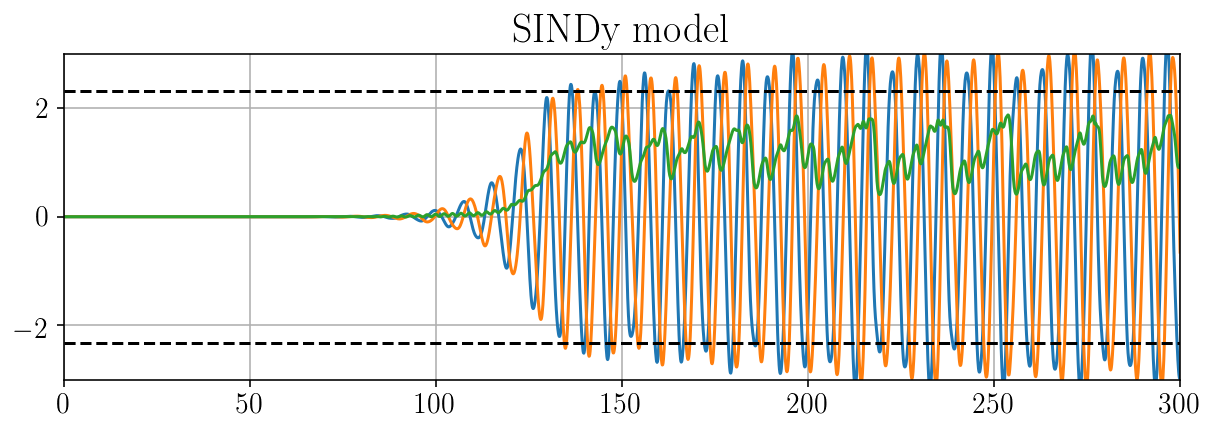

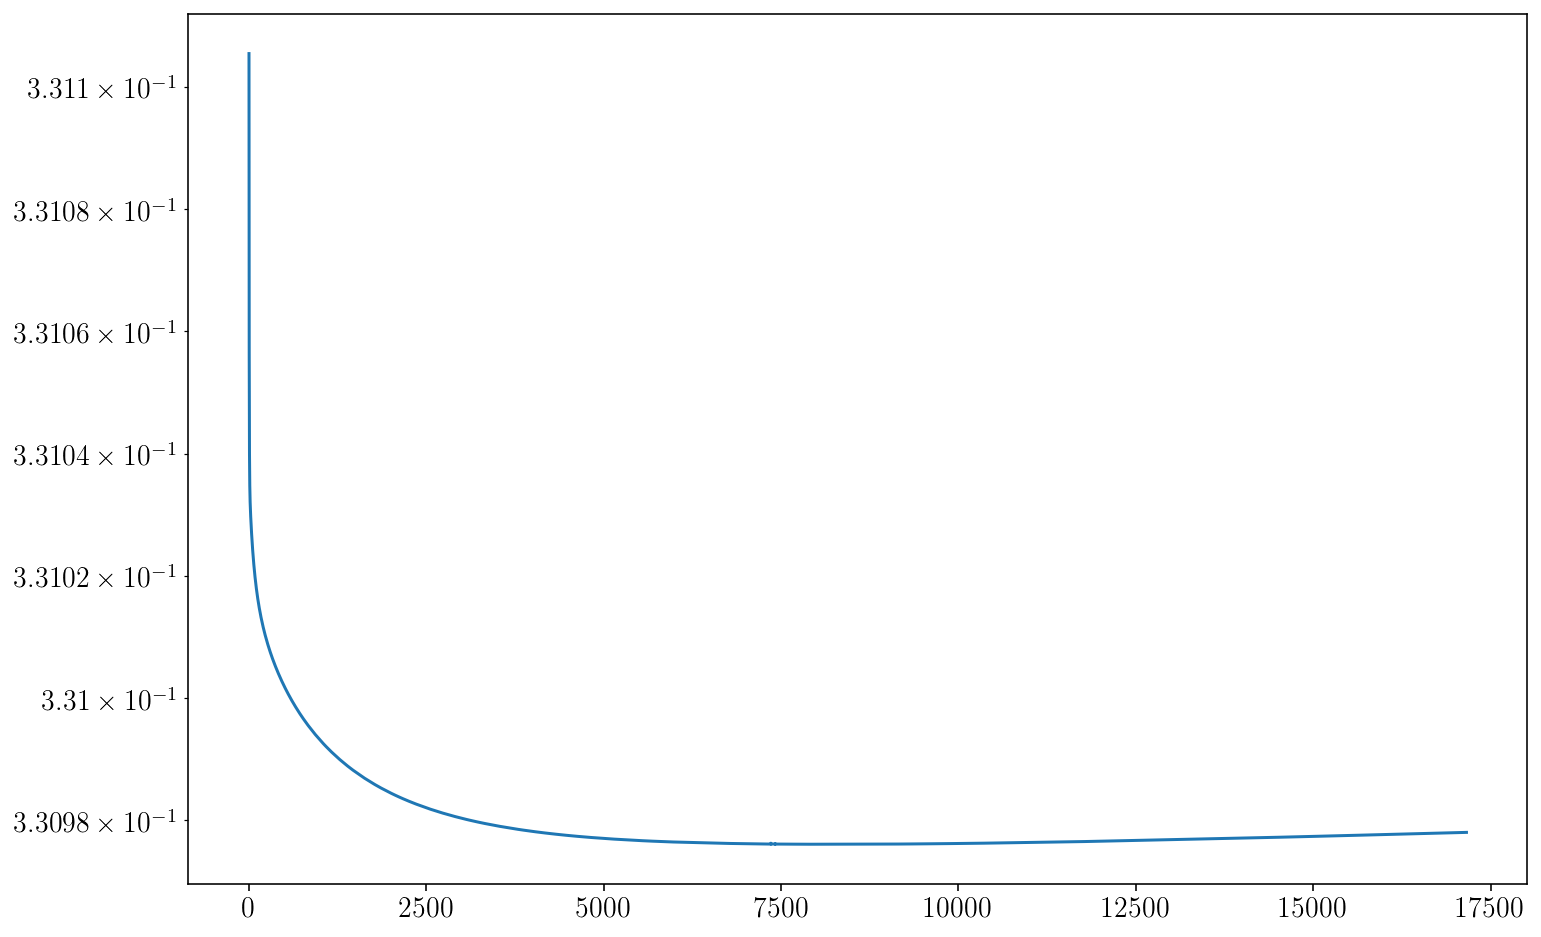

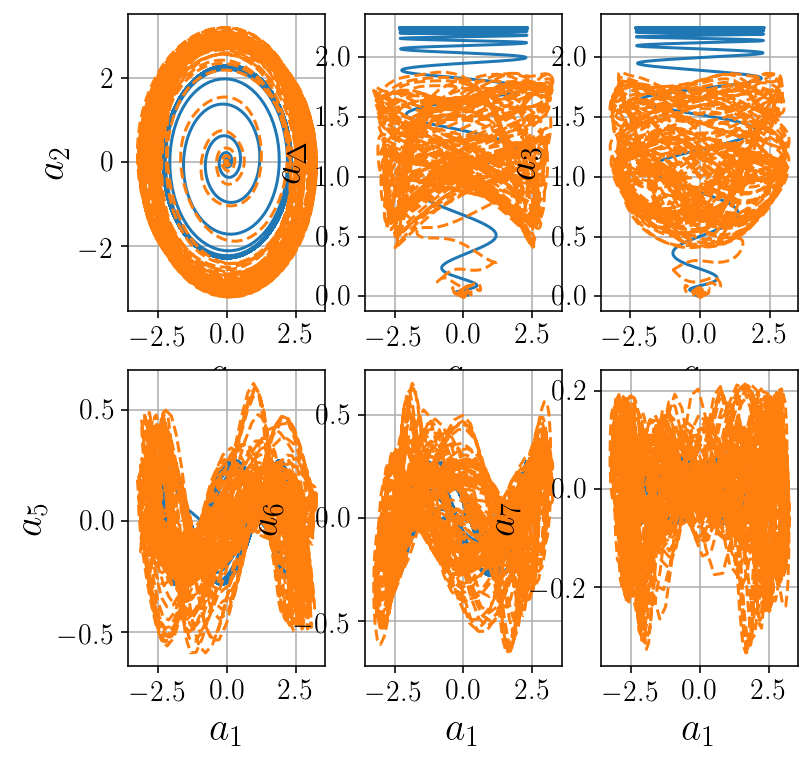

/media/akaptano/HITSI-Work/pysindy/pysindy/pysindy.py:339: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  "Control variables u were ignored because control variables were"


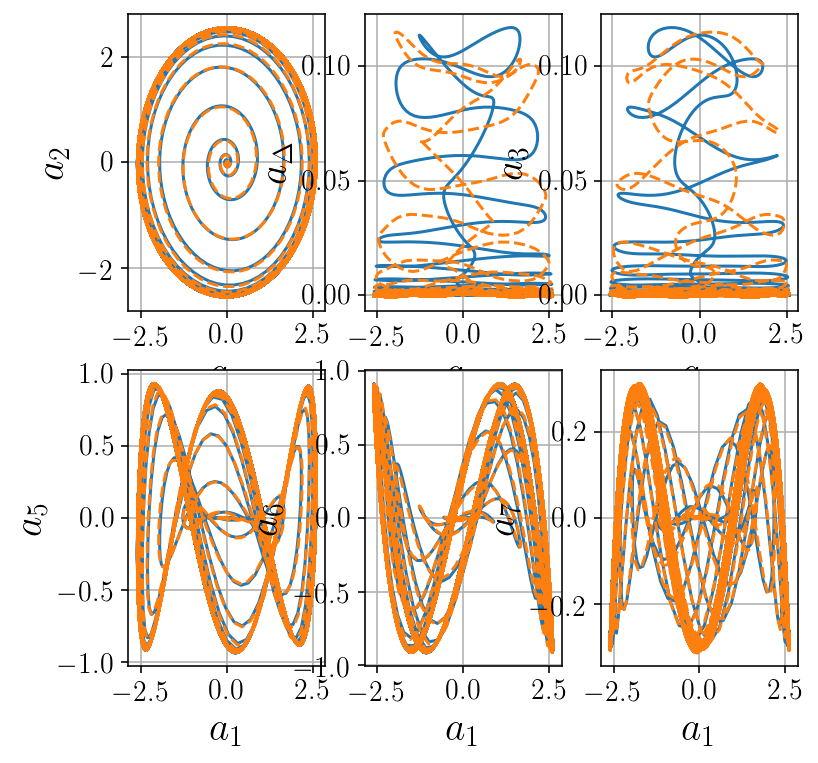

In [35]:
eta = 1.0e6
threshold = 1e-7
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, gamma=1e-3, beta=1e-2,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=30000, tol=1e-5,
                            thresholder="l1", eigmin=-1e20, eigmax=-10,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy_test = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy_test[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history[1:])

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy_test[:, 1], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy_test = model.predict(a[:, :r], t)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 1], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()


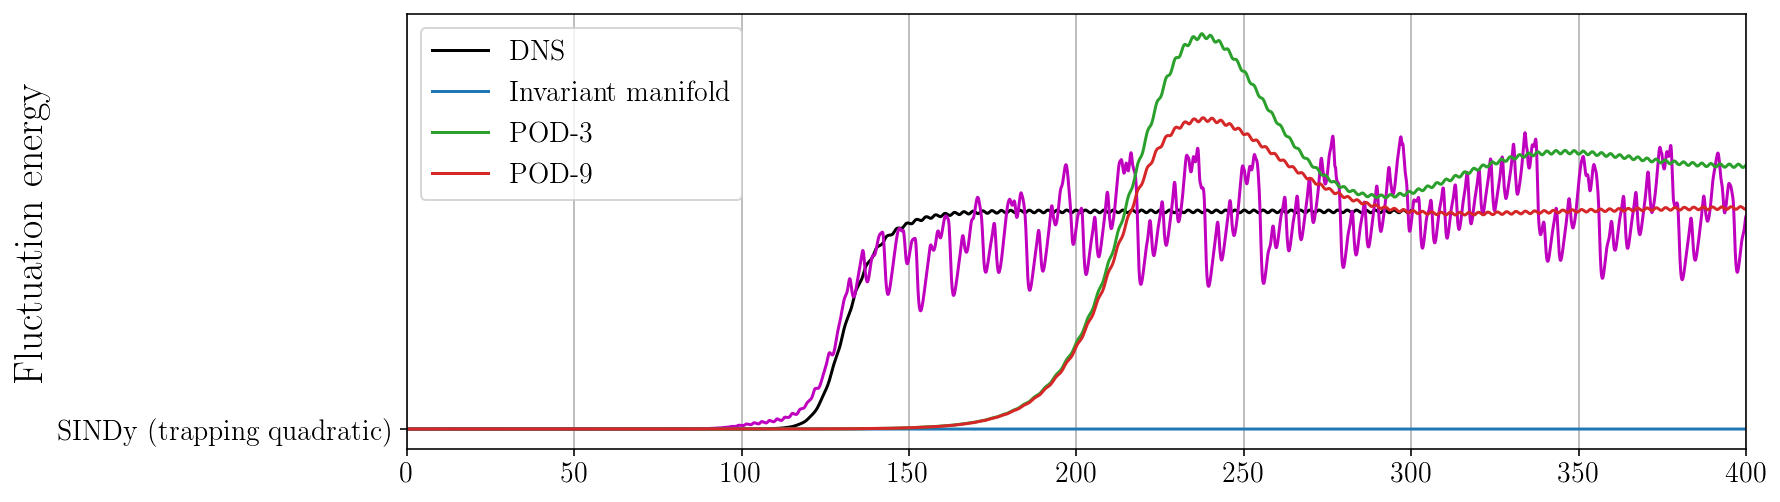

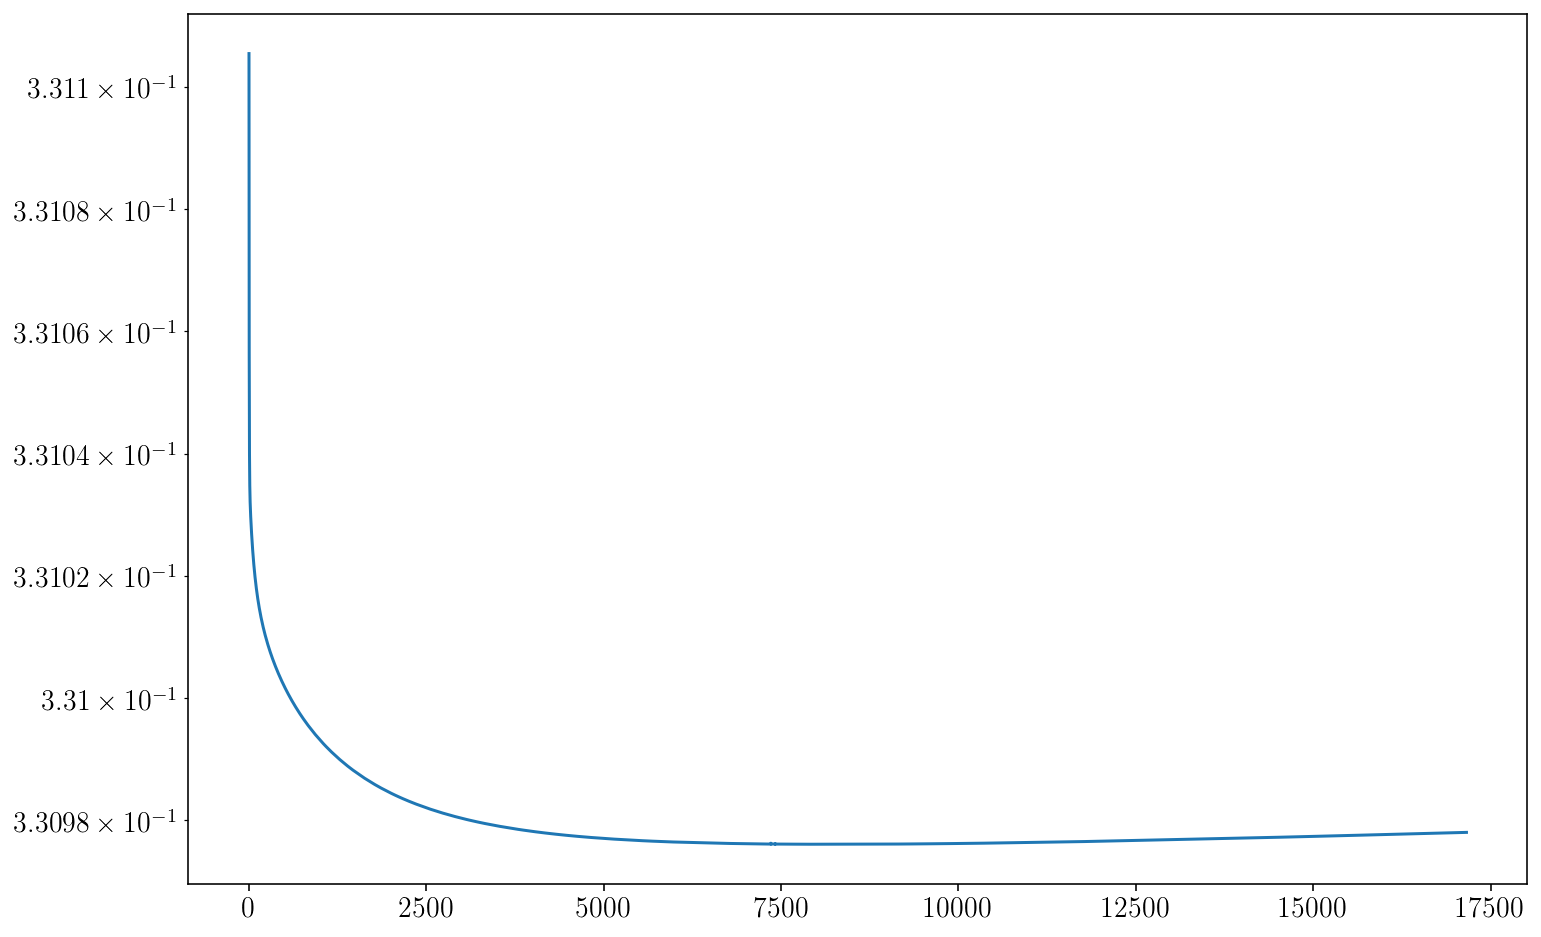

In [36]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
#E_sindy = np.sum(a_sindy**2, axis=1)
#E_sindy2 = np.sum(a_sindy2**2, axis=1)
#E_sindy3 = np.sum(a_sindy3**2, axis=1)
E_test = np.sum(a_sindy_test**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
#plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)') 
#plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_test, 'm', r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.figure()
plt.semilogy(sindy_opt.objective_history[1:])

In [28]:
galerkinQ = 0.5 * (galerkin['Q'] + np.transpose(galerkin['Q'],[0, 2, 1]))
galerkin_m = np.zeros(r)
galerkin_m[r-1] = 5.0
print(galerkin_m)
A_true = 0.5 * (galerkin['L'] + galerkin['L'].T) - np.tensordot(galerkin_m, galerkinQ, axes=([0, 0]))
eigA, eigvecA = np.linalg.eig(A_true)
#print(A_true)
print(eigA, np.all(eigA < 0.0))

[0. 0. 0. 0. 0. 0. 0. 0. 5.]
[-0.02001649 -0.06230073 -0.04256985 -0.24184036 -0.23545099 -0.16813593
 -0.16386363 -0.36999489 -0.36997048] True


In [29]:
print(sindy_opt.gamma_history_[0], sindy_opt.gamma_history_[-1])

0.001 0.0005169893588404908
